Imports

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)  # Should be 2.4.1
print(np.__version__)  # Should be 1.19.5

2.18.0
1.26.4


In [2]:
import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"

In [3]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tifffile import imread, imsave

In [4]:
def normalize_image(image):
    normalized = (image-np.min(image))/(np.max(image)-np.min(image))
    return normalized

Load and visualise image training dataset

✅ Augmented dataset loaded!
Total images: 60000
Image shape: (64, 36)
Label type: <class 'numpy.int32'>


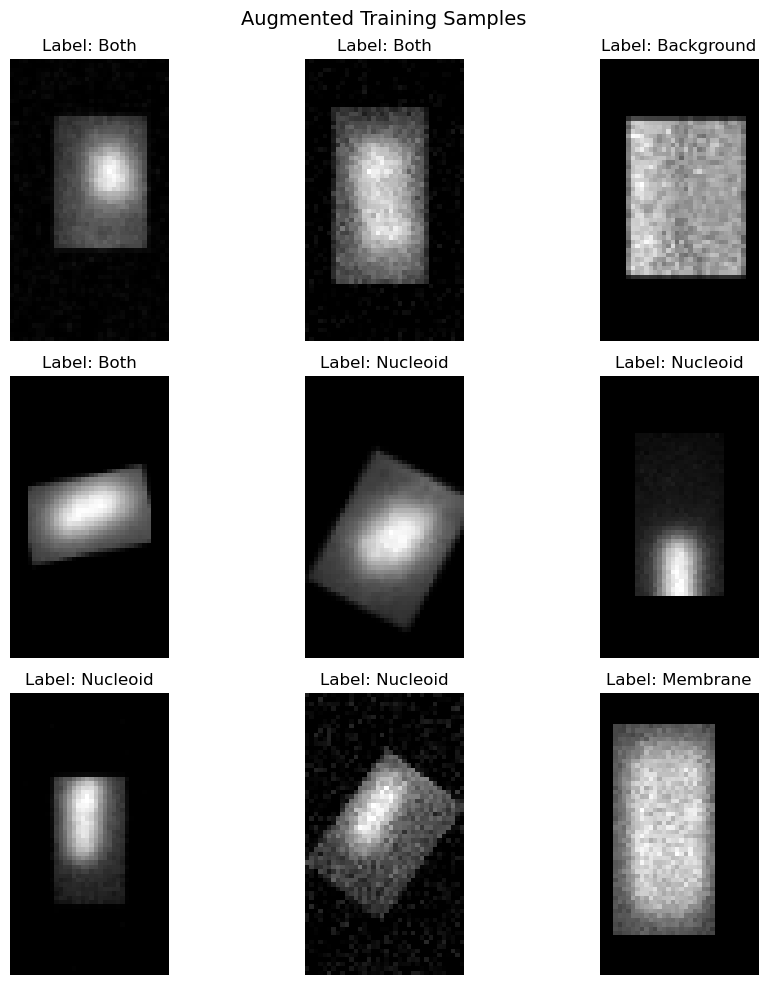

In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Path to your augmented training set
file_path = os.path.join(
    r"D:\PRISM\General_Test_PRISM\merged\CNN_dataset\augmented_train.pkl"
)
# D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\real_and_synthetic_augumented.pkl
# Load the dataset
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Check structure and unpack
if isinstance(data, tuple) and len(data) == 2:
    images, labels = data
    print("✅ Augmented dataset loaded!")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Label type: {type(labels[0])}")
else:
    raise ValueError("❌ Unexpected data structure in the pickle file.")

# Optional: label mapping
label_map = {0: "Background", 1: "Membrane", 2: "Nucleoid", 3: "Both"}

# Display random 3x3 grid of examples
num_samples = 9
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    idx = np.random.randint(0, len(images))
    image = images[idx]
    label = labels[idx]

    if image.ndim == 3 and image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_map.get(label, label)}")
    plt.axis('off')

plt.suptitle("Augmented Training Samples", fontsize=14)
plt.tight_layout()
plt.show()


## Train PRISM Model

In [5]:
# ─── GPU set-up (insert right after `import tensorflow as tf`) ──────────
print("🔍  TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
BASE = r"D:\PRISM"
if gpus:
    print(f"✅  {len(gpus)} GPU(s) detected:")
    for i, gpu in enumerate(gpus):
        print(f"    • GPU {i}: {gpu.name.split('/')[-1]}")
        # enable dynamic memory allocation
        tf.config.experimental.set_memory_growth(gpu, True)

    # OPTIONAL – use all GPUs in parallel
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print("🌀  Using MirroredStrategy for multi-GPU training")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")

else:
    print("⚠️  No GPU detected – training will run on CPU")
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
# ───────────────────────────────────────────────────────────────────────


🔍  TensorFlow version: 2.18.0
⚠️  No GPU detected – training will run on CPU


In [23]:
!nvidia-smi

Tue May 13 20:37:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8             12W /   73W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### (not used in final report) model 1

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ─── 1) Load your augmented training data ─────────────────────────
data_path = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl"
# data_path = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_train.pkl"
imgs_list, labels_list = pickle.load(open(data_path, "rb"))

# ─── 2) Stack into a single 4D array and one-hot the labels ──────
# assumes each image is 64×36 grayscale
X = np.stack(imgs_list, axis=0)       # shape (N, 64, 36)
X = X[..., np.newaxis].astype("float32")  # now (N, 64, 36, 1)
y = keras.utils.to_categorical(labels_list, num_classes=4)  # shape (N, 4)

# for synthetic images
# # 2) Stack into a single 4D array and one-hot the labels
# X = np.stack(imgs_list, axis=0)   # maybe shape (N,64,36,1,1)
# X = np.squeeze(X)                 # now (N,64,36) or (N,64,36,1)
# X = X[..., np.newaxis].astype("float32")  # (N,64,36,1)

# y = keras.utils.to_categorical(labels_list, num_classes=4)




# ─── 3) Build the classifier model ──────────────────────────────
input_shape = X.shape[1:]  # (64, 36, 1)
initializer = keras.initializers.RandomNormal(mean=0., stddev=0.01)

inp = keras.Input(shape=input_shape, name="CHANNEL-INPUT")
x = layers.Conv2D(16, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(0.001))(inp)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)   # now 32×18

x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)   # now 16×9

x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)   # now 8×4

# *** Flatten before Dense ***
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
out = layers.Dense(4, activation="softmax", name="CHANNEL-OUTPUT")(x)

model = keras.Model(inputs=inp, outputs=out, name="channel_model")
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# ─── 4) Fit with a ModelCheckpoint on val_accuracy ──────────────
ckpt_path = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505142138-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                             save_best_only=True, save_freq="epoch", verbose=1)

history_model1 = model.fit(
    x=X,
    y=y,
    batch_size=80,
    epochs=40,
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint]
)


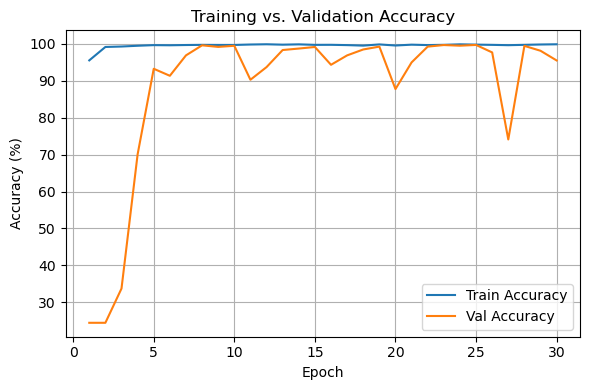

In [83]:
import matplotlib.pyplot as plt

def plot_training_curves(hist, metric="accuracy"):
    """
    Plot training & validation curves (in %) for `metric`.
    Works with a Keras History object.
    """
    epochs = range(1, len(hist.history[metric]) + 1)
    train = [v * 100 for v in hist.history[metric]]
    val   = [v * 100 for v in hist.history[f"val_{metric}"]]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label=f"Train {metric.capitalize()}")
    plt.plot(epochs, val,   label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{metric.capitalize()} (%)")
    plt.title(f"Training vs. Validation {metric.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call it (rename `history` if your variable is different)
plot_training_curves(history_model1, metric="accuracy")


⚠️  No GPU detected – running on CPU

✅  Model loaded from: D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras 

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
──────────────  Classification report  ──────────────
Class          Acc (%)     Support
Background       99.52         414
Membrane         99.28         414
Nucleoid         92.51         414
Both             93.00         414

Overall accuracy: 96.07%   (N = 1656)


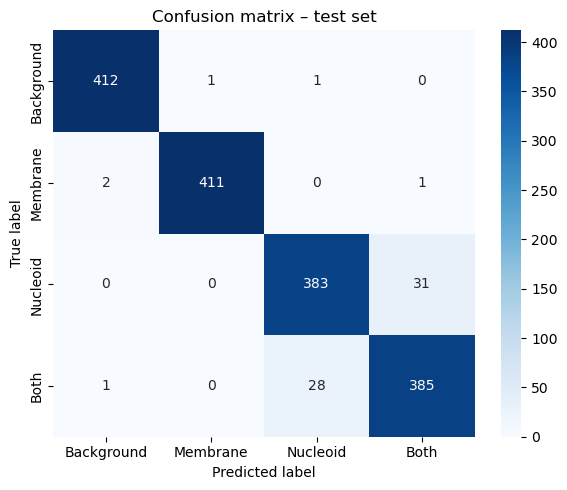

⚠️  No GPU detected – running on CPU

✅  Model loaded from: D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


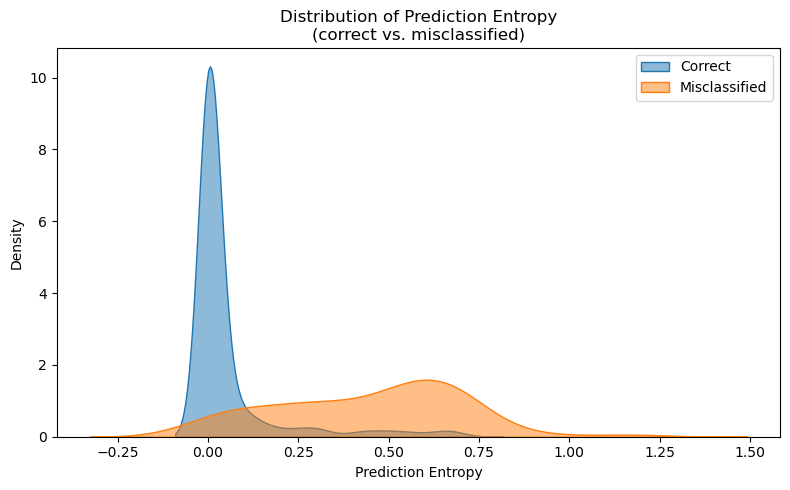

In [93]:

"""
Evaluate a trained PRISM “channel_model” on the held-out test set
----------------------------------------------------------------
 • expects test.pkl      – (images, labels) as generated earlier
 • expects best_model    – .keras file saved during training
"""

# ── Imports ────────────────────────────────────────────────────────────
import os, pickle, itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns          # for pretty confusion-matrix

# ── 0) GPU check (optional but handy) ──────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅  Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected – running on CPU")

# ── 1) Paths ───────────────────────────────────────────────────────────
base_dir   = r"D:\PRISM"
test_pkl   = os.path.join(base_dir,
                          r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl")
model_file = os.path.join(base_dir, "PRISM_model", "100xTraining", "saved_model", "saved-plain-model-202505132209-37-0.93.keras")

# ── 2) Load data ───────────────────────────────────────────────────────
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)

images = np.asarray(images, dtype=np.float32)      # (N,64,36)
labels = np.asarray(labels, dtype=np.int32)        # (N,)

# same normalisation used at training time
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]                         # add channel axis  → (N,64,36,1)

# ── 3) Load the trained model ──────────────────────────────────────────
model = tf.keras.models.load_model(model_file)
print("\n✅  Model loaded from:", model_file, "\n")

# ── 4) Predict ─────────────────────────────────────────────────────────
pred_logits = model.predict(X_test, verbose=1)
y_pred      = np.argmax(pred_logits, axis=1)

# ── 5) Metrics: confusion-matrix & per-class accuracy ─────────────────
num_classes = len(np.unique(labels))
conf_mat    = np.zeros((num_classes, num_classes), dtype=int)

for true_lbl, pred_lbl in zip(labels, y_pred):
    conf_mat[true_lbl, pred_lbl] += 1

per_class_acc = (np.diag(conf_mat) / conf_mat.sum(axis=1)) * 100      # (%)
overall_acc   = np.trace(conf_mat) / np.sum(conf_mat) * 100

# ── 6) Nicely print the results ───────────────────────────────────────
label_names = {0: "Background", 1: "Membrane", 2: "Nucleoid", 3: "Both"}

print("──────────────  Classification report  ──────────────")
print(f"{'Class':<12}{'Acc (%)':>10}{'Support':>12}")
for cls in range(num_classes):
    support = conf_mat[cls].sum()
    print(f"{label_names.get(cls,cls):<12}{per_class_acc[cls]:>10.2f}{support:>12}")

print(f"\nOverall accuracy: {overall_acc:.2f}%   (N = {len(labels)})")

# ── 7) Optional: plot confusion-matrix ────────────────────────────────
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=[label_names[i] for i in range(num_classes)],
            yticklabels=[label_names[i] for i in range(num_classes)],
            cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion matrix – test set")
plt.tight_layout()
plt.show()
# ── Imports ────────────────────────────────────────────────────────────
import os, pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# ── 0) GPU check (optional) ──────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅  Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected – running on CPU")

# ── 1) Paths ───────────────────────────────────────────────────────────
base_dir   = r"D:\PRISM"
test_pkl   = os.path.join(
    base_dir,
    r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl"
)

# ── 2) Load data ───────────────────────────────────────────────────────
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)

images = np.asarray(images, dtype=np.float32)      # (N,64,36)
labels = np.asarray(labels, dtype=np.int32)        # (N,)

# same normalization used at train time
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]                         # (N,64,36,1)

# ── 3) Load model & predict ──────────────────────────────────────────
model = tf.keras.models.load_model(model_file)
print("\n✅  Model loaded from:", model_file, "\n")

# softmax outputs
probs = model.predict(X_test, verbose=1)           # shape (N,4)
y_pred = np.argmax(probs, axis=1)

# ── 4) Compute per-sample entropy as confidence measure ─────────────
# entropy = -sum p * log(p)
entropies = -np.sum(probs * np.log(probs + 1e-12), axis=1)

# mask correct vs misclassified
correct_mask = (y_pred == labels)
mis_mask     = ~correct_mask

# ── 5) Plot distributions ────────────────────────────────────────────
plt.figure(figsize=(8,5))
sns.kdeplot(entropies[correct_mask], label="Correct",    fill=True, alpha=0.5)
sns.kdeplot(entropies[mis_mask],     label="Misclassified", fill=True, alpha=0.5)
plt.xlabel("Prediction Entropy")
plt.ylabel("Density")
plt.title("Distribution of Prediction Entropy\n(correct vs. misclassified)")
plt.legend()
plt.tight_layout()
plt.show()



52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


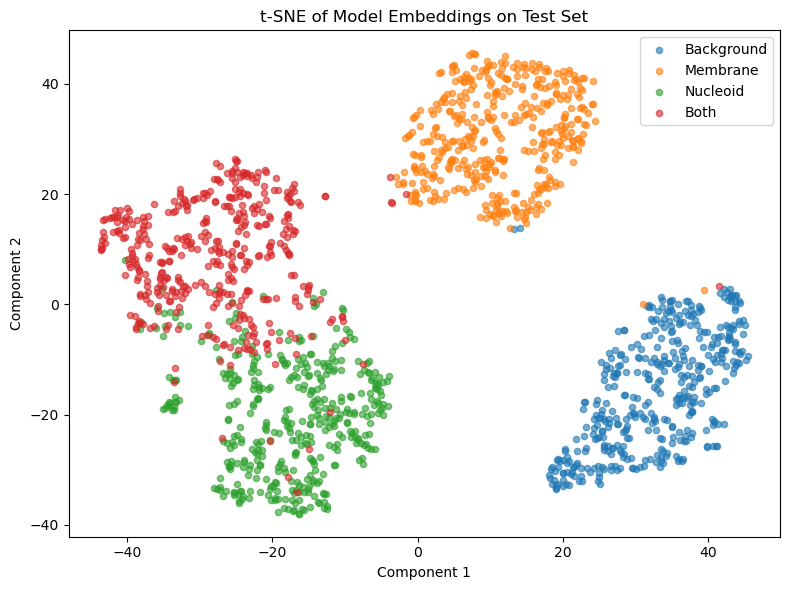

In [94]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ── 1) Load test set ───────────────────────────────────────────
base_dir = r"D:\PRISM"
test_pkl = os.path.join(base_dir, r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl")
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)
images = np.asarray(images, dtype=np.float32)
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]  # (N,64,36,1)

# ── 2) Load trained model ─────────────────────────────────────
model_file = os.path.join(base_dir, "PRISM_model", "100xTraining",
                          "saved_model", "saved-plain-model-202505132209-37-0.93.keras")
model = tf.keras.models.load_model(model_file)

# ── 3) Extract embedding layer output ─────────────────────────
# If you have an L2-normalization layer named "embedding_l2_norm", use it; otherwise use the penultimate Dense.
try:
    embedding_layer = model.get_layer("embedding_l2_norm")
except ValueError:
    # fallback: the layer before softmax (penultimate)
    embedding_layer = model.layers[-2]
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings = embedding_model.predict(X_test, verbose=1)

# ── 4) Run t-SNE ───────────────────────────────────────────────
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d = tsne.fit_transform(embeddings)

# ── 5) Plot ───────────────────────────────────────────────────
label_names = {0: "Background", 1: "Membrane", 2: "Nucleoid", 3: "Both"}
plt.figure(figsize=(8, 6))
for cls in np.unique(labels):
    mask = labels == cls
    plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=label_names[cls], alpha=0.6, s=20)
plt.title("t-SNE of Model Embeddings on Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
import numpy as np

# assume you already have:
#   labels    : shape (N,) true class ints in 0…C–1  
#   y_pred    : shape (N,) predicted class ints  
#   entropies : shape (N,) per‐sample entropy

classes = np.unique(labels)
ths = np.linspace(entropies.min(), entropies.max(), 500)

best = None  # (coverage, threshold, per_class_acc_dict)
for T in ths:
    sel = entropies < T
    if sel.sum() == 0:
        continue
    cov = sel.mean()
    # compute per‐class accuracy on the selected subset
    good = True
    accs = {}
    for c in classes:
        idx_c = sel & (labels == c)
        if idx_c.sum() == 0:
            good = False
            break
        acc_c = (y_pred[idx_c] == labels[idx_c]).mean()
        accs[c] = acc_c
        if acc_c < 0.95:    # require ≥90% accuracy for this class
            good = False
            break
    if not good:
        continue

    # among thresholds that satisfy per‐class ≥90%, keep the max coverage
    if best is None or cov > best[0]:
        best = (cov, T, accs)

if best is None:
    raise ValueError("No threshold keeps all classes at ≥ 90% accuracy")

cov_best, T_best, per_class_acc = best
print(f"Selected entropy threshold T* = {T_best:.4f}")
print(f"Coverage retained     = {cov_best*100:5.2f}%")
print("Per‐class accuracies:")
for c, a in per_class_acc.items():
    print(f"  Class {c:<2} : {a*100:5.2f}%")


Selected entropy threshold T* = 0.4013
Coverage retained     = 92.93%
Per‐class accuracies:
  Class 0  : 100.00%
  Class 1  : 99.50%
  Class 2  : 95.12%
  Class 3  : 98.03%


In [39]:
import numpy as np
from sklearn.mixture import GaussianMixture

# 1) compute entropies as before
entropies = -np.sum(probs * np.log(probs + 1e-12), axis=1)

# 2a) Option A: GMM‐based threshold
ent = entropies.reshape(-1,1)
gmm = GaussianMixture(n_components=2, random_state=0).fit(ent)
means   = gmm.means_.flatten();   vars_   = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()
order = np.argsort(means)
m1,m2 = means[order]; v1,v2 = vars_[order]; w1,w2 = weights[order]
a = 1/(2*v2) - 1/(2*v1); b = m1/v1 - m2/v2
c = m2*m2/(2*v2) - m1*m1/(2*v1) + np.log((w1*np.sqrt(v2))/(w2*np.sqrt(v1)))
disc = b*b - 4*a*c
roots = [(-b+np.sqrt(disc))/(2*a), (-b-np.sqrt(disc))/(2*a)]
T_gmm = [x for x in roots if m1 < x < m2][0]

# 2b) Option B: percentile‐based threshold
T_pct = np.percentile(entropies, 95)

# 3) Apply to your test set
for T in (T_gmm, T_pct):
    keep = entropies < T
    kept_pct = keep.mean() * 100
    print(f"Threshold {T:.4f} retains {kept_pct:.1f}% of samples")

    # you can still compute accuracy on your _validation_ set if you have labels,
    # but at deployment you simply reject anything with entropy ≥ T.


Threshold 0.0125 retains 66.2% of samples
Threshold 0.5007 retains 95.0% of samples


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


⚠️ No GPU detected – using CPU

✅ Loaded model from D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
── Full Test Set ─────────────────────────────
 Class 0    Acc 99.52%   N=414
 Class 1    Acc 99.28%   N=414
 Class 2    Acc 92.51%   N=414
 Class 3    Acc 93.00%   N=414
 Overall Accuracy: 96.07%

── GMM: low-entropy mean m1=0.0020, high-entropy mean m2=0.1951
    → Using threshold T = m2 = 0.1951

── Accepted Samples Only (ent < m2) ───────────
 Class 0    Acc 100.00%   N=412
 Class 1    Acc 99.74%   N=387
 Class 2    Acc 97.85%   N=326
 Class 3    Acc 98.51%   N=335
 Overall Accuracy: 99.11%   Coverage: 88.16%



c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


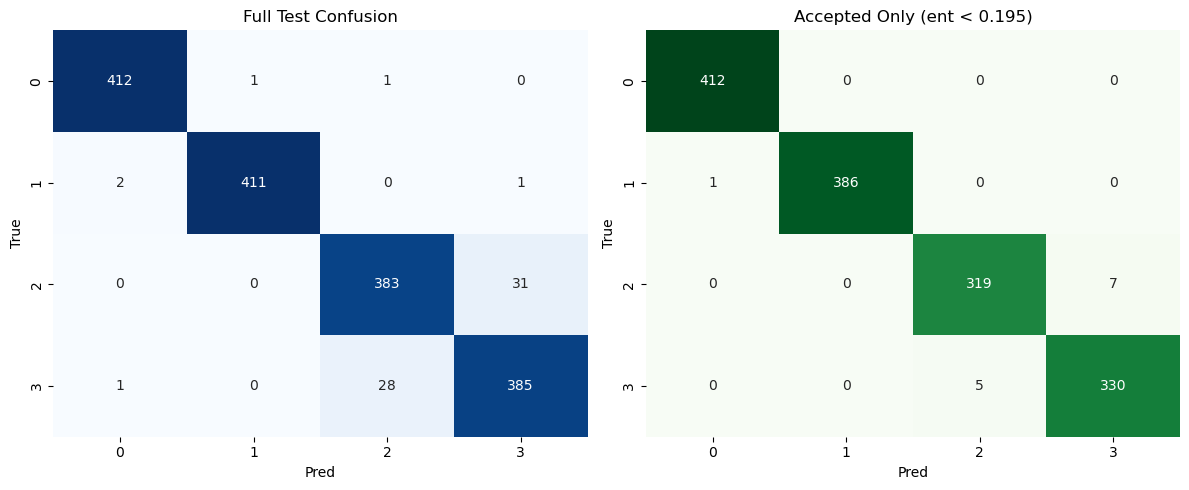

In [48]:
import os
import math
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# ── 0) GPU check (optional) ─────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ GPU detected: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected – using CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────────
BASE       = r"D:\PRISM"
TEST_PKL   = os.path.join(
    BASE,
    r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl"
)
MODEL_FILE = os.path.join(
    BASE,
    r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras"
)

# ── 2) Load test data ────────────────────────────────────────────────────
with open(TEST_PKL, "rb") as fh:
    images, labels = pickle.load(fh)

images = np.asarray(images, dtype=np.float32)      # (N,64,36)
labels = np.asarray(labels, dtype=np.int32)        # (N,)

# normalize exactly as during training
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]                         # (N,64,36,1)

# ── 3) Load model & predict ─────────────────────────────────────────────
model = tf.keras.models.load_model(MODEL_FILE)
print(f"\n✅ Loaded model from {MODEL_FILE}\n")

probs  = model.predict(X_test, verbose=1)    # (N,4) softmax outputs
y_pred = np.argmax(probs, axis=1)            # (N,)

# ── 4) Full-set accuracy & confusion ──────────────────────────────────
num_cls = len(np.unique(labels))
cm_full = np.zeros((num_cls, num_cls), dtype=int)
for t, p in zip(labels, y_pred):
    cm_full[t, p] += 1

acc_per_full = np.diag(cm_full) / cm_full.sum(axis=1) * 100
acc_ovr_full = np.trace(cm_full) / cm_full.sum() * 100

print("── Full Test Set ─────────────────────────────")
for c in range(num_cls):
    print(f" Class {c:<2}   Acc {acc_per_full[c]:5.2f}%   N={cm_full[c].sum()}")
print(f" Overall Accuracy: {acc_ovr_full:5.2f}%\n")

# ── 5) Compute per-sample entropy ───────────────────────────────────────
ent = -np.sum(probs * np.log(probs + 1e-12), axis=1)  # (N,)

# ── 6) Fit 2-component GMM on entropies ───────────────────────────────
ent_1d = ent.reshape(-1, 1)
gmm    = GaussianMixture(n_components=2, random_state=0).fit(ent_1d)

means = gmm.means_.flatten()
# sort so component 0 is lower-entropy cluster
m1, m2 = np.sort(means)

T_mean2 = m2
print(f"── GMM: low-entropy mean m1={m1:.4f}, high-entropy mean m2={m2:.4f}")
print(f"    → Using threshold T = m2 = {T_mean2:.4f}\n")

# ── 7) Apply threshold & recompute accuracy/confusion ────────────────
mask_accept = ent < T_mean2

cm_acc = np.zeros_like(cm_full)
for t, p, keep in zip(labels, y_pred, mask_accept):
    if keep:
        cm_acc[t, p] += 1

acc_per_acc = np.diag(cm_acc) / cm_acc.sum(axis=1) * 100
acc_ovr_acc = np.trace(cm_acc) / cm_acc.sum() * 100
cov_acc     = mask_accept.mean() * 100

print("── Accepted Samples Only (ent < m2) ───────────")
for c in range(num_cls):
    n_c = cm_acc[c].sum()
    print(f" Class {c:<2}   Acc {acc_per_acc[c]:5.2f}%   N={n_c}")
print(f" Overall Accuracy: {acc_ovr_acc:5.2f}%   Coverage: {cov_acc:5.2f}%\n")

# ── 8) Display both confusion matrices ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_full, annot=True, fmt="d", ax=axes[0], cmap="Blues",
            cbar=False)
axes[0].set(title="Full Test Confusion", xlabel="Pred", ylabel="True")

sns.heatmap(cm_acc, annot=True, fmt="d", ax=axes[1], cmap="Greens",
            cbar=False)
axes[1].set(title=f"Accepted Only (ent < {T_mean2:.3f})", xlabel="Pred", ylabel="True")

plt.tight_layout()
plt.show()


### (not used in final report) Model 1 with better separation

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ─── 1) Custom ArcFace Layer ─────────────────────────────────────────
class ArcFace(layers.Layer):
    def __init__(self, n_classes, s=30.0, m=0.3, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        # input_shape = (batch, embedding_dim)
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.n_classes),
            initializer="glorot_uniform",
            trainable=True,
        )

    def call(self, embeddings, labels):
        x = tf.nn.l2_normalize(embeddings, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_t = tf.matmul(x, W)
        cos_t = tf.clip_by_value(cos_t, -1 + 1e-7, 1 - 1e-7)
        theta = tf.acos(cos_t)
        cos_t_m = tf.cos(theta + self.m)
        one_hot = tf.one_hot(labels, depth=self.n_classes)
        logits = self.s * (one_hot * cos_t_m + (1 - one_hot) * cos_t)
        return logits

# ─── 2) Load & preprocess data ───────────────────────────────────────
data_path = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl"
imgs_list, labels_list = pickle.load(open(data_path, "rb"))

# Stack images, normalize, add channel dim
X = np.stack(imgs_list, axis=0).astype("float32")        # (N,64,36)
X = (X - X.min())/(X.max() - X.min() + 1e-8)
X = X[..., None]                                          # (N,64,36,1)

# Integer labels and one-hot labels
labels = np.array(labels_list, dtype=np.int32)           # (N,)
y_onehot = keras.utils.to_categorical(labels, num_classes=4)  # (N,4)

# ─── 3) Build model with ArcFace head ──────────────────────────────
input_img   = keras.Input(shape=X.shape[1:], name="CHANNEL_INPUT")
input_label = keras.Input(shape=(), dtype=tf.int32, name="LABEL_INPUT")

initializer = keras.initializers.RandomNormal(mean=0., stddev=0.01)
x = layers.Conv2D(16, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(1e-3))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)   # →32×18

x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)   # →16×9

x = layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_initializer=initializer,
                  kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)   # →8×4

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = layers.Dropout(0.2)(x)
embeddings = layers.Dense(64, name="EMBEDDING")(x)

# ArcFace margin head
logits = ArcFace(n_classes=4, s=30.0, m=0.3, name="arcface")(embeddings, input_label)
output = layers.Activation("softmax", name="CHANNEL_OUTPUT")(logits)

model = keras.Model(
    inputs=[input_img, input_label],
    outputs=output,
    name="channel_model_arcface"
)

# ─── 4) Compile with AdamW + CategoricalCrossentropy + label smoothing ─
epochs = 40
batch_size = 80
steps_per_epoch = int((0.8 * X.shape[0]) // batch_size)
total_steps = steps_per_epoch * epochs

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=total_steps,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-4
)
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

model.summary()

# ─── 5) Train with checkpointing ────────────────────────────────────
ckpt_dir = r"D:\PRISM\PRISM_model\100xTraining\arcface_model1"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "arcface-202505141855-{epoch:02d}-{val_accuracy:.2f}.keras")

checkpoint = ModelCheckpoint(
    ckpt_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Note: pass labels twice—once as model input for ArcFace, once as target
history = model.fit(
    x = [X, labels],
    y = y_onehot,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    shuffle = True,
    callbacks = [checkpoint]
)


### The PRISM CNN Model Reported

In [ ]:
# train with label smoothing
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 1) Load your already‐augmented training data
#    expecting a tuple (images, labels) where
#      images.shape == (N, 64, 36)
#      labels.shape == (N,)  integers in {0,1,2,3}
images, labels = pickle.load(open(
    r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl","rb"
))

# 2) Pre‐process
#  – cast to float32, normalize to [0,1]
#  – add channel axis so shape → (N,64,36,1)
X = np.array(images, dtype=np.float32)
X = (X - X.min())/(X.max()-X.min()+1e-8)
X = X[...,None]

#  – one‐hot encode your labels → (N,4)
y = to_categorical(labels, num_classes=4)
strategy = tf.distribute.MirroredStrategy()
# 3) Build your model (GlobalAveragePooling version)
with strategy.scope():
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
        inp = keras.Input((64,36,1), name="CHANNEL_IN")
        x = keras.layers.Conv2D(16,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(inp)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(16,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2,2))(x)

        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2,2))(x)

        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)

        # **the only change**: global pool to collapse H×W
        x = keras.layers.GlobalAveragePooling2D()(x)

        # now x.shape == (batch_size, 32), so Flatten is optional
        x = keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(1e-3))(x)
        out = keras.layers.Dense(4, activation="softmax", name="CHANNEL_OUT")(x)
        model = keras.Model(inp, out, name="channel_model")

        # 2) compile with label‐smoothing inside the same scope
        loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
        model.compile(
                optimizer="adam",
                loss=loss_fn,
                metrics=["accuracy"]
        )
        model.summary()


checkpoint = ModelCheckpoint(
    filepath = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor  = "val_accuracy",
    save_best_only=True,
    mode     ="max"
)

history_model2 = model.fit(
    x                = X,
    y                = y,
    batch_size       = 80,
    epochs           = 40,
    validation_split = 0.2,
    shuffle          = True,
    callbacks        = [checkpoint]
)


In [ ]:
# Setup 4: train with label smoothing for general test with real and synt data
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 1) Load your already‐augmented training data
#    expecting a tuple (images, labels) where
#      images.shape == (N, 64, 36)
#      labels.shape == (N,)  integers in {0,1,2,3}
images, labels = pickle.load(open(
    r"D:\PRISM\General_Test_PRISM\merged\CNN_dataset\real_and_synthetic_augumented.pkl","rb"
))

# 2) Pre‐process
#  – cast to float32, normalize to [0,1]
#  – add channel axis so shape → (N,64,36,1)
X = np.array(images, dtype=np.float32)
X = (X - X.min())/(X.max()-X.min()+1e-8)
X = X[...,None]

#  – one‐hot encode your labels → (N,4)
y = to_categorical(labels, num_classes=4)
strategy = tf.distribute.MirroredStrategy()
# 3) Build your model (GlobalAveragePooling version)
with strategy.scope():
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
        inp = keras.Input((64,36,1), name="CHANNEL_IN")
        x = keras.layers.Conv2D(16,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(inp)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(16,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2,2))(x)

        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2,2))(x)

        x = keras.layers.Conv2D(32,3,padding="same", activation="relu",
                kernel_initializer=initializer, kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.BatchNormalization()(x)

        # **the only change**: global pool to collapse H×W
        x = keras.layers.GlobalAveragePooling2D()(x)

        # now x.shape == (batch_size, 32), so Flatten is optional
        x = keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(1e-3))(x)
        out = keras.layers.Dense(4, activation="softmax", name="CHANNEL_OUT")(x)
        model = keras.Model(inp, out, name="channel_model")

        # 2) compile with label‐smoothing inside the same scope
        loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
        model.compile(
                optimizer="adam",
                loss=loss_fn,
                metrics=["accuracy"]
        )
        model.summary()


checkpoint = ModelCheckpoint(
    filepath = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\generalisation_realandsynth-20250517-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor  = "val_accuracy",
    save_best_only=True,
    mode     ="max"
)

history_model2 = model.fit(
    x                = X,
    y                = y,
    batch_size       = 80,
    epochs           = 40,
    validation_split = 0.2,
    shuffle          = True,
    callbacks        = [checkpoint]
)


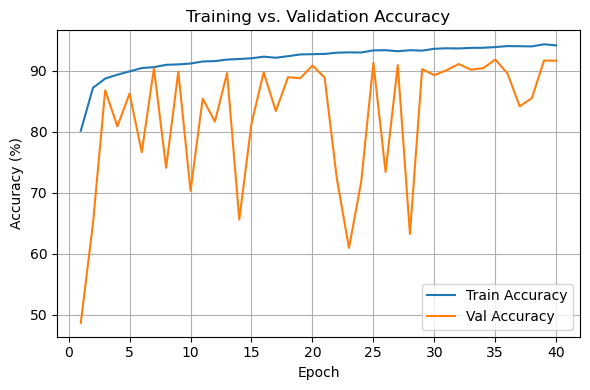

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(hist, metric="accuracy"):
    """
    Plot training & validation curves (in %) for `metric`.
    Works with a Keras History object.
    """
    epochs = range(1, len(hist.history[metric]) + 1)
    train = [v * 100 for v in hist.history[metric]]
    val   = [v * 100 for v in hist.history[f"val_{metric}"]]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label=f"Train {metric.capitalize()}")
    plt.plot(epochs, val,   label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{metric.capitalize()} (%)")
    plt.title(f"Training vs. Validation {metric.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call it (rename `history` if your variable is different)
plot_training_curves(history_model2, metric="accuracy")


#### Inspection of Errors

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


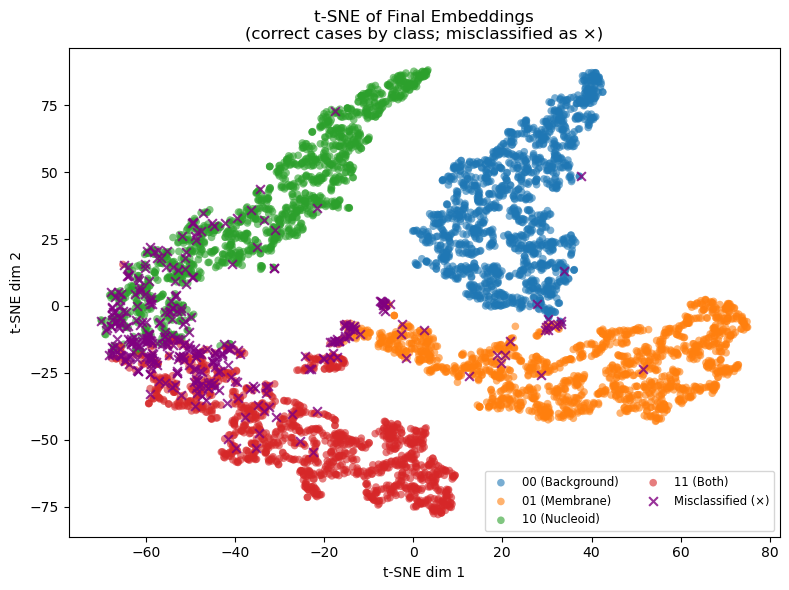

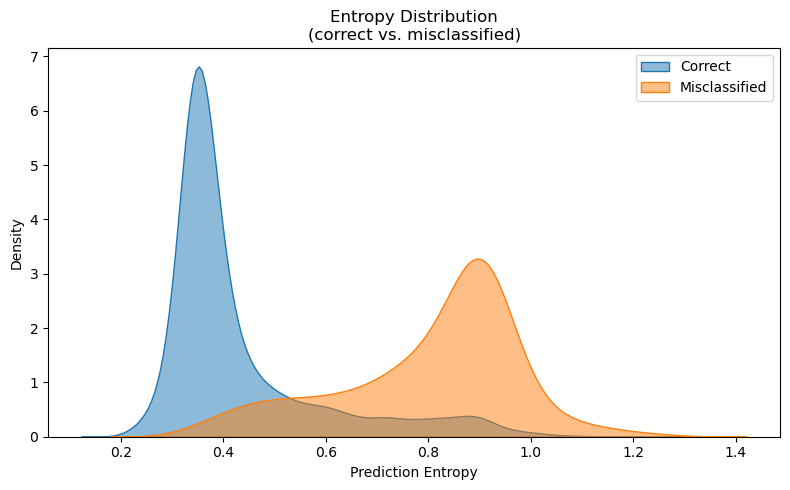

In [27]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) Load test set ───────────────────────────────────────────
base_dir = r"D:\PRISM"
test_pkl = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl"
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)
images = np.asarray(images, dtype=np.float32)
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]
y_test = np.asarray(labels, dtype=np.int32)  # 0=00,1=01,2=10,3=11

# ── 2) Stratified random sample of 10k examples ───────────────
rng = np.random.default_rng(seed=42)
sample_idx = []
for cls in range(4):
    cls_idx = np.where(y_test == cls)[0]
    sample_idx.append(rng.choice(cls_idx, size=1500, replace=False))
sample_idx = np.concatenate(sample_idx)
rng.shuffle(sample_idx)

X_sel = X_test[sample_idx]
y_sel = y_test[sample_idx]

# ── 3) Load your trained model ────────────────────────────────
model_file = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"
model = tf.keras.models.load_model(model_file)

# ── 4) Build embedding extractor ──────────────────────────────
try:
    emb_layer = model.get_layer("embedding_l2_norm")
except ValueError:
    emb_layer = model.layers[-2]
emb_extractor = Model(inputs=model.input, outputs=emb_layer.output)

# ── 5) Get embeddings + predictions + entropy ────────────────
embeddings = emb_extractor.predict(X_sel, batch_size=256, verbose=1)
probs      = model.predict(X_sel, batch_size=256, verbose=1)
y_pred     = np.argmax(probs, axis=1)
entropies  = -np.sum(probs * np.log(probs + 1e-12), axis=1)

correct_mask = (y_pred == y_sel)
mis_mask     = ~correct_mask

# ── 6) t-SNE on embeddings ────────────────────────────────────
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d = tsne.fit_transform(embeddings)

# ── 7) Plot t-SNE with class colours + misclassified as crosses ─
label_names = {0: "00 (Background)", 1: "01 (Membrane)", 2: "10 (Nucleoid)", 3: "11 (Both)"}
plt.figure(figsize=(8, 6))

# Plot correct samples, colored by class
for cls in range(4):
    mask = (y_sel == cls) & correct_mask
    plt.scatter(
        emb_2d[mask, 0], emb_2d[mask, 1],
        label=label_names[cls], alpha=0.6, s=30,
        facecolors=plt.cm.tab10(cls), edgecolors='none'
    )

# Plot all misclassified samples as red crosses
plt.scatter(
    emb_2d[mis_mask, 0], emb_2d[mis_mask, 1],
    label="Misclassified (×)", marker='x', c='purple', alpha=0.8, s=40
)

plt.title("t-SNE of Final Embeddings\n(correct cases by class; misclassified as ×)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=1, fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# ── 8) Plot entropy distributions ──────────────────────────────
plt.figure(figsize=(8,5))
sns.kdeplot(entropies[correct_mask],   label="Correct",       fill=True, alpha=0.5)
sns.kdeplot(entropies[mis_mask],       label="Misclassified",  fill=True, alpha=0.5)
plt.xlabel("Prediction Entropy")
plt.ylabel("Density")
plt.title("Entropy Distribution\n(correct vs. misclassified)")
plt.legend()
plt.tight_layout()
plt.show()


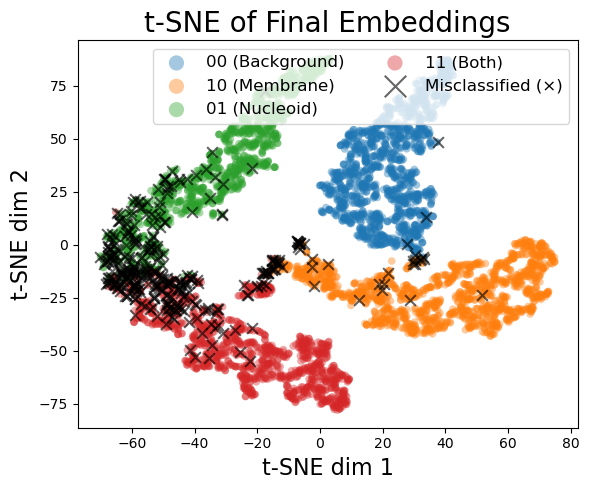

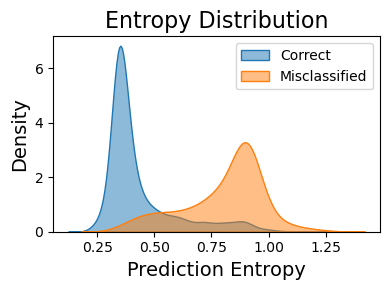

In [91]:
# ── 7) Plot t-SNE with class colours + misclassified as crosses ─
label_names = {0: "00 (Background)", 1: "10 (Membrane)", 2: "01 (Nucleoid)", 3: "11 (Both)"}
plt.figure(figsize=(6, 5))

# Plot correct samples, colored by class
for cls in range(4):
    mask = (y_sel == cls) & correct_mask
    plt.scatter(
        emb_2d[mask, 0], emb_2d[mask, 1],
        label=label_names[cls], alpha=0.4, s=30,
        facecolors=plt.cm.tab10(cls), edgecolors='none'
    )

# Plot all misclassified samples as red crosses
plt.scatter(
    emb_2d[mis_mask, 0], emb_2d[mis_mask, 1],
    label="Misclassified (×)", marker='x', c='black', alpha=0.6, s=60
)

plt.title("t-SNE of Final Embeddings", fontsize=20)
plt.xlabel("t-SNE dim 1", fontsize=16)
plt.ylabel("t-SNE dim 2", fontsize=16)
plt.legend(markerscale=2, fontsize='large', ncol=2)
plt.tight_layout()
plt.show()

# ── 8) Plot entropy distributions ──────────────────────────────
plt.figure(figsize=(4,3))
sns.kdeplot(entropies[correct_mask],   label="Correct",       fill=True, alpha=0.5)
sns.kdeplot(entropies[mis_mask],       label="Misclassified",  fill=True, alpha=0.5)
plt.xlabel("Prediction Entropy", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Entropy Distribution", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

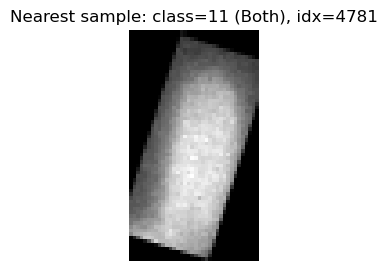

4781

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def retrieve_by_embedding(query_point, embeddings, X_samples, y_samples, label_names):
    """
    Find the index of the sample whose embedding is closest to query_point,
    and plot that image along with its true label.
    
    query_point: array, shape (D,)
    embeddings:   array, shape (N, D)
    X_samples:    array, shape (N, H, W, C)
    y_samples:    array, shape (N,)
    label_names:  dict mapping class indices -> human labels
    """
    # 1) Compute squared Euclidean distances
    dists = np.sum((embeddings - query_point[np.newaxis, :])**2, axis=1)
    idx = np.argmin(dists)

    # 2) Retrieve and plot the image
    img = X_samples[idx, ..., 0]  # drop channel dim
    lbl = y_samples[idx]
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.title(f"Nearest sample: class={label_names[lbl]}, idx={idx}")
    plt.axis('off')
    plt.show()
    
    return idx

# Example usage:
# Suppose you want the sample closest to the center of the 01/11 overlap region in the 2D t-SNE:
#   1) pick a point in emb_2d space, e.g. q_2d = np.array([x0, y0])
#   2) find the corresponding high-D point by simply retrieving the embedding of that sample,
#      or by inverting t-SNE (not practical). Instead, you’d pick the nearest in 2D then map
#      back to its index:
#
# find the idx in the 2D projection nearest to q_2d:
q_2d = np.array([-20, 0])          # example t-SNE coordinate you’re interested in
dist2d = np.sum((emb_2d - q_2d)**2, axis=1)
nearest_2d_idx = np.argmin(dist2d)

# now get its original high-D embedding:
q_hd = embeddings[nearest_2d_idx]

# retrieve and plot the nearest neighbor in high-D space
label_names = {0: "00 (Background)", 1: "01 (Membrane)", 2: "10 (Nucleoid)", 3: "11 (Both)"}
retrieve_by_embedding(q_hd, embeddings, X_sel, y_sel, label_names)


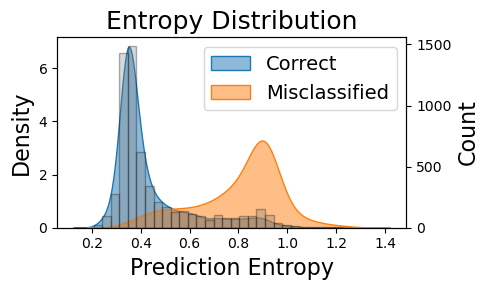

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot combined KDE and histogram
fig, ax1 = plt.subplots(figsize=(5, 3))

# KDE plots (density)
sns.kdeplot(entropies[correct_mask], label="Correct", fill=True, alpha=0.5, ax=ax1)
sns.kdeplot(entropies[mis_mask],   label="Misclassified", fill=True, alpha=0.5, ax=ax1)
ax1.set_xlabel("Prediction Entropy", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)
ax1.set_title("Entropy Distribution", fontsize=18)

# Secondary axis for histogram (counts)
ax2 = ax1.twinx()
bins = 30
ax2.hist(entropies, bins=bins, alpha=0.3, color='gray', edgecolor='black')
ax2.set_ylabel("Count", fontsize=16)

# Combined legend for the KDE curves
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right', fontsize=14)

fig.tight_layout()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Chosen entropy threshold T = 0.648


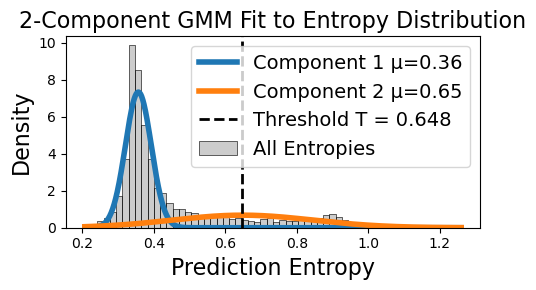

In [102]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) Load and preprocess augmented test set ────────────────────
base_dir = r"D:\PRISM"
test_pkl = os.path.join(base_dir, r"Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl")
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)
images = np.asarray(images, dtype=np.float32)
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X       = images[..., None]               # shape (N, 64, 36, 1)
y       = np.asarray(labels, dtype=int)  # 0=00,1=01,2=10,3=11

# ── 2) Stratified random sample of 10 000 examples ───────────────
rng = np.random.default_rng(seed=42)
sample_idx = []
n_per_class = 1500
for cls in range(4):
    cls_idx = np.where(y == cls)[0]
    sample_idx.append(rng.choice(cls_idx, size=n_per_class, replace=False))
sample_idx = np.concatenate(sample_idx)
rng.shuffle(sample_idx)

X_sel = X[sample_idx]
y_sel = y[sample_idx]

# ── 3) Load trained PRISM CNN ────────────────────────────────────
model_file = os.path.join(
    base_dir,
    r"PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"
)
model = tf.keras.models.load_model(model_file)

# ── 4) Compute softmax probabilities and entropies ───────────────
probs = model.predict(X_sel, batch_size=256, verbose=1)  # (10000, 4)
entropies = -np.sum(probs * np.log(probs + 1e-12), axis=1)

# ── 5) Fit 2-component GMM on the high-entropy tail ─────────────
mask_fit = entropies > 0.05
ent_fit  = entropies[mask_fit].reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
# sort by increasing mean
mus  = np.sort(gmm.means_.flatten())
sigs = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts  = gmm.weights_[np.argsort(gmm.means_.flatten())]

# threshold = mean of the higher-entropy component
T = mus[1]
print(f"Chosen entropy threshold T = {T:.3f}")

# ── 6) Plot histogram + GMM fits + threshold ────────────────────
x = np.linspace(entropies.min(), entropies.max(), 1000)
p1 = wts[0] * norm.pdf(x, mus[0], sigs[0])
p2 = wts[1] * norm.pdf(x, mus[1], sigs[1])

plt.figure(figsize=(5, 3))
sns.histplot(entropies, bins=60, stat="density",
             color="gray", alpha=0.4, label="All Entropies")
# sns.histplot(entropies[mask_fit], bins=60, stat="density",
#              color="orange", alpha=0.3, label="Fit subset (ent > 0.05)")

plt.plot(x, p1, c="C0", lw=4, label=f"Component 1 μ={mus[0]:.2f}")
plt.plot(x, p2, c="C1", lw=4, label=f"Component 2 μ={mus[1]:.2f}")

plt.axvline(T, ls="--", c="k", lw=2, label=f"Threshold T = {T:.3f}")

plt.xlabel("Prediction Entropy", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("2-Component GMM Fit to Entropy Distribution", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


⚠️ No GPU detected – using CPU

✅ Loaded model from D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
── Full Test Set ─────────────────────────────
 Class 0    Acc 100.00%   N=414
 Class 1    Acc 98.79%   N=414
 Class 2    Acc 96.14%   N=414
 Class 3    Acc 87.92%   N=414
 Overall Accuracy: 95.71%

── GMM: low-entropy mean m1=0.0119, high-entropy mean m2=0.2771
    → Using threshold T = m2 = 0.2771

── Accepted Samples Only (ent < m2) ───────────
 Class 0    Acc 100.00%   N=414
 Class 1    Acc 100.00%   N=382
 Class 2    Acc 99.65%   N=286
 Class 3    Acc 97.81%   N=228
 Overall Accuracy: 99.54%   Coverage: 79.11%



c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


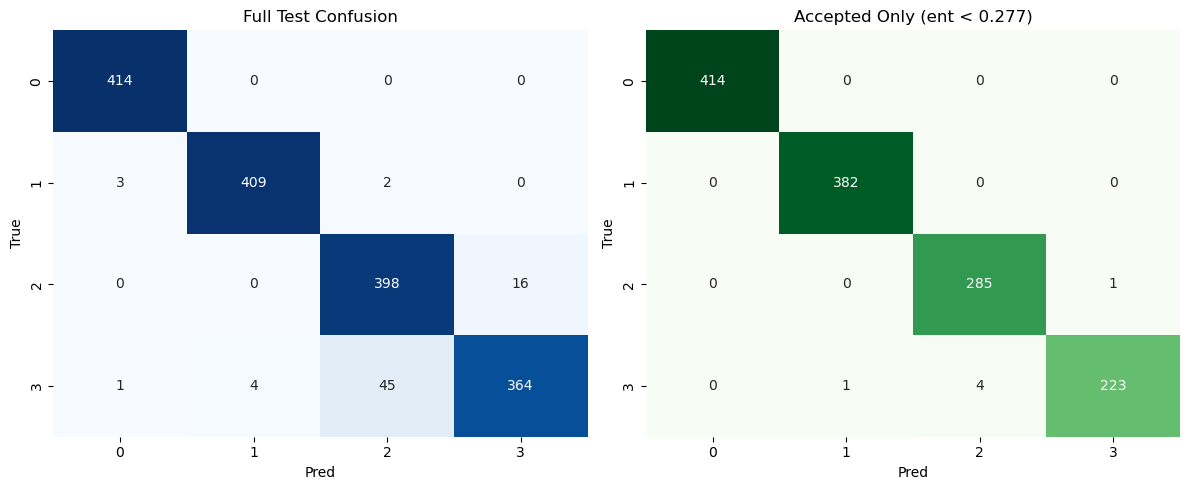

In [47]:
import os
import math
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# ── 0) GPU check (optional) ─────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ GPU detected: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected – using CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────────
BASE       = r"D:\PRISM"
TEST_PKL   = os.path.join(
    BASE,
    r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl"
)
MODEL_FILE = os.path.join(
    BASE,
    r"PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
)

# ── 2) Load test data ────────────────────────────────────────────────────
with open(TEST_PKL, "rb") as fh:
    images, labels = pickle.load(fh)

images = np.asarray(images, dtype=np.float32)      # (N,64,36)
labels = np.asarray(labels, dtype=np.int32)        # (N,)

# normalize exactly as during training
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]                         # (N,64,36,1)

# ── 3) Load model & predict ─────────────────────────────────────────────
model = tf.keras.models.load_model(MODEL_FILE)
print(f"\n✅ Loaded model from {MODEL_FILE}\n")

probs  = model.predict(X_test, verbose=1)    # (N,4) softmax outputs
y_pred = np.argmax(probs, axis=1)            # (N,)

# ── 4) Full-set accuracy & confusion ──────────────────────────────────
num_cls = len(np.unique(labels))
cm_full = np.zeros((num_cls, num_cls), dtype=int)
for t, p in zip(labels, y_pred):
    cm_full[t, p] += 1

acc_per_full = np.diag(cm_full) / cm_full.sum(axis=1) * 100
acc_ovr_full = np.trace(cm_full) / cm_full.sum() * 100

print("── Full Test Set ─────────────────────────────")
for c in range(num_cls):
    print(f" Class {c:<2}   Acc {acc_per_full[c]:5.2f}%   N={cm_full[c].sum()}")
print(f" Overall Accuracy: {acc_ovr_full:5.2f}%\n")

# ── 5) Compute per-sample entropy ───────────────────────────────────────
ent = -np.sum(probs * np.log(probs + 1e-12), axis=1)  # (N,)

# ── 6) Fit 2-component GMM on entropies ───────────────────────────────
ent_1d = ent.reshape(-1, 1)
gmm    = GaussianMixture(n_components=2, random_state=0).fit(ent_1d)

means = gmm.means_.flatten()
# sort so component 0 is lower-entropy cluster
m1, m2 = np.sort(means)

T_mean2 = m2
print(f"── GMM: low-entropy mean m1={m1:.4f}, high-entropy mean m2={m2:.4f}")
print(f"    → Using threshold T = m2 = {T_mean2:.4f}\n")

# ── 7) Apply threshold & recompute accuracy/confusion ────────────────
mask_accept = ent < T_mean2

cm_acc = np.zeros_like(cm_full)
for t, p, keep in zip(labels, y_pred, mask_accept):
    if keep:
        cm_acc[t, p] += 1

acc_per_acc = np.diag(cm_acc) / cm_acc.sum(axis=1) * 100
acc_ovr_acc = np.trace(cm_acc) / cm_acc.sum() * 100
cov_acc     = mask_accept.mean() * 100

print("── Accepted Samples Only (ent < m2) ───────────")
for c in range(num_cls):
    n_c = cm_acc[c].sum()
    print(f" Class {c:<2}   Acc {acc_per_acc[c]:5.2f}%   N={n_c}")
print(f" Overall Accuracy: {acc_ovr_acc:5.2f}%   Coverage: {cov_acc:5.2f}%\n")

# ── 8) Display both confusion matrices ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_full, annot=True, fmt="d", ax=axes[0], cmap="Blues",
            cbar=False)
axes[0].set(title="Full Test Confusion", xlabel="Pred", ylabel="True")

sns.heatmap(cm_acc, annot=True, fmt="d", ax=axes[1], cmap="Greens",
            cbar=False)
axes[1].set(title=f"Accepted Only (ent < {T_mean2:.3f})", xlabel="Pred", ylabel="True")

plt.tight_layout()
plt.show()


### (not used in the main report) Model 3

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

class L2NormLayer(layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
    def compute_output_shape(self, input_shape):
        return input_shape

# 0) (optional) distributed strategy
strategy = tf.distribute.MirroredStrategy()

# 1) Load your already-augmented training data
images, labels = pickle.load(open(
    r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl","rb"
))

# 2) Pre-process
X = np.array(images, dtype=np.float32)
X = (X - X.min()) / (X.max() - X.min() + 1e-8)
X = X[..., None]                       # → (N,64,36,1)
y = keras.utils.to_categorical(labels, num_classes=4)

with strategy.scope():
    inp = layers.Input((64, 36, 1), name="CHANNEL_IN")

    # Stage 1: 32 filters
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Stage 2: 64 filters
    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # One more conv for representation power
    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)

    # collapse H×W
    x = layers.GlobalAveragePooling2D()(x)

    # small head
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
        # … after your dropout …
    x = layers.Dropout(0.2)(x)

    # ─── NEW: L₂‐Normalize embedding ─────────────────────────────
    # this makes ‖x‖₂ = 1 for each sample, so the final dense layer
    # is just measuring cosine similarity (up to a scalar)
    x = L2NormLayer(name="embedding_l2_norm")(x)

    out = layers.Dense(4, activation="softmax", name="CHANNEL_OUT")(x)


    model = keras.Model(inp, out, name="small_channel_model")

    # optimizer + schedule
    epochs = 4
    batch_size = 60
    steps_per_epoch = int((0.8 * X.shape[0]) // batch_size)
    total_steps = steps_per_epoch * epochs

    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-3,
        first_decay_steps=total_steps,
        t_mul=2.0,
        m_mul=1.0,
        alpha=1e-4
    )
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4
    )

    # label smoothing
    loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["accuracy"]
    )

model.summary()

# 4) Train w/ checkpointing
checkpoint = ModelCheckpoint(
    filepath = r"D:\PRISM\PRISM_model\100xTraining\saved_model3"
               r"\test-202505151209-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor        = "val_accuracy",
    save_best_only = True,
    mode           = "max"
)

history = model.fit(
    x                = X,
    y                = y,
    batch_size       = batch_size,
    epochs           = epochs,
    validation_split = 0.2,
    shuffle          = True,
    callbacks        = [checkpoint]
)


### (not used in the main report) model4

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

# ─── 0) (optional) distributed strategy ───────────────────────────────
strategy = tf.distribute.MirroredStrategy()

# ─── 1) Custom Layers ────────────────────────────────────────────────

@tf.keras.utils.register_keras_serializable(package="Custom")
class InstanceNormalization(layers.Layer):
    """Per-sample, per-channel normalization (no batch stats)."""
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        _, _, _, C = input_shape
        self.gamma = self.add_weight(
            name="gamma", shape=(1, 1, C),
            initializer="ones", trainable=True
        )
        self.beta = self.add_weight(
            name="beta", shape=(1, 1, C),
            initializer="zeros", trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        # compute mean & var across H×W for each sample & channel
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(var + self.epsilon)
        x_norm = (x - mean) * inv
        return x_norm * self.gamma + self.beta


@tf.keras.utils.register_keras_serializable(package="Custom")
class MixStyle(layers.Layer):
    """
    MixStyle: randomly mixes feature‐map statistics within a batch 
    to simulate style/domain shifts.
    """
    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.p = p
        self.alpha = alpha
        self.eps = eps

    def build(self, input_shape):
        # no weights
        super().build(input_shape)

    def call(self, x, training=None):
        # x: [B, H, W, C]
        # 1) only apply when training and with probability p
        do_mix = tf.logical_and(
            tf.cast(training, tf.bool),
            tf.less(tf.random.uniform([], 0, 1), self.p)
        )

        def _mix():
            B = tf.shape(x)[0]
            # compute per-sample mean & std over H×W
            mu    = tf.reduce_mean(x, axis=[1,2], keepdims=True)
            var   = tf.reduce_mean((x - mu)**2, axis=[1,2], keepdims=True)
            sigma = tf.sqrt(var + self.eps)

            # shuffle within batch
            idx    = tf.random.shuffle(tf.range(B))
            mu2    = tf.gather(mu, idx)
            sigma2 = tf.gather(sigma, idx)

            # sample mixing coefficient λ ∈ (0,1)
            lam = tfp.distributions.Beta(self.alpha, self.alpha)\
                   .sample([B,1,1,1])

            # mix stats
            mu_mix    = lam * mu    + (1.0 - lam) * mu2
            sigma_mix = lam * sigma + (1.0 - lam) * sigma2

            # re-normalize
            x_norm = (x - mu) / sigma
            return x_norm * sigma_mix + mu_mix

        # choose branch
        return tf.cond(do_mix, _mix, lambda: x)

    def compute_output_shape(self, input_shape):
        # output has same shape as input
        return input_shape

    def get_config(self):
        return dict(p=self.p, alpha=self.alpha, eps=self.eps, **super().get_config())


@tf.keras.utils.register_keras_serializable(package="Custom")
class L2NormLayer(layers.Layer):
    """ℓ₂-normalize final embeddings."""
    def __init__(self, axis=1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
    def compute_output_shape(self, input_shape):
        return input_shape

# ─── 2) Load & preprocess ─────────────────────────────────────────────
images, labels = pickle.load(open(
    r"D:\PRISM\General_Test_PRISM\merged\CNN_dataset\real_and_synthetic_augumented.pkl","rb"
))
X = np.array(images, dtype=np.float32)
X = (X - X.min())/(X.max()-X.min()+1e-8)
X = X[...,None]       # (N,64,36,1)
y = keras.utils.to_categorical(labels, num_classes=4)

# ─── 3) Build model ─────────────────────────────────────────────────
with strategy.scope():
    inp = layers.Input((64,36,1), name="CHANNEL_IN")

    # Stage 1
    x = layers.Conv2D(32,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(inp)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(32,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MixStyle()(x, training=True)
    x = layers.MaxPooling2D()(x)

    # Stage 2
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MixStyle()(x, training=True)
    x = layers.MaxPooling2D()(x)

    # Stage 3
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)

    # pooling + head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
    x = layers.Dropout(0.2)(x)
    x = L2NormLayer(name="embedding_l2_norm")(x)

    out = layers.Dense(4, activation="softmax", name="CHANNEL_OUT")(x)

    model = keras.Model(inp, out, name="mixstyle_instancenorm_model")

    # compile (AdamW + cos-decay + label smoothing)
    epochs = 40
    batch_size = 60
    steps = int((0.8*X.shape[0])//batch_size)*epochs

    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-3,
        first_decay_steps=steps,
        t_mul=2.0,
        m_mul=1.0,
        alpha=1e-4
    )
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_sched,
        weight_decay=1e-4
    )
    loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

model.summary()

# ─── 4) Train w/ checkpointing ───────────────────────────────────────
ckpt = ModelCheckpoint(
    filepath = r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-generalisation88synth-20250516-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor        = "val_accuracy",
    save_best_only = True,
    mode           = "max"
)
history = model.fit(
    x               = X,
    y               = y,
    batch_size      = batch_size,
    epochs          = epochs,
    validation_split= 0.2,
    shuffle         = True,
    callbacks       = [ckpt]
)


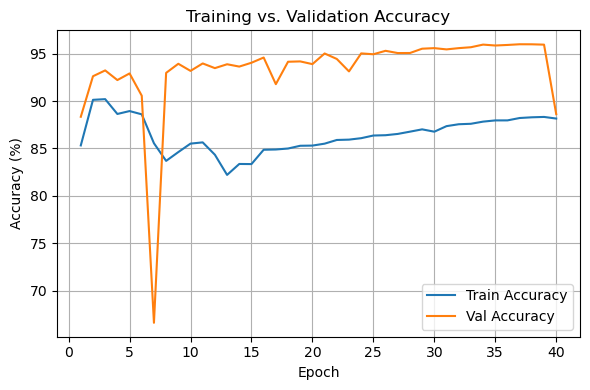

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(hist, metric="accuracy"):
    """
    Plot training & validation curves (in %) for `metric`.
    Works with a Keras History object.
    """
    epochs = range(1, len(hist.history[metric]) + 1)
    train = [v * 100 for v in hist.history[metric]]
    val   = [v * 100 for v in hist.history[f"val_{metric}"]]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label=f"Train {metric.capitalize()}")
    plt.plot(epochs, val,   label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{metric.capitalize()} (%)")
    plt.title(f"Training vs. Validation {metric.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call it (rename `history` if your variable is different)
plot_training_curves(history, metric="accuracy")


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


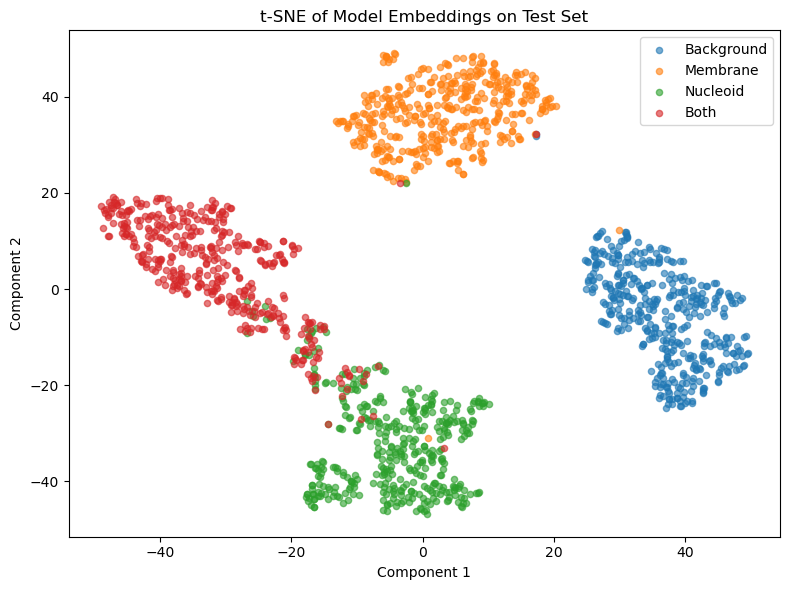

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ── 1) Load test set ───────────────────────────────────────────
base_dir = r"D:\PRISM"
test_pkl = os.path.join(base_dir, r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl")
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)
images = np.asarray(images, dtype=np.float32)
images = (images - images.min()) / (images.max() - images.min() + 1e-8)
X_test = images[..., None]  # (N,64,36,1)

# ── 2) Load trained model ─────────────────────────────────────
# model_file = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_model3\smallet-202505141639-39-0.96.keras")

# model = tf.keras.models.load_model(model_file)

# ── 3) Extract embedding layer output ─────────────────────────
# If you have an L2-normalization layer named "embedding_l2_norm", use it; otherwise use the penultimate Dense.
try:
    embedding_layer = model.get_layer("embedding_l2_norm")
except ValueError:
    # fallback: the layer before softmax (penultimate)
    embedding_layer = model.layers[-2]
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings = embedding_model.predict(X_test, verbose=1)

# ── 4) Run t-SNE ───────────────────────────────────────────────
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d = tsne.fit_transform(embeddings)

# ── 5) Plot ───────────────────────────────────────────────────
label_names = {0: "Background", 1: "Membrane", 2: "Nucleoid", 3: "Both"}
plt.figure(figsize=(8, 6))
for cls in np.unique(labels):
    mask = labels == cls
    plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=label_names[cls], alpha=0.6, s=20)
plt.title("t-SNE of Model Embeddings on Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()


### (not used in the main report) Model 5: use NLMeans denoising

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

# ─── 0) (optional) distributed strategy ───────────────────────────────
strategy = tf.distribute.MirroredStrategy()

# ─── 1) Custom Layers ────────────────────────────────────────────────

@tf.keras.utils.register_keras_serializable(package="Custom")
class InstanceNormalization(layers.Layer):
    """Per-sample, per-channel normalization (no batch stats)."""
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        _, _, _, C = input_shape
        self.gamma = self.add_weight(
            name="gamma", shape=(1, 1, C),
            initializer="ones", trainable=True
        )
        self.beta = self.add_weight(
            name="beta", shape=(1, 1, C),
            initializer="zeros", trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        # compute mean & var across H×W for each sample & channel
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(var + self.epsilon)
        x_norm = (x - mean) * inv
        return x_norm * self.gamma + self.beta


@tf.keras.utils.register_keras_serializable(package="Custom")
class MixStyle(layers.Layer):
    """
    MixStyle: randomly mixes feature‐map statistics within a batch 
    to simulate style/domain shifts.
    """
    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.p = p
        self.alpha = alpha
        self.eps = eps

    def build(self, input_shape):
        # no weights
        super().build(input_shape)

    def call(self, x, training=None):
        # x: [B, H, W, C]
        # 1) only apply when training and with probability p
        do_mix = tf.logical_and(
            tf.cast(training, tf.bool),
            tf.less(tf.random.uniform([], 0, 1), self.p)
        )

        def _mix():
            B = tf.shape(x)[0]
            # compute per-sample mean & std over H×W
            mu    = tf.reduce_mean(x, axis=[1,2], keepdims=True)
            var   = tf.reduce_mean((x - mu)**2, axis=[1,2], keepdims=True)
            sigma = tf.sqrt(var + self.eps)

            # shuffle within batch
            idx    = tf.random.shuffle(tf.range(B))
            mu2    = tf.gather(mu, idx)
            sigma2 = tf.gather(sigma, idx)

            # sample mixing coefficient λ ∈ (0,1)
            lam = tfp.distributions.Beta(self.alpha, self.alpha)\
                   .sample([B,1,1,1])

            # mix stats
            mu_mix    = lam * mu    + (1.0 - lam) * mu2
            sigma_mix = lam * sigma + (1.0 - lam) * sigma2

            # re-normalize
            x_norm = (x - mu) / sigma
            return x_norm * sigma_mix + mu_mix

        # choose branch
        return tf.cond(do_mix, _mix, lambda: x)

    def compute_output_shape(self, input_shape):
        # output has same shape as input
        return input_shape

    def get_config(self):
        return dict(p=self.p, alpha=self.alpha, eps=self.eps, **super().get_config())


@tf.keras.utils.register_keras_serializable(package="Custom")
class L2NormLayer(layers.Layer):
    """ℓ₂-normalize final embeddings."""
    def __init__(self, axis=1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
    def compute_output_shape(self, input_shape):
        return input_shape

import cv2

# ─── 2) Load & preprocess ─────────────────────────────────────────────
images, labels = pickle.load(open(
    r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_augmented.pkl","rb"
))
X = np.array(images, dtype=np.float32)
X = (X - X.min())/(X.max()-X.min()+1e-8)
X = X[...,None]       # shape (N,64,36,1)

# ─── 2.1) Denoise each image with Non‐Local‐Means ──────────────────────
# convert to uint8, apply fastNlMeansDenoising, then back to float32 [0,1]
X_uint8 = (X[...,0] * 255).astype(np.uint8)            # (N,64,36)
X_dn   = np.empty_like(X[...,0], dtype=np.float32)

for i in range(X_uint8.shape[0]):
    img    = X_uint8[i]
    denoised_uint8 = cv2.fastNlMeansDenoising(
        img,
        None,
        h=10,
        templateWindowSize=6,
        searchWindowSize=21
    )
    X_dn[i] = denoised_uint8.astype(np.float32) / 255.0

X = X_dn[...,None]  # back to (N,64,36,1)

y = keras.utils.to_categorical(labels, num_classes=4)


# ─── 3) Build model ─────────────────────────────────────────────────
with strategy.scope():
    inp = layers.Input((64,36,1), name="CHANNEL_IN")

    # Stage 1
    x = layers.Conv2D(32,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(inp)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(32,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MixStyle()(x, training=True)
    x = layers.MaxPooling2D()(x)

    # Stage 2
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MixStyle()(x, training=True)
    x = layers.MaxPooling2D()(x)

    # Stage 3
    x = layers.Conv2D(64,3,padding="same",kernel_initializer="he_normal",
                      kernel_regularizer=l2(1e-3))(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)

    # pooling + head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
    x = layers.Dropout(0.2)(x)
    x = L2NormLayer(name="embedding_l2_norm")(x)

    out = layers.Dense(4, activation="softmax", name="CHANNEL_OUT")(x)

    model = keras.Model(inp, out, name="mixstyle_instancenorm_model")

    # compile (AdamW + cos-decay + label smoothing)
    epochs = 30
    batch_size = 80
    steps = int((0.8*X.shape[0])//batch_size)*epochs

    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-3,
        first_decay_steps=steps,
        t_mul=2.0,
        m_mul=1.0,
        alpha=1e-4
    )
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_sched,
        weight_decay=1e-4
    )
    loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

model.summary()

# ─── 4) Train w/ checkpointing ───────────────────────────────────────
ckpt = ModelCheckpoint(
    filepath = r"D:\PRISM\PRISM_model\100xTraining\saved_model5\LNMean-synthovernight-20250515-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor        = "val_accuracy",
    save_best_only = True,
    mode           = "max"
)
history = model.fit(
    x               = X,
    y               = y,
    batch_size      = batch_size,
    epochs          = epochs,
    validation_split= 0.2,
    shuffle         = True,
    callbacks       = [ckpt]
)


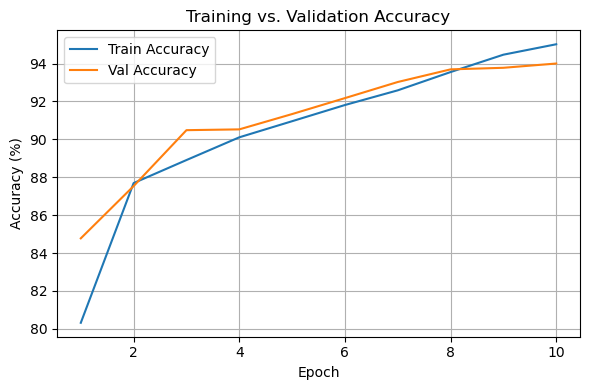

In [52]:
import matplotlib.pyplot as plt

def plot_training_curves(hist, metric="accuracy"):
    """
    Plot training & validation curves (in %) for `metric`.
    Works with a Keras History object.
    """
    epochs = range(1, len(hist.history[metric]) + 1)
    train = [v * 100 for v in hist.history[metric]]
    val   = [v * 100 for v in hist.history[f"val_{metric}"]]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label=f"Train {metric.capitalize()}")
    plt.plot(epochs, val,   label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{metric.capitalize()} (%)")
    plt.title(f"Training vs. Validation {metric.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call it (rename `history` if your variable is different)
plot_training_curves(history, metric="accuracy")


⚠️  No GPU detected – running on CPU

✅  Model loaded from: D:\PRISM\PRISM_model\100xTraining\saved_model5\LNMean-202505152024-10-0.94.keras 

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
──── Classification report ────
Class          Acc (%)     Support
Background      100.00         365
Membrane         99.45         365
Nucleoid         93.42         365
Both             92.05         365

Overall accuracy: 96.23% (N=1460)


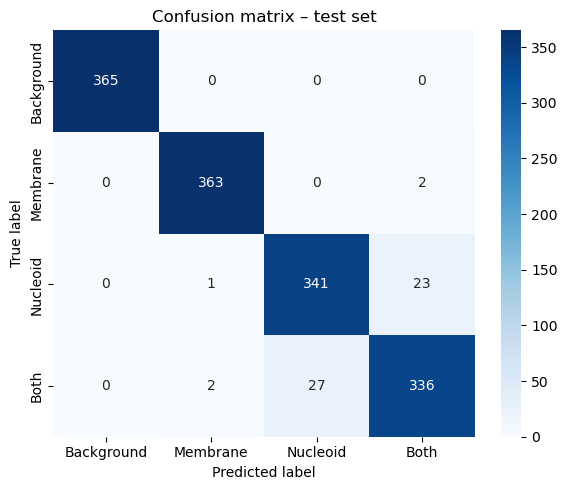

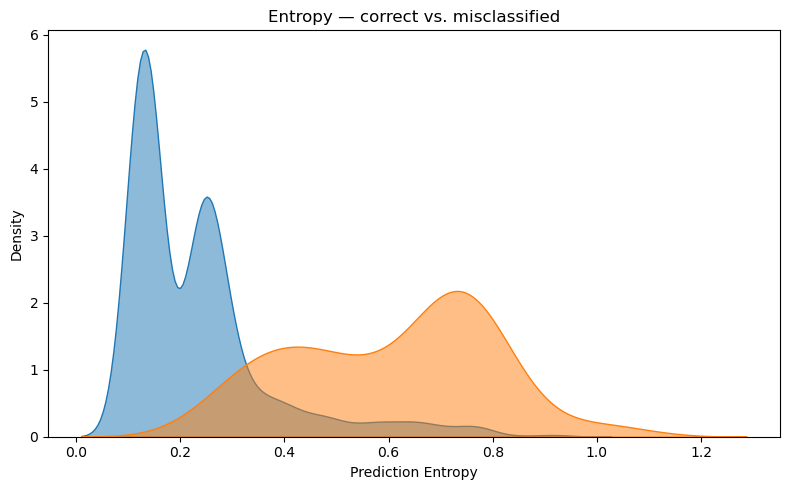

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


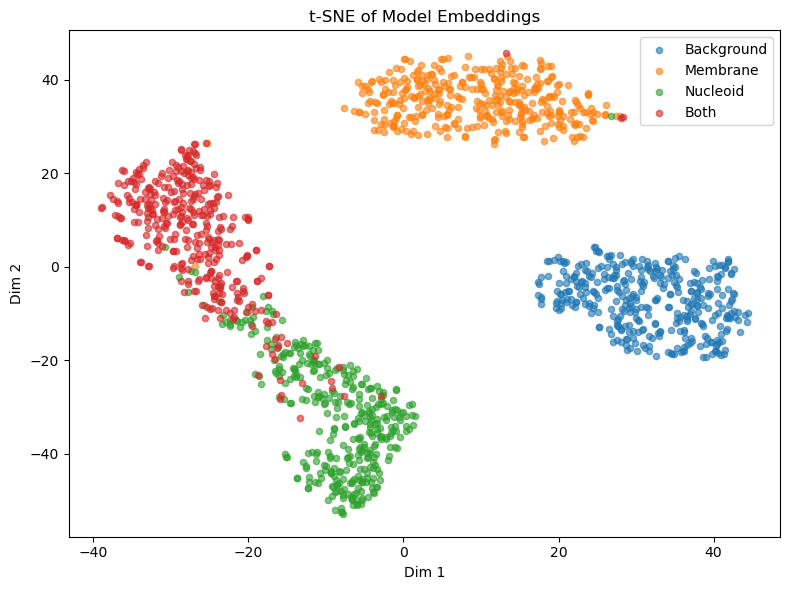

In [7]:
import os, pickle, itertools
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# ── 0) GPU check (optional) ───────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅  Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected – running on CPU")

# ── 1) Paths ───────────────────────────────────────────────────────────
base_dir   = r"D:\PRISM"
test_pkl   = os.path.join(base_dir,
    r"Mother Cell For PRISM Train\merged\CNN_dataset\test.pkl")
model_file = os.path.join(base_dir,
    r"D:\PRISM\PRISM_model\100xTraining\saved_model5\LNMean-202505152024-10-0.94.keras")

# ── 2) Load & normalize ────────────────────────────────────────────────
with open(test_pkl, "rb") as fh:
    images, labels = pickle.load(fh)
images = np.asarray(images, dtype=np.float32)    # (N,64,36)
labels = np.asarray(labels, dtype=np.int32)      # (N,)
images = (images - images.min())/(images.max()-images.min()+1e-8)

# ── 2.1) NLMeans denoising per‐image ──────────────────────────────────
# convert to uint8 [0–255], apply NLMeans, back to float32 [0–1]
X_uint8 = (images * 255).astype(np.uint8)        # (N,64,36)
X_dn    = np.empty_like(images, dtype=np.float32)
for i in range(images.shape[0]):
    img_uint8 = X_uint8[i]
    denoised  = cv2.fastNlMeansDenoising(
                    img_uint8,
                    None,
                    h=10,
                    templateWindowSize=6,
                    searchWindowSize=21
                )
    X_dn[i] = denoised.astype(np.float32) / 255.0

# add channel axis
X_test = X_dn[..., None]                         # (N,64,36,1)

# ── 3) Load model ─────────────────────────────────────────────────────
model = tf.keras.models.load_model(
    model_file,
    custom_objects={
      "InstanceNormalization": InstanceNormalization,
      "MixStyle": MixStyle,
      "L2NormLayer": L2NormLayer
    }
)
print("\n✅  Model loaded from:", model_file, "\n")

# ── 4) Predict & build confusion matrix ───────────────────────────────
pred_logits = model.predict(X_test, verbose=1)
y_pred      = np.argmax(pred_logits, axis=1)

num_classes = len(np.unique(labels))
conf_mat    = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(labels, y_pred):
    conf_mat[t, p] += 1

per_class_acc = (np.diag(conf_mat) / conf_mat.sum(axis=1)) * 100
overall_acc   = np.trace(conf_mat) / np.sum(conf_mat) * 100

# ── 5) Print report ───────────────────────────────────────────────────
label_names = {0:"Background",1:"Membrane",2:"Nucleoid",3:"Both"}
print("──── Classification report ────")
print(f"{'Class':<12}{'Acc (%)':>10}{'Support':>12}")
for cls in range(num_classes):
    sup = conf_mat[cls].sum()
    print(f"{label_names[cls]:<12}{per_class_acc[cls]:>10.2f}{sup:>12}")
print(f"\nOverall accuracy: {overall_acc:.2f}% (N={len(labels)})")

# ── 6) Plot confusion matrix ─────────────────────────────────────────
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=[label_names[i] for i in range(num_classes)],
            yticklabels=[label_names[i] for i in range(num_classes)],
            cmap="Blues")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.title("Confusion matrix – test set"); plt.tight_layout()
plt.show()

# ── 7) Entropy distributions ─────────────────────────────────────────
probs = pred_logits
entropies = -np.sum(probs * np.log(probs + 1e-12), axis=1)
correct = (y_pred == labels)
plt.figure(figsize=(8,5))
sns.kdeplot(entropies[correct], label="Correct", fill=True, alpha=0.5)
sns.kdeplot(entropies[~correct], label="Misclassified", fill=True, alpha=0.5)
plt.xlabel("Prediction Entropy"); plt.ylabel("Density")
plt.title("Entropy — correct vs. misclassified"); plt.tight_layout()
plt.show()

# ── 8) t-SNE of embeddings ────────────────────────────────────────────
# extract penultimate (or L2 norm) layer
try:
    emb_layer = model.get_layer("embedding_l2_norm")
except ValueError:
    emb_layer = model.layers[-2]
emb_mod  = Model(model.input, emb_layer.output)
embs     = emb_mod.predict(X_test, verbose=1)
emb2d    = TSNE(n_components=2, random_state=42,
                init='pca', learning_rate='auto').fit_transform(embs)

plt.figure(figsize=(8,6))
for cls in np.unique(labels):
    m = labels==cls
    plt.scatter(emb2d[m,0], emb2d[m,1], label=label_names[cls], alpha=0.6, s=20)
plt.title("t-SNE of Model Embeddings"); plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(); plt.tight_layout(); plt.show()


# PRISM Setup 1 and 2: Test 16 barcode training accuracy

## (not used in the main report) Model 1

⚠️ No GPU detected — running on CPU

✅ Loaded model from: D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505141809-synth-08-1.00.keras

────── Barcode decoding accuracy ──────
 Overall: 39.38%  (N = 1803)

Barcode  Acc (%)  Support
 0000       0.00        0
 0001      87.02      131
 0010       0.00      105
 0011      58.90      146
 0100      86.29      124
 0101      82.99      147
 0110       0.00       75
 0111      56.52       23
 1000       2.33      129
 1001       1.89       53
 1010       0.00       51
 1011       1.82      165
 1100      33.50      197
 1101      50.90      167
 1110       1.65      121
 1111      63.91      169


C:\Users\kastu\AppData\Local\Temp\ipykernel_131268\1094737937.py:110: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # shape (16, 16)


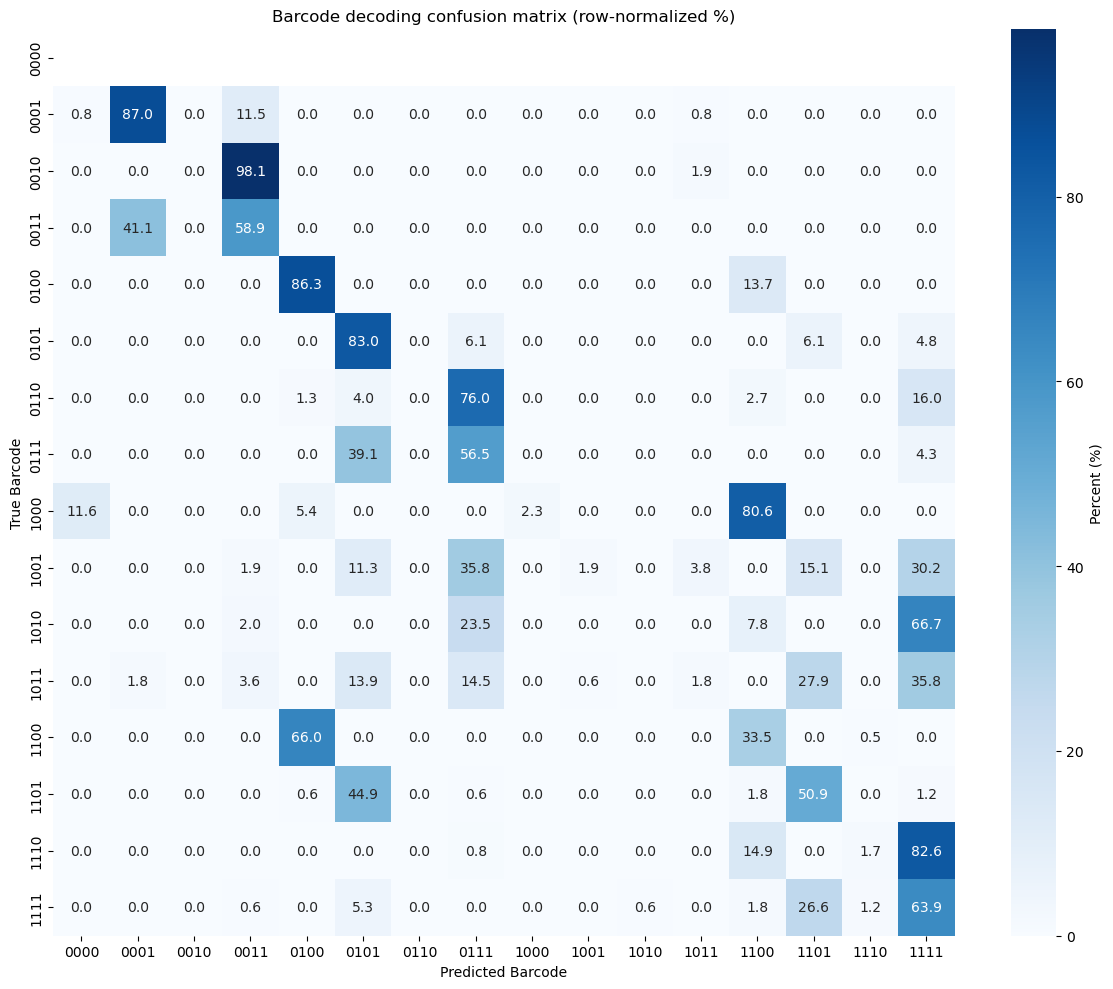

In [15]:
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU setup (optional) ─────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected — running on CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────
BASE        = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS   = os.path.join(BASE, "test_sets")
#MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras"
MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505141809-synth-08-1.00.keras"
# ── 2) Load the trained channel classifier ────────────────────────────
model = tf.keras.models.load_model(MODEL_FILE)
print(f"\n✅ Loaded model from: {MODEL_FILE}\n")

# ── 3) Helper: map channel‐label → 2-bit code ─────────────────────────
code_map = {
    0: "00",  # background
    1: "10",  # membrane
    2: "01",  # nucleoid
    3: "11",  # both
}

# ── 4) Iterate test_sets and predict barcodes ────────────────────────
true_bcs = []
pred_bcs = []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue
    bc_true = fn[:4]  # e.g. "0010"
    path = os.path.join(TEST_SETS, fn)
    z = zarr.open(path, mode="r")

    # assume z["bfp"] & z["rfp"] have shape (n_cells, H, W)
    bfp_stack = z["bfp"][...]
    rfp_stack = z["rfp"][...]

    n = bfp_stack.shape[0]
    for i in range(n):
        # per‐image normalization
        b = bfp_stack[i].astype(np.float32)
        b = (b - b.min()) / (b.ptp() + 1e-8)
        r = rfp_stack[i].astype(np.float32)
        r = (r - r.min()) / (r.ptp() + 1e-8)

        # add batch & channel dims
        xb = b[None, ..., None]
        xr = r[None, ..., None]

        # predict
        pb = model.predict(xb, verbose=0)
        pr = model.predict(xr, verbose=0)
        lb = int(np.argmax(pb, axis=1)[0])
        lr = int(np.argmax(pr, axis=1)[0])

        bc_pred = code_map[lb] + code_map[lr]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)

# ── 5) Compute overall & per-barcode accuracy ────────────────────────
true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)
all_bcs  = sorted(set(true_bcs) | set(pred_bcs))  # include all barcodes

# overall
overall_acc = np.mean(true_bcs == pred_bcs) * 100

# per‐barcode
per_acc = {}
support = {}
for bc in all_bcs:
    idx = np.where(true_bcs == bc)[0]
    support[bc] = len(idx)
    per_acc[bc] = np.mean(pred_bcs[idx] == bc) * 100 if len(idx) > 0 else 0

# ── 6) Build confusion matrix ────────────────────────────────────────
bc_to_idx = {bc:i for i, bc in enumerate(all_bcs)}
cm = np.zeros((len(all_bcs), len(all_bcs)), dtype=int)
for t, p in zip(true_bcs, pred_bcs):
    i, j = bc_to_idx[t], bc_to_idx[p]
    cm[i,j] += 1


# ── 7) Print report ─────────────────────────────────────────────────
print("────── Barcode decoding accuracy ──────")
print(f" Overall: {overall_acc:.2f}%  (N = {len(true_bcs)})\n")
print(f"{'Barcode':<6} {'Acc (%)':>8} {'Support':>8}")
for bc in sorted(all_bcs):
    print(f" {bc:<6} {per_acc[bc]:>8.2f} {support[bc]:>8}")

# ── 8) Plot confusion matrix ────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ── Normalize confusion matrix row-wise (so each row sums to 100%) ──
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # shape (16, 16)

# ── Plot confusion matrix ─────────────────────────────────────────────
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_percent,
    annot=True, fmt=".1f",
    xticklabels=all_bcs,
    yticklabels=all_bcs,
    cmap="Blues",
    cbar_kws={"label": "Percent (%)"}
)
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode decoding confusion matrix (row-normalized %)")
plt.tight_layout()
plt.show()


⚠️  No GPU detected — running on CPU


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



📏  GMM (fit on ent>0.05) → μ₁=0.107, μ₂=0.457  ⇒  T = 0.457

── BEFORE rejection ─────────────────────────
 Overall accuracy: 89.45%  (N=1659)
 0001: 98.47%
 0010: 93.33%
 0011: 71.92%
 0100: 99.19%
 0101: 78.23%
 0110: 77.27%
 0111: 100.00%
 1000: 99.22%
 1001: 86.67%
 1010: 93.33%
 1011: 81.82%
 1100: 86.80%
 1101: 92.81%
 1110: 95.04%
 1111: 94.67%

── AFTER rejection (kept 86.0% of cells) ─────────
 Overall accuracy: 94.39%  (N=1426)
 0001: 100.00%
 0010: 97.94%
 0011: 78.30%
 0100: 99.15%
 0101: 87.85%
 0110: 83.33%
 0111: 100.00%
 1000: 100.00%
 1001: 100.00%
 1010: 100.00%
 1011: 92.06%
 1100: 90.91%
 1101: 95.89%
 1110: 97.37%
 1111: 97.39%


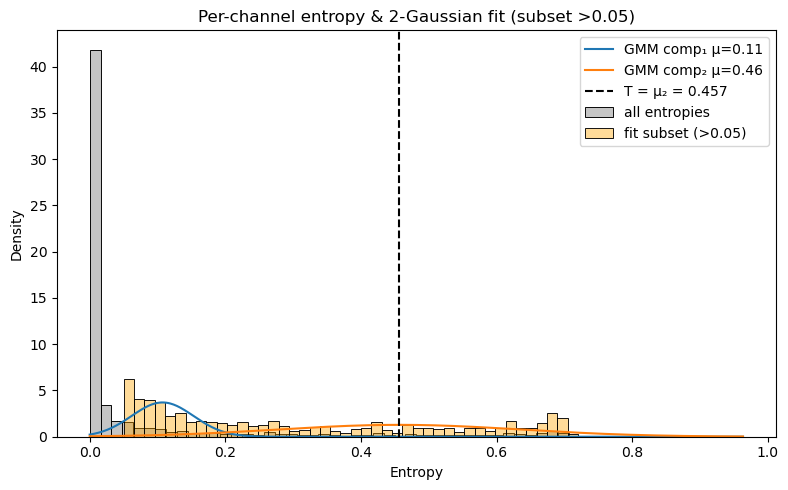

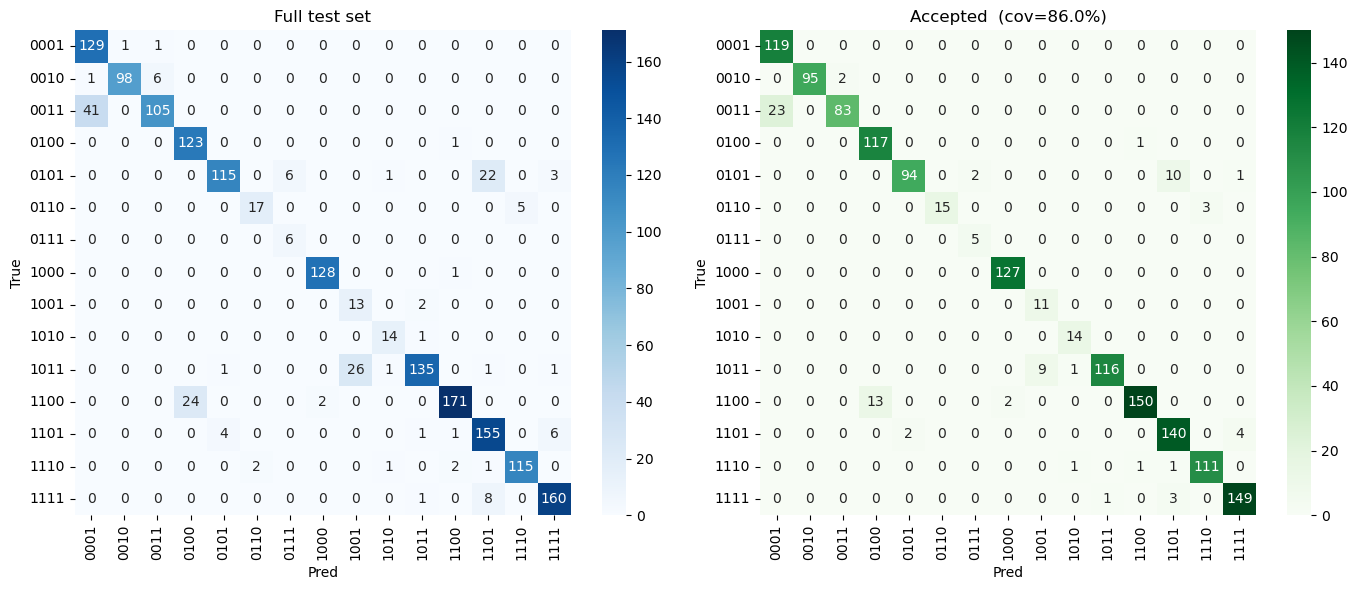

In [64]:
# entropy threshold
# entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
MODEL_FILE = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras"

model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()


I can see that 11 is often predicted 01 and sometimes the other way around

⚠️ No GPU detected — running on CPU

✅ Loaded model from: D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras

────── Barcode decoding accuracy ──────
 Overall: 89.75%  (N = 1659)

Barcode  Acc (%)  Support
 0001      96.18      131
 0010      90.48      105
 0011      72.60      146
 0100      99.19      124
 0101      78.91      147
 0110      86.36       22
 0111      83.33        6
 1000     100.00      129
 1001      93.33       15
 1010     100.00       15
 1011      81.82      165
 1100      88.32      197
 1101      94.01      167
 1110      95.87      121
 1111      94.08      169


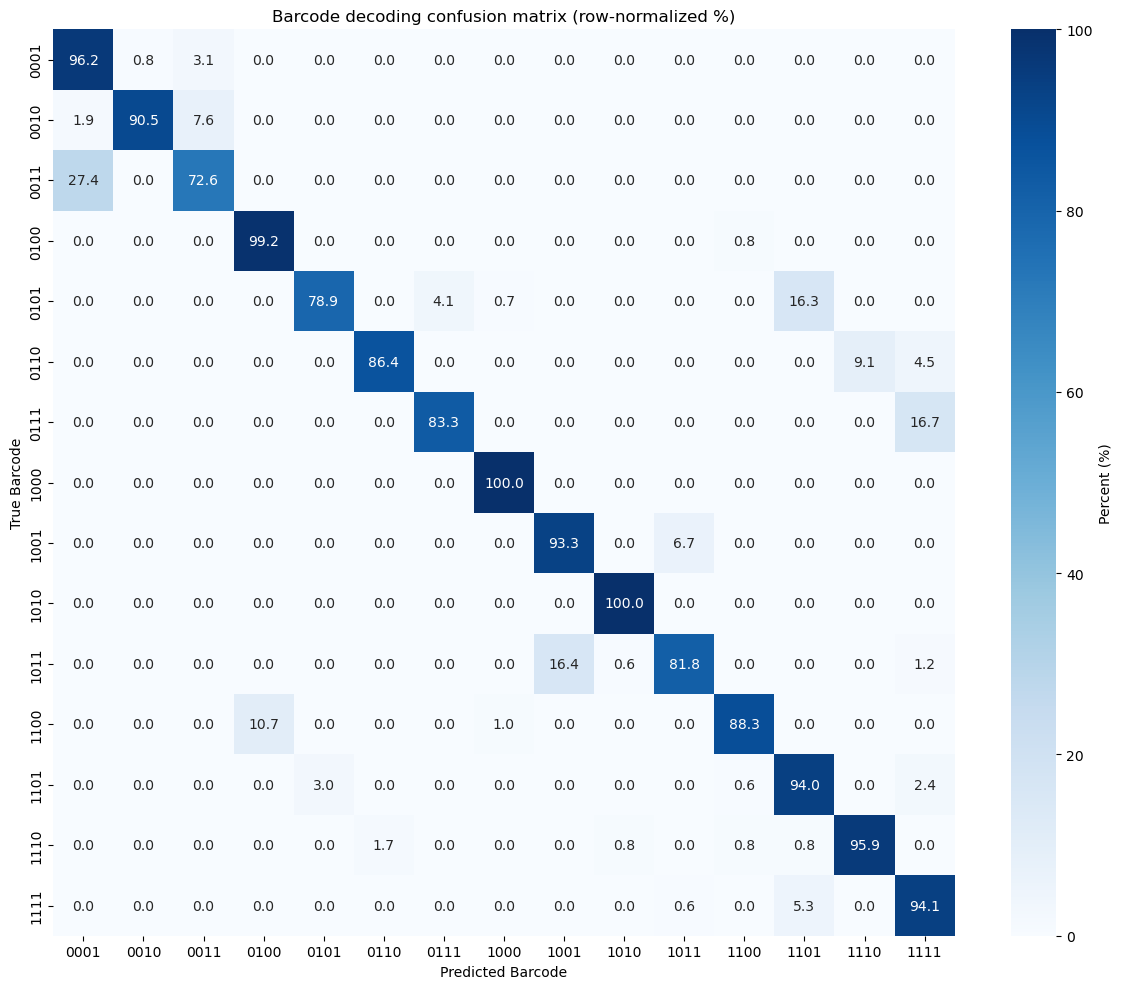

In [29]:
# majority vote
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ─── 0) GPU setup ────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected — running on CPU")

# ─── 1) Paths ─────────────────────────────────────────────────
BASE        = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS   = os.path.join(BASE, "test_sets")
MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras"
# ─── 2) Load your trained channel_model ───────────────────────
model = tf.keras.models.load_model(MODEL_FILE)
print(f"\n✅ Loaded model from: {MODEL_FILE}\n")

# ─── 3) Code map for bits ─────────────────────────────────────
code_map = {
    0: "00",  # background → "00"
    1: "10",  # membrane   → "10"
    2: "01",  # nucleoid   → "01"
    3: "11",  # both       → "11"
}

# ─── 4) Augmentation helpers ──────────────────────────────────
def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min())/(img.ptp()+1e-8)

def augment_five(x):
    """
    Given a 2D array x, return list of 5 augmentations:
      0° rot, 90° rot, 180° rot, 270° rot, and horizontal flip of 0°.
    """
    rots = [np.rot90(x, k) for k in (0,1,2,3)]
    flip = np.fliplr(rots[0])
    return rots + [flip]

# ─── 5) Loop over test sets and majority‐vote predict ──────────
true_bcs = []
pred_bcs = []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue
    bc_true = fn[:4]  # e.g. "0011"
    path    = os.path.join(TEST_SETS, fn)
    z       = zarr.open(path, mode="r")

    # stacks: shape (n_cells, H, W)
    bfp_stack = z["bfp"][...]
    rfp_stack = z["rfp"][...]

    for i in range(bfp_stack.shape[0]):
        # normalize single‐cell images
        b0 = normalize(bfp_stack[i])
        r0 = normalize(rfp_stack[i])

        # build 5 augmentations each
        bs = augment_five(b0)
        rs = augment_five(r0)

        # collect bit‐votes
        b_votes = []
        r_votes = []

        for b_aug, r_aug in zip(bs, rs):
            # add batch & channel dims
            xb = b_aug[None, ..., None]
            xr = r_aug[None, ..., None]

            # predict softmax logits
            pb = model.predict(xb, verbose=0)[0]
            pr = model.predict(xr, verbose=0)[0]

            lb = int(np.argmax(pb))
            lr = int(np.argmax(pr))

            b_votes.append(lb)
            r_votes.append(lr)

        # majority vote on each bit
        lb_final = max(set(b_votes), key=b_votes.count)
        lr_final = max(set(r_votes), key=r_votes.count)

        bc_pred = code_map[lb_final] + code_map[lr_final]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)

# ─── 6) Compute accuracy & per‐barcode stats ───────────────────
true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)
all_bcs  = sorted(set(true_bcs) | set(pred_bcs))

overall_acc = (true_bcs == pred_bcs).mean() * 100

per_acc = {}
support = {}
for bc in all_bcs:
    idx = np.where(true_bcs == bc)[0]
    support[bc] = len(idx)
    per_acc[bc] = (pred_bcs[idx] == bc).mean() * 100 if len(idx) else 0

print("────── Barcode decoding accuracy ──────")
print(f" Overall: {overall_acc:.2f}%  (N = {len(true_bcs)})\n")
print(f"{'Barcode':<6} {'Acc (%)':>8} {'Support':>8}")
for bc in all_bcs:
    print(f" {bc:<6} {per_acc[bc]:>8.2f} {support[bc]:>8}")

# ─── 7) Confusion matrix (row‐normalized %) ─────────────────────
bc_to_idx = {bc:i for i, bc in enumerate(all_bcs)}
cm = np.zeros((len(all_bcs), len(all_bcs)), dtype=int)
for t,p in zip(true_bcs, pred_bcs):
    i,j = bc_to_idx[t], bc_to_idx[p]
    cm[i,j] += 1

cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(12,10))
sns.heatmap(
    cm_pct,
    annot=True, fmt=".1f",
    xticklabels=all_bcs,
    yticklabels=all_bcs,
    cmap="Blues",
    cbar_kws={"label":"Percent (%)"}
)
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode decoding confusion matrix (row-normalized %)")
plt.tight_layout()
plt.show()


## PRISM CNN Model setup 1 and 2

⚠️ No GPU detected — running on CPU


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(



✅ Loaded model from: D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model-21-epoch-validacc-0.99.hdf5

────── Barcode decoding accuracy ──────
 Overall: 40.42%   (N = 2358)

Barcode Acc (%)   Support
 0000    100.00       150
 0001     92.53       174
 0010     38.57       140
 0011      4.64       194
 0100     98.19       166
 0101     89.80       196
 0110     77.78        27
 0111     11.11         9
 1000     70.35       172
 1001     58.82        17
 1010     80.00        20
 1011      1.82       220
 1100      4.56       263
 1101      4.04       223
 1110     24.69       162
 1111      2.67       225


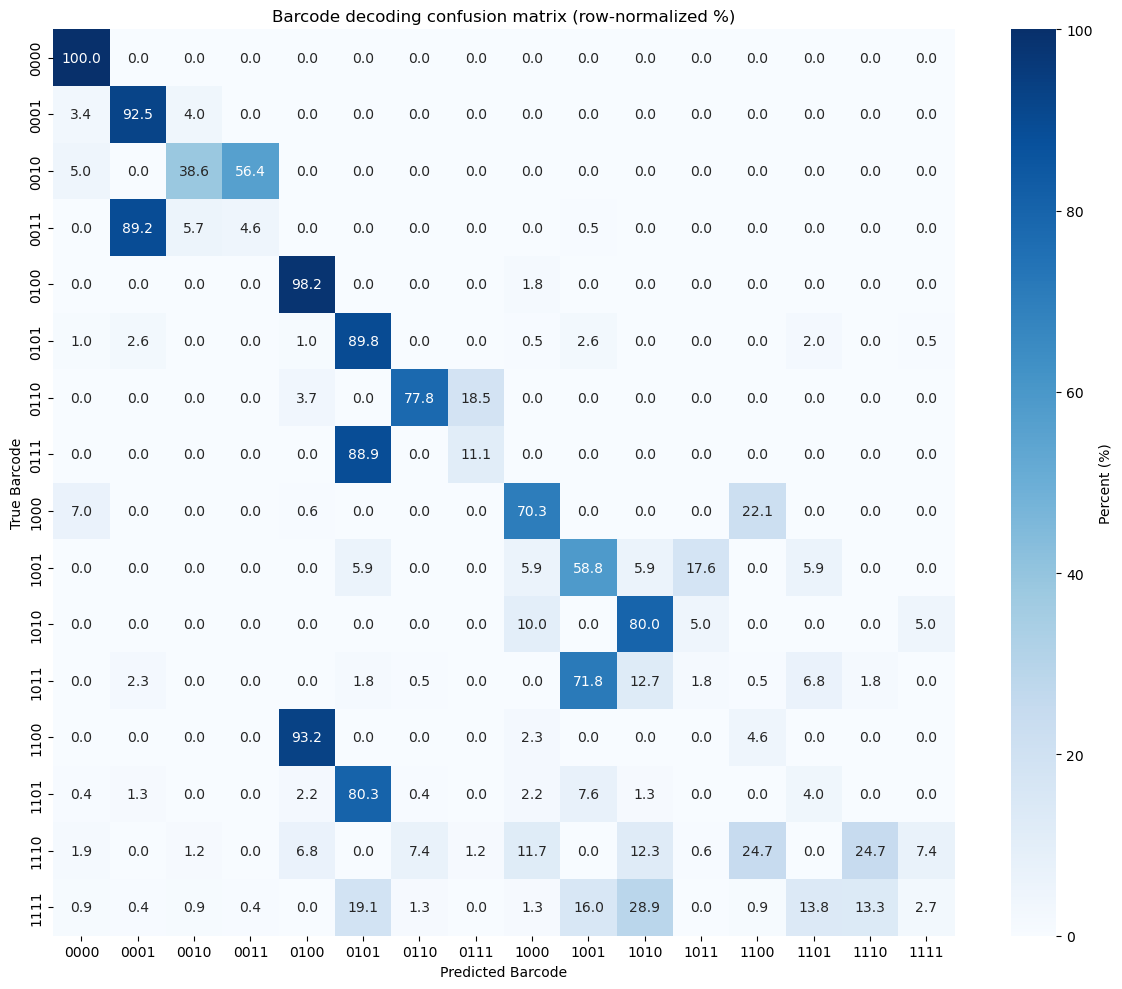

In [ ]:
# Accuracy of rui's model without retraining
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU setup (optional) ─────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected — running on CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────
BASE        = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS   = os.path.join(BASE, "test_sets")
#MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\synthetic-202505152320‐16-0.98.keras")
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\synthetic-overnight-20250515‐38-0.99.keras")
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\allbarcodetrain-20250516‐35-0.92.keras")

# MODEL_FILE   = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"

#model from Rui
MODEL_FILE   = r"D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model-21-epoch-validacc-0.99.hdf5"
# ── 2) Load the trained channel classifier ────────────────────────────
model = tf.keras.models.load_model(MODEL_FILE)
print(f"\n✅ Loaded model from: {MODEL_FILE}\n")
# ── 3) map channel-label → 2-bit code ─────────────────────────────────
code_map = {
    0: "00",  # background
    1: "10",  # membrane
    2: "01",  # nucleoid
    3: "11",  # both
}

# ── 4) iterate and predict ────────────────────────────────────────────
true_bcs, pred_bcs = [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue

    bc_true = fn[:4]  # e.g. "0000", "0010", ...
    path = os.path.join(TEST_SETS, fn)
    z = zarr.open(path, mode="r")

    # make sure we always have both channels as arrays,
    # even if one channel is missing, treat as all-zero (pure background)
    def load_channel(stack_name):
        if stack_name in z.array_keys():
            arr = z[stack_name][...].astype(np.float32)
        else:
            # no such channel → pure background
            n = z[next(iter(z.array_keys()))].shape[0]
            arr = np.zeros((n, *z[next(iter(z.array_keys()))].shape[1:]), dtype=np.float32)
        # normalize per cell
        arr = (arr - arr.min(axis=(1,2), keepdims=True)) / (
            arr.ptp(axis=(1,2), keepdims=True) + 1e-8
        )
        return arr

    bfp_stack = load_channel("bfp")
    rfp_stack = load_channel("rfp")

    n = bfp_stack.shape[0]
    for i in range(n):
        xb = bfp_stack[i][None, ..., None]
        xr = rfp_stack[i][None, ..., None]

        pb = model.predict(xb, verbose=0)[0]
        pr = model.predict(xr, verbose=0)[0]

        lb = int(np.argmax(pb))
        lr = int(np.argmax(pr))

        bc_pred = code_map[lb] + code_map[lr]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)

true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)

# make sure '0000' is included even if it never occurred
all_bcs = sorted(set(true_bcs) | set(pred_bcs) | {"0000"})

# overall
overall_acc = 100 * np.mean(true_bcs == pred_bcs)

# per-barcode
per_acc, support = {}, {}
for bc in all_bcs:
    idx = np.where(true_bcs == bc)[0]
    support[bc] = len(idx)
    per_acc[bc] = 100 * np.mean(pred_bcs[idx] == bc) if idx.size else 0.0

# build confusion
bc_to_idx = {bc: i for i, bc in enumerate(all_bcs)}
cm = np.zeros((len(all_bcs), len(all_bcs)), int)
for t, p in zip(true_bcs, pred_bcs):
    cm[bc_to_idx[t], bc_to_idx[p]] += 1

# ── report ────────────────────────────────────────────────────────────
print("────── Barcode decoding accuracy ──────")
print(f" Overall: {overall_acc:.2f}%   (N = {len(true_bcs)})\n")
print(f"{'Barcode':<6}{'Acc (%)':>8}{'Support':>10}")
for bc in all_bcs:
    print(f" {bc:<6}{per_acc[bc]:>8.2f}{support[bc]:>10}")

# ── plot confusion matrix ─────────────────────────────────────────────
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(12,10))
sns.heatmap(
    cm_percent, annot=True, fmt=".1f", cmap="Blues",
    xticklabels=all_bcs, yticklabels=all_bcs,
    cbar_kws={"label":"Percent (%)"}
)
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode decoding confusion matrix (row-normalized %)")
plt.tight_layout()
plt.show()

### result of setup 1

Barcode  |  Accuracy (%)  |  Support
-----------------------------------
 0000         100.00         150
 0001          95.40         174
 0010          97.86         140
 0011          78.87         194
 0100          96.39         166
 0101          80.61         196
 0110          85.19          27
 0111         100.00           9
 1000          98.84         172
 1001          94.12          17
 1010         100.00          20
 1011          81.82         220
 1100          85.17         263
 1101          94.62         223
 1110          98.15         162
 1111          94.22         225


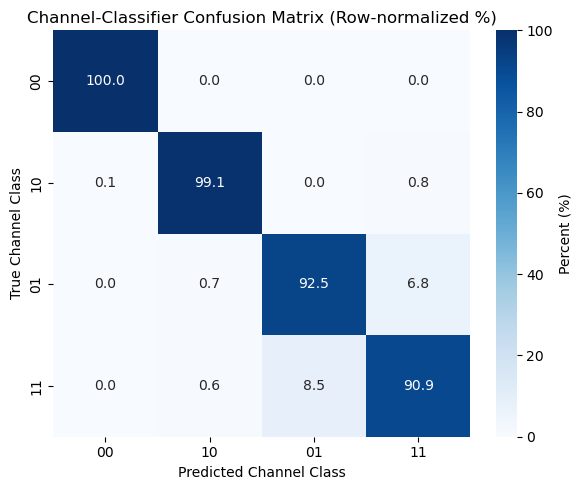

In [ ]:
# Result of Setup 1
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

# ── Setup ──────────────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)

# Paths
BASE      = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS = os.path.join(BASE, "test_sets")
MODEL_FILE = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"

# Load model
model = tf.keras.models.load_model(MODEL_FILE)

# Map model output index → 2‐bit code
code_map = {0:"00", 1:"10", 2:"01", 3:"11"}
inv_code_map = {v:k for k,v in code_map.items()}

# ── Gather true & predicted barcodes, and per‐channel labels ────────────
true_bcs, pred_bcs = [], []
true_labels, pred_labels = [], []  # for channel confusion

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue

    bc_true = fn[:4]
    z = zarr.open(os.path.join(TEST_SETS, fn), mode="r")

    # helper to load & normalize channel stack
    def load_channel(name):
        if name in z.array_keys():
            arr = z[name][...].astype(np.float32)
        else:
            # missing channel → all zeros
            n, h, w = z[next(iter(z.array_keys()))].shape
            arr = np.zeros((n,h,w), np.float32)
        # per‐cell normalization
        mn = arr.min(axis=(1,2), keepdims=True)
        ptp = arr.ptp(axis=(1,2), keepdims=True) + 1e-8
        return (arr - mn) / ptp

    bfp = load_channel("bfp")
    rfp = load_channel("rfp")

    for stack, channel_code in [(bfp, bc_true[:2]), (rfp, bc_true[2:])]:
        # run channel‐wise predictions
        for img, true_code in zip(stack, [channel_code]*stack.shape[0]):
            x = img[None,...,None]
            pred = model.predict(x, verbose=0)[0]
            pred_label = np.argmax(pred)
            true_label = inv_code_map[true_code]
            true_labels.append(true_label)
            pred_labels.append(pred_label)

    # full‐barcode prediction
    for i in range(bfp.shape[0]):
        lb = np.argmax(model.predict(bfp[i][None,...,None], verbose=0)[0])
        lr = np.argmax(model.predict(rfp[i][None,...,None], verbose=0)[0])
        pred_bcs.append(code_map[lb]+code_map[lr])
        true_bcs.append(bc_true)

true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)

# ── Per‐barcode accuracy & support table ───────────────────────────────
all_bcs = sorted(set(true_bcs) | set(pred_bcs))
support = {bc: np.sum(true_bcs==bc) for bc in all_bcs}
accuracy = {bc: 100*np.mean(pred_bcs[true_bcs==bc]==bc) for bc in all_bcs}

print("Barcode  |  Accuracy (%)  |  Support")
print("-----------------------------------")
for bc in all_bcs:
    print(f" {bc}     {accuracy[bc]:>10.2f}      {support[bc]:>6d}")

# ── 4×4 Confusion Matrix for channel‐classifier ────────────────────────
labels = ["00","10","01","11"]
cm = confusion_matrix(true_labels, pred_labels, labels=[0,1,2,3])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label":"Percent (%)"})
plt.xlabel("Predicted Channel Class")
plt.ylabel("True Channel Class")
plt.title("Channel‐Classifier Confusion Matrix (Row‐normalized %)")
plt.tight_layout()
plt.show()


Barcode  |  Accuracy (%)  |  Support
-----------------------------------
 0000         100.00         150
 0001          95.40         174
 0010          97.86         140
 0011          78.87         194
 0100          96.39         166
 0101          80.61         196
 0110          85.19          27
 0111         100.00           9
 1000          98.84         172
 1001          94.12          17
 1010         100.00          20
 1011          81.82         220
 1100          85.17         263
 1101          94.62         223
 1110          98.15         162
 1111          94.22         225


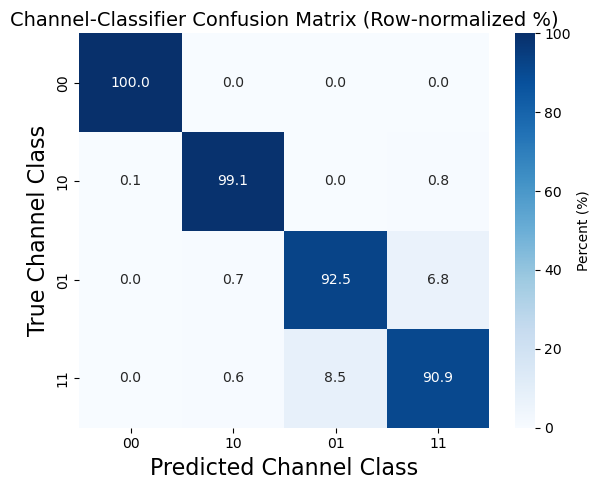

In [10]:
# ── Per‐barcode accuracy & support table ───────────────────────────────
all_bcs = sorted(set(true_bcs) | set(pred_bcs))
support = {bc: np.sum(true_bcs==bc) for bc in all_bcs}
accuracy = {bc: 100*np.mean(pred_bcs[true_bcs==bc]==bc) for bc in all_bcs}

print("Barcode  |  Accuracy (%)  |  Support")
print("-----------------------------------")
for bc in all_bcs:
    print(f" {bc}     {accuracy[bc]:>10.2f}      {support[bc]:>6d}")

# ── 4×4 Confusion Matrix for channel‐classifier ────────────────────────
labels = ["00","10","01","11"]
cm = confusion_matrix(true_labels, pred_labels, labels=[0,1,2,3])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label":"Percent (%)"})
plt.xlabel("Predicted Channel Class", fontsize=16)
plt.ylabel("True Channel Class", fontsize=16)
plt.title("Channel‐Classifier Confusion Matrix (Row‐normalized %)", fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
# … after computing true_bcs and pred_bcs …

# Overall accuracy
overall_acc = 100 * np.mean(true_bcs == pred_bcs)
print(f"Overall barcode accuracy: {overall_acc:.2f}%")

# Then your per-barcode table
all_bcs = sorted(set(true_bcs) | set(pred_bcs))
support = {bc: np.sum(true_bcs == bc) for bc in all_bcs}
accuracy = {bc: 100 * np.mean(pred_bcs[true_bcs == bc] == bc) for bc in all_bcs}

print("\nBarcode  |  Accuracy (%)  |  Support")
print("-----------------------------------")
for bc in all_bcs:
    print(f" {bc:<4}   {accuracy[bc]:>8.2f}   {support[bc]:>8d}")


Overall barcode accuracy: 91.09%

Barcode  |  Accuracy (%)  |  Support
-----------------------------------
 0000     100.00        150
 0001      95.40        174
 0010      97.86        140
 0011      78.87        194
 0100      96.39        166
 0101      80.61        196
 0110      85.19         27
 0111     100.00          9
 1000      98.84        172
 1001      94.12         17
 1010     100.00         20
 1011      81.82        220
 1100      85.17        263
 1101      94.62        223
 1110      98.15        162
 1111      94.22        225


Entropy reject threshold T = 0.634


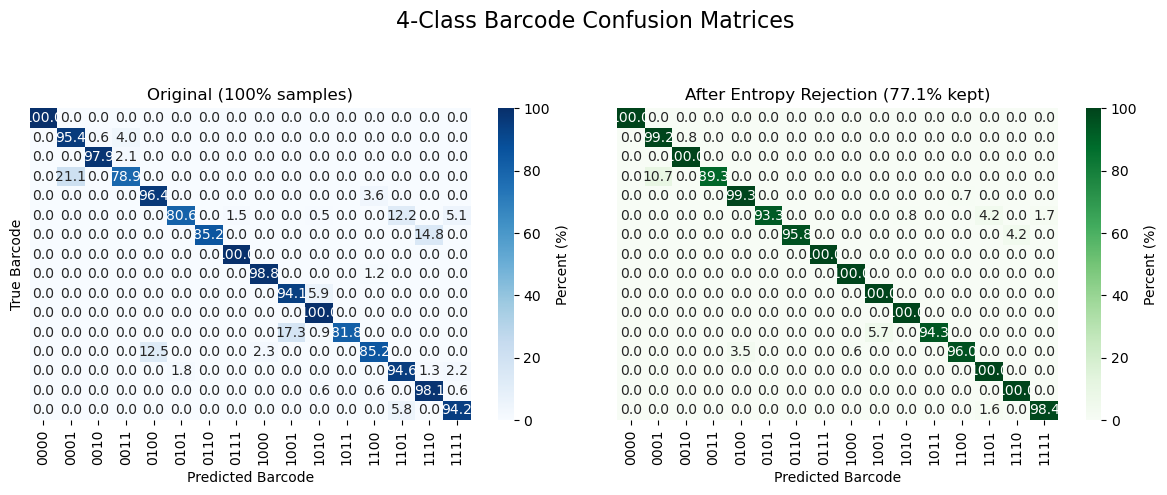

In [104]:
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

# ── 1) GPU setup ─────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)

# ── 2) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
MODEL_FILE = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"
model      = tf.keras.models.load_model(MODEL_FILE)

# ── 3) Code maps ─────────────────────────────────────────────────────
# index→2-bit, then full 4-bit is BFP2bit + RFP2bit
code_map     = {0:"00", 1:"10", 2:"01", 3:"11"}

# ── 4) Collect true vs. predicted barcodes, per-channel entropies ───
true_bcs, pred_bcs = [], []
ent_b_list, ent_r_list = [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue
    bc_true = fn[:4]                             # e.g. "0010"
    z = zarr.open(os.path.join(TEST_SETS, fn), mode="r")

    def norm_chan(arr):
        mn  = arr.min(axis=(1,2), keepdims=True)
        ptp = arr.ptp(axis=(1,2), keepdims=True) + 1e-8
        return (arr - mn) / ptp

    bfp = norm_chan(z["bfp"][...].astype(np.float32))
    rfp = norm_chan(z["rfp"][...].astype(np.float32))

    for b_img, r_img in zip(bfp, rfp):
        # BFP prediction + entropy
        pb = model.predict(b_img[None,...,None], verbose=0)[0]
        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        lb    = np.argmax(pb)
        # RFP prediction + entropy
        pr = model.predict(r_img[None,...,None], verbose=0)[0]
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        lr    = np.argmax(pr)

        true_bcs.append(bc_true)
        pred_bcs.append(code_map[lb] + code_map[lr])
        ent_b_list.append(ent_b)
        ent_r_list.append(ent_r)

true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)
ent_b    = np.array(ent_b_list)
ent_r    = np.array(ent_r_list)

# ── 5) Fit 2-GMM on all channel entropies >0.05 to get threshold T ───
all_ent  = np.concatenate([ent_b, ent_r])
mask_fit = all_ent > 0.05
gmm      = GaussianMixture(n_components=2, random_state=0).fit(all_ent[mask_fit].reshape(-1,1))
mus      = np.sort(gmm.means_.flatten())
T        = mus[1]
print(f"Entropy reject threshold T = {T:.3f}")

# ── 6) Build keep-mask: both channels below T ────────────────────────
keep_mask = (ent_b < T) & (ent_r < T)
coverage  = keep_mask.mean() * 100

# ── 7) Confusion matrices for full 4-bit barcodes ───────────────────
# derive labels from the data itself
bc_labels = sorted(set(true_bcs))  # e.g. ['0000','0001',...]
# original
cm_full      = confusion_matrix(true_bcs, pred_bcs, labels=bc_labels)
cm_full_pct  = cm_full.astype(float) / cm_full.sum(axis=1, keepdims=True) * 100
# after rejection
cm_keep      = confusion_matrix(true_bcs[keep_mask], pred_bcs[keep_mask], labels=bc_labels)
cm_keep_pct  = cm_keep.astype(float) / cm_keep.sum(axis=1, keepdims=True) * 100

# ── 8) Plot side-by-side heatmaps ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.heatmap(cm_full_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=bc_labels, yticklabels=bc_labels,
            cbar_kws={"label":"Percent (%)"}, ax=axes[0])
axes[0].set(title="Original (100% samples)",
            xlabel="Predicted Barcode", ylabel="True Barcode")

sns.heatmap(cm_keep_pct, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=bc_labels, yticklabels=[],
            cbar_kws={"label":"Percent (%)"}, ax=axes[1])
axes[1].set(title=f"After Entropy Rejection ({coverage:.1f}% kept)",
            xlabel="Predicted Barcode")

plt.suptitle("4-Class Barcode Confusion Matrices", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()


Entropy rejection threshold T = 0.634

Rejected samples per class:
 00: 32 / 1409 (2.3%)
 10: 37 / 778 (4.8%)
 01: 171 / 1008 (17.0%)
 11: 333 / 1521 (21.9%)

Overall accuracy (no rejection):     95.31%
Overall accuracy (after rejection):  98.77%  (87.8% of samples kept)


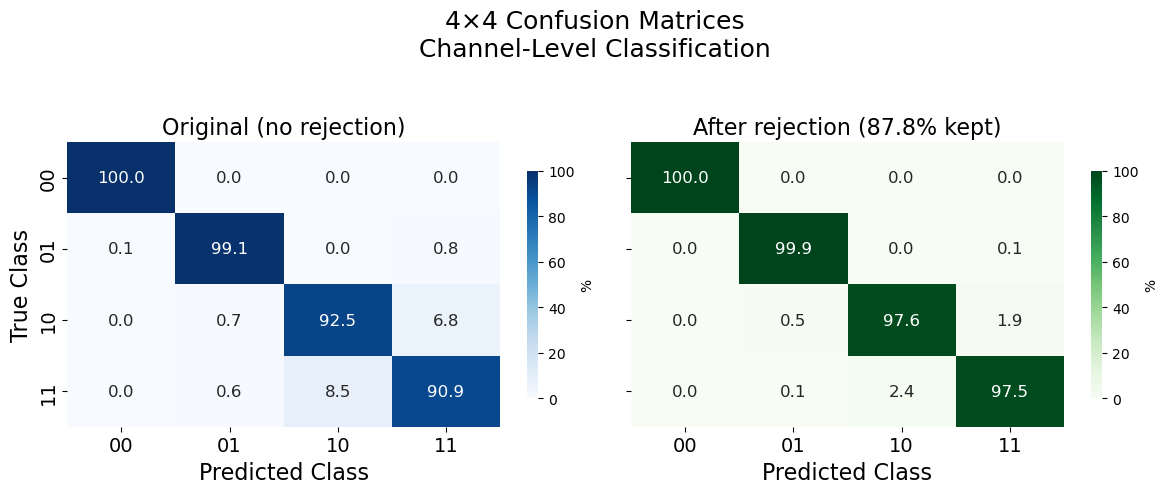

In [12]:
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.mixture import GaussianMixture
from collections import Counter

# ── 1) GPU setup ─────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)

# ── 2) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
MODEL_FILE = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"
model      = tf.keras.models.load_model(MODEL_FILE)

# ── 3) Label mappings ───────────────────────────────────────────────
code_map     = {0:"00", 1:"10", 2:"01", 3:"11"}  # index → 2-bit code
inv_code_map = {v:k for k,v in code_map.items()} # 2-bit code → index

# ── 4) Normalization helper ────────────────────────────────────────
def normalize_stack(arr):
    mn  = arr.min(axis=(1,2), keepdims=True)
    ptp = arr.ptp(axis=(1,2), keepdims=True) + 1e-8
    return (arr - mn) / ptp

# ── 5) Collect channel-level true labels, predictions, entropies ───
true_labels, pred_labels, entropies = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue
    z    = zarr.open(os.path.join(TEST_SETS, fn), mode="r")
    bfp  = normalize_stack(z["bfp"][...].astype(np.float32))
    rfp  = normalize_stack(z["rfp"][...].astype(np.float32))
    true_b, true_r = fn[:2], fn[2:4]

    # iterate BFP then RFP channel
    for stack, true_code in [(bfp, true_b), (rfp, true_r)]:
        t_int = inv_code_map[true_code]
        for img in stack:
            p      = model.predict(img[None,...,None], verbose=0)[0]
            pred_i = np.argmax(p)
            ent    = -np.sum(p * np.log(p + 1e-12))
            true_labels.append(t_int)
            pred_labels.append(pred_i)
            entropies.append(ent)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
entropies   = np.array(entropies)

# ── 6) Fit 2-component GMM on high-entropy tail to get threshold ────
mask_fit = entropies > 0.05
gmm      = GaussianMixture(n_components=2, random_state=0)
gmm.fit(entropies[mask_fit].reshape(-1,1))
mus      = np.sort(gmm.means_.flatten())
T        = mus[1]
print(f"Entropy rejection threshold T = {T:.3f}")

# ── 7) Build keep-mask & compute coverage ──────────────────────────
mask_keep = entropies < T
coverage  = mask_keep.mean() * 100

# ── 8) Count rejections per class ──────────────────────────────────
labels_int    = [0,1,2,3]
label_codes   = [code_map[i] for i in labels_int]
total_counts  = Counter(true_labels)
kept_counts   = Counter(true_labels[mask_keep])
rejected_per  = {i: total_counts[i] - kept_counts.get(i,0) for i in labels_int}

print("\nRejected samples per class:")
for i in labels_int:
    tot = total_counts[i]
    rej = rejected_per[i]
    pct = 100*rej/tot if tot>0 else 0
    print(f" {label_codes[i]}: {rej} / {tot} ({pct:.1f}%)")

# ── 9) Compute overall accuracies ──────────────────────────────────
acc_all  = accuracy_score(true_labels, pred_labels) * 100
acc_keep = accuracy_score(true_labels[mask_keep], pred_labels[mask_keep]) * 100
print(f"\nOverall accuracy (no rejection):     {acc_all:.2f}%")
print(f"Overall accuracy (after rejection):  {acc_keep:.2f}%  ({coverage:.1f}% of samples kept)")

# ── 10) Confusion matrices (row-normalized %) ──────────────────────
cm_full     = confusion_matrix(true_labels, pred_labels, labels=labels_int)
cm_full_pct = cm_full.astype(float) / cm_full.sum(axis=1, keepdims=True) * 100

cm_keep     = confusion_matrix(true_labels[mask_keep], pred_labels[mask_keep], labels=labels_int)
cm_keep_pct = cm_keep.astype(float) / cm_keep.sum(axis=1, keepdims=True) * 100

# ── 11) Plot side-by-side 4×4 heatmaps with distinct colormaps ──────
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# font sizes
fa, ft, fl = 12, 14, 16  # annot, ticks, labels
label_codes = ["00", "01", "10", "11"]

# First: original in blue
sns.heatmap(cm_full_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=label_codes, yticklabels=label_codes,
            annot_kws={"size":fa}, cbar_kws={"label":"%", "shrink":0.8},
            ax=axes[0])
axes[0].set_title("Original (no rejection)", fontsize=fl)
axes[0].set_xlabel("Predicted Class", fontsize=fl)
axes[0].set_ylabel("True Class", fontsize=fl)
axes[0].tick_params(labelsize=ft)

# Second: after rejection in green
sns.heatmap(cm_keep_pct, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=label_codes, yticklabels=label_codes,
            annot_kws={"size":fa}, cbar_kws={"label":"%", "shrink":0.8},
            ax=axes[1])
axes[1].set_title(f"After rejection ({coverage:.1f}% kept)", fontsize=fl)
axes[1].set_xlabel("Predicted Class", fontsize=fl)
axes[1].tick_params(labelsize=ft)

plt.suptitle("4×4 Confusion Matrices\nChannel‐Level Classification", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()




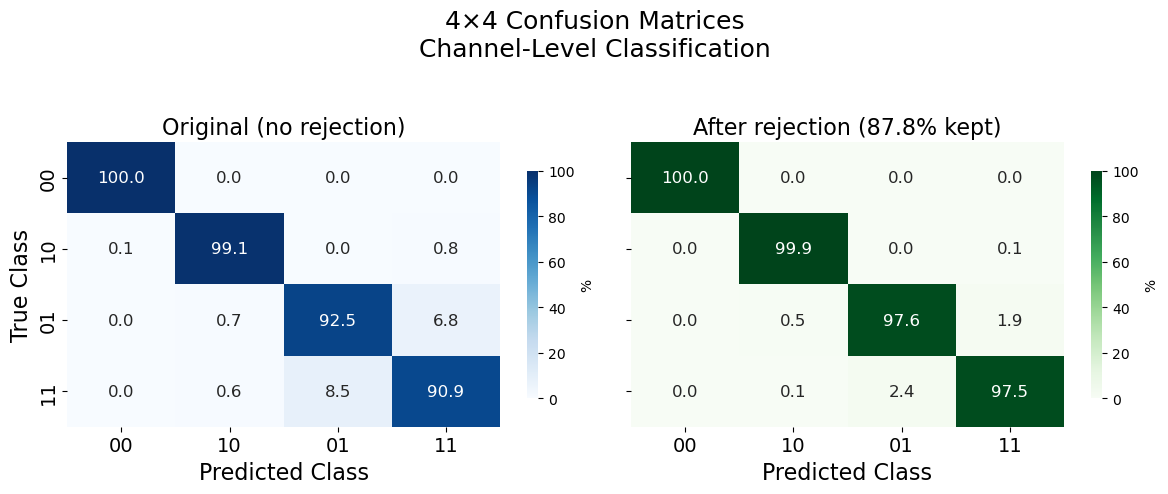

In [13]:
# ── 11) Plot side-by-side 4×4 heatmaps with distinct colormaps ──────
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# font sizes
fa, ft, fl = 12, 14, 16  # annot, ticks, labels
label_codes = ["00", "10", "01", "11"]

# First: original in blue
sns.heatmap(cm_full_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=label_codes, yticklabels=label_codes,
            annot_kws={"size":fa}, cbar_kws={"label":"%", "shrink":0.8},
            ax=axes[0])
axes[0].set_title("Original (no rejection)", fontsize=fl)
axes[0].set_xlabel("Predicted Class", fontsize=fl)
axes[0].set_ylabel("True Class", fontsize=fl)
axes[0].tick_params(labelsize=ft)

# Second: after rejection in green
sns.heatmap(cm_keep_pct, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=label_codes, yticklabels=label_codes,
            annot_kws={"size":fa}, cbar_kws={"label":"%", "shrink":0.8},
            ax=axes[1])
axes[1].set_title(f"After rejection ({coverage:.1f}% kept)", fontsize=fl)
axes[1].set_xlabel("Predicted Class", fontsize=fl)
axes[1].tick_params(labelsize=ft)

plt.suptitle("4×4 Confusion Matrices\nChannel‐Level Classification", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### Result of Setup 2 with rejection

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.360, μ₂=0.634  ⇒  T = 0.634

── BEFORE rejection ─────────────────────────
 Overall accuracy: 91.09%  (N=2358)
 0000: 100.00%
 0001: 95.40%
 0010: 97.86%
 0011: 78.87%
 0100: 96.39%
 0101: 80.61%
 0110: 85.19%
 0111: 100.00%
 1000: 98.84%
 1001: 94.12%
 1010: 100.00%
 1011: 81.82%
 1100: 85.17%
 1101: 94.62%
 1110: 98.15%
 1111: 94.22%

── AFTER rejection (kept 77.1% of cells) ─────────
 Overall accuracy: 97.80%  (N=1817)
 0000: 100.00%
 0001: 99.22%
 0010: 100.00%
 0011: 89.32%
 0100: 99.33%
 0101: 93.33%
 0110: 95.83%
 0111: 100.00%
 1000: 100.00%
 1001: 100.00%
 1010: 100.00%
 1011: 94.33%
 1100: 95.95%
 1101: 100.00%
 1110: 100.00%
 1111: 98.44%


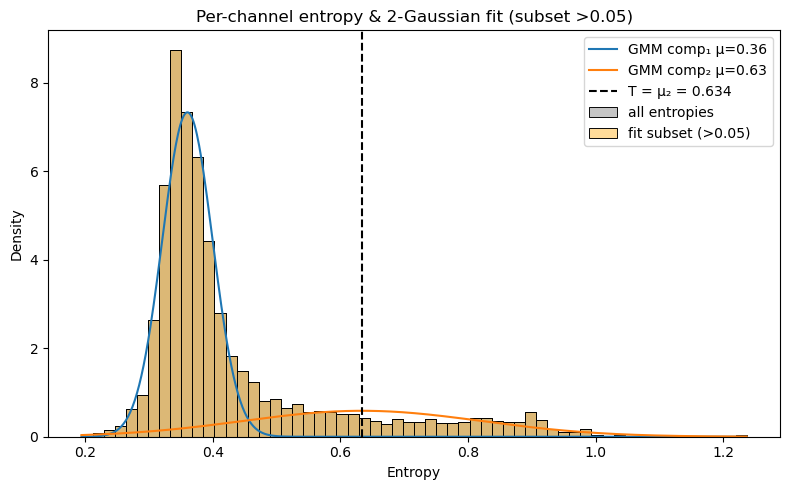

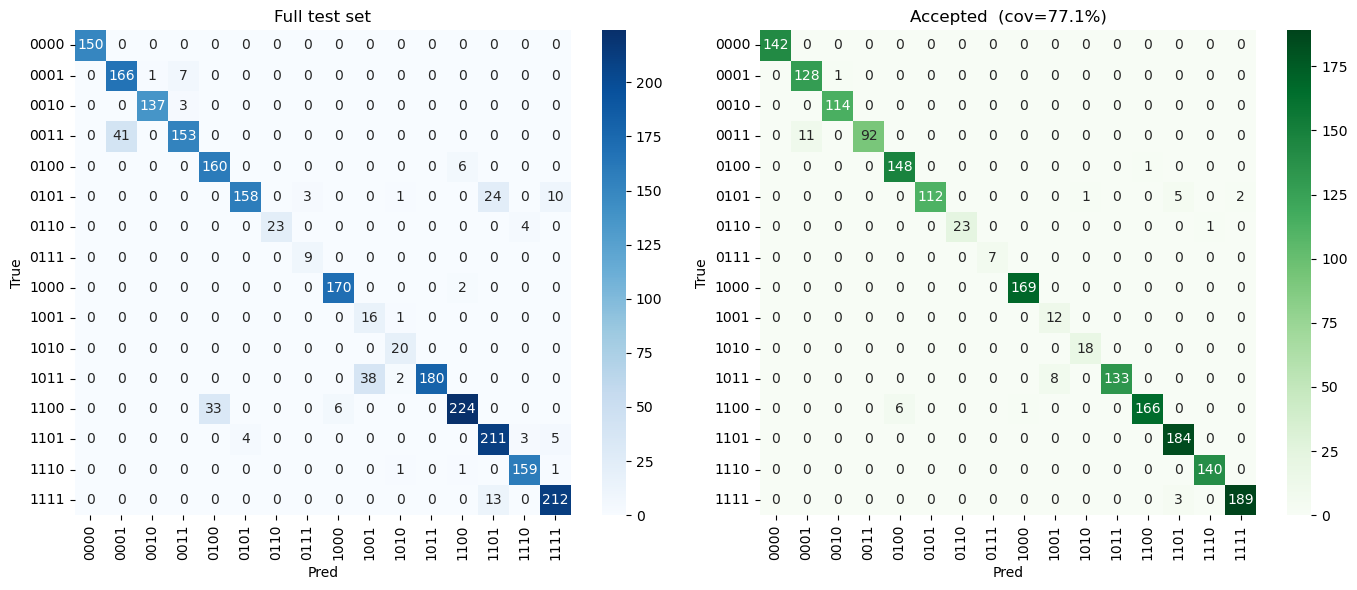

In [45]:
# entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\allbarcodetrain-20250516‐35-0.92.keras")
MODEL_FILE   = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\trainon16first-20250517-37-0.93.keras"

model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()


### Trained only on synthetic data

⚠️  No GPU detected — running on CPU


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(



📏  GMM (fit on ent>0.05) → μ₁=0.102, μ₂=0.472  ⇒  T = 0.472

── BEFORE rejection ─────────────────────────
 Overall accuracy: 63.91%  (N=2358)
 0000: 100.00%
 0001:  1.72%
 0010: 79.29%
 0011: 99.48%
 0100: 22.29%
 0101:  1.02%
 0110:  0.00%
 0111: 55.56%
 1000: 97.67%
 1001:  0.00%
 1010: 90.00%
 1011: 96.82%
 1100: 97.72%
 1101: 13.90%
 1110: 90.74%
 1111: 76.44%

── AFTER rejection (kept 88.7% of cells) ─────────
 Overall accuracy: 66.71%  (N=2091)
 0000: 100.00%
 0001:  1.28%
 0010: 83.62%
 0011: 99.47%
 0100: 16.42%
 0101:  0.00%
 0110:  0.00%
 0111: 40.00%
 1000: 99.38%
 1001:  0.00%
 1010: 94.74%
 1011: 97.66%
 1100: 98.43%
 1101:  8.59%
 1110: 95.80%
 1111: 84.48%


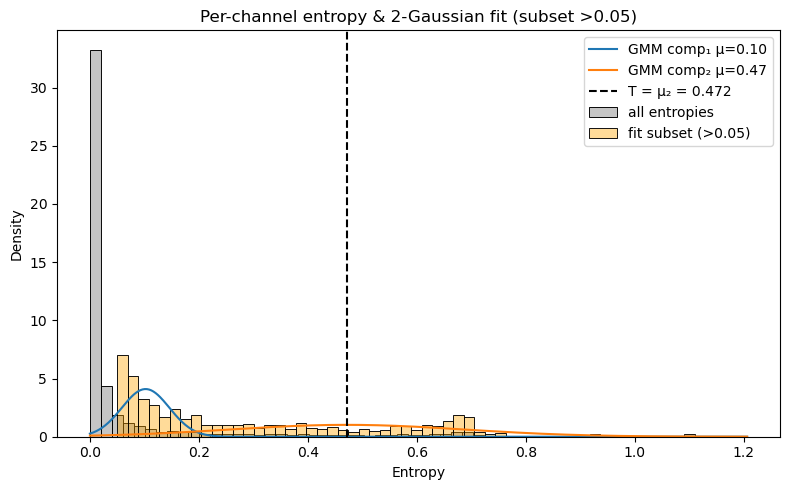

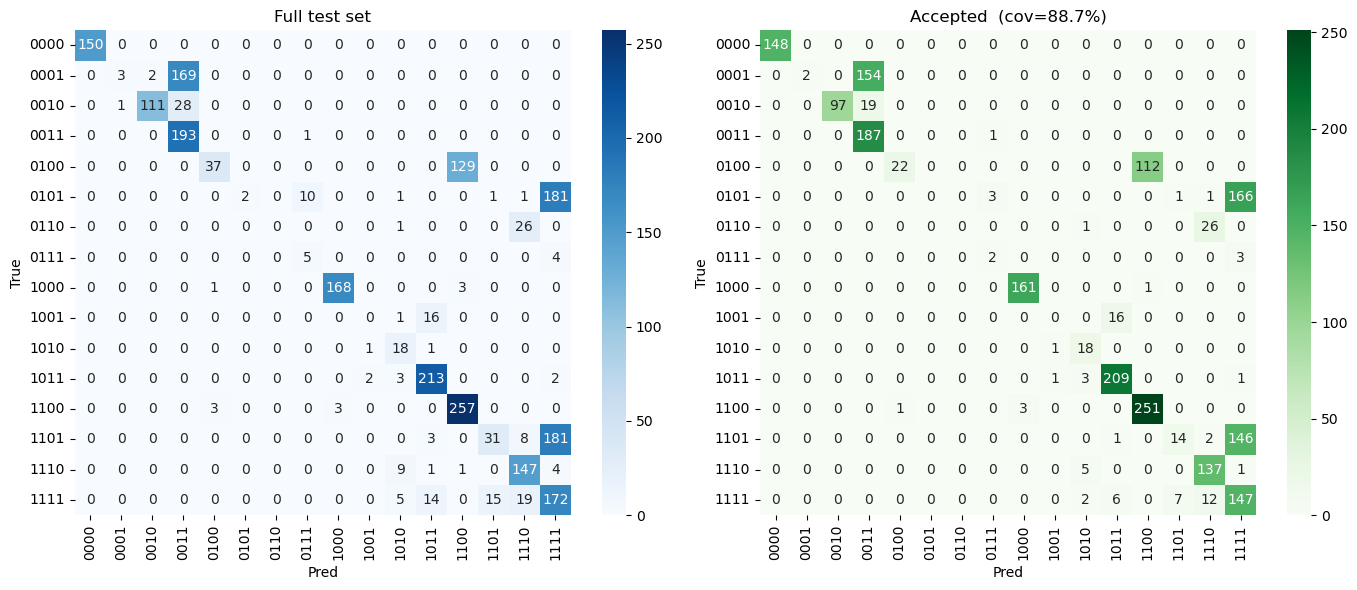

In [7]:
# test all synthetic training
# entropy-based rejection with GMM fitted on entropies > 0.05import os, zarr, math
import os
import zarr
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\allbarcodetrain-20250516‐35-0.92.keras")
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\synthetic-overnight-20250515‐38-0.99.keras")

model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()



for RFP, last two digit: 11-01
for BFP, first two digit: 01-11 



## (not used in the final report) Model 3

⚠️ No GPU detected — running on CPU

✅ Loaded model from: D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-allbarcodetrain-20250516-28-0.95.keras

────── Barcode decoding accuracy ──────
 Overall: 92.71%   (N = 2358)

Barcode Acc (%)   Support
 0000     99.33       150
 0001     98.28       174
 0010     98.57       140
 0011     78.35       194
 0100     99.40       166
 0101     89.80       196
 0110     92.59        27
 0111     88.89         9
 1000     98.84       172
 1001     94.12        17
 1010    100.00        20
 1011     76.82       220
 1100     92.40       263
 1101     95.52       223
 1110     96.91       162
 1111     95.11       225


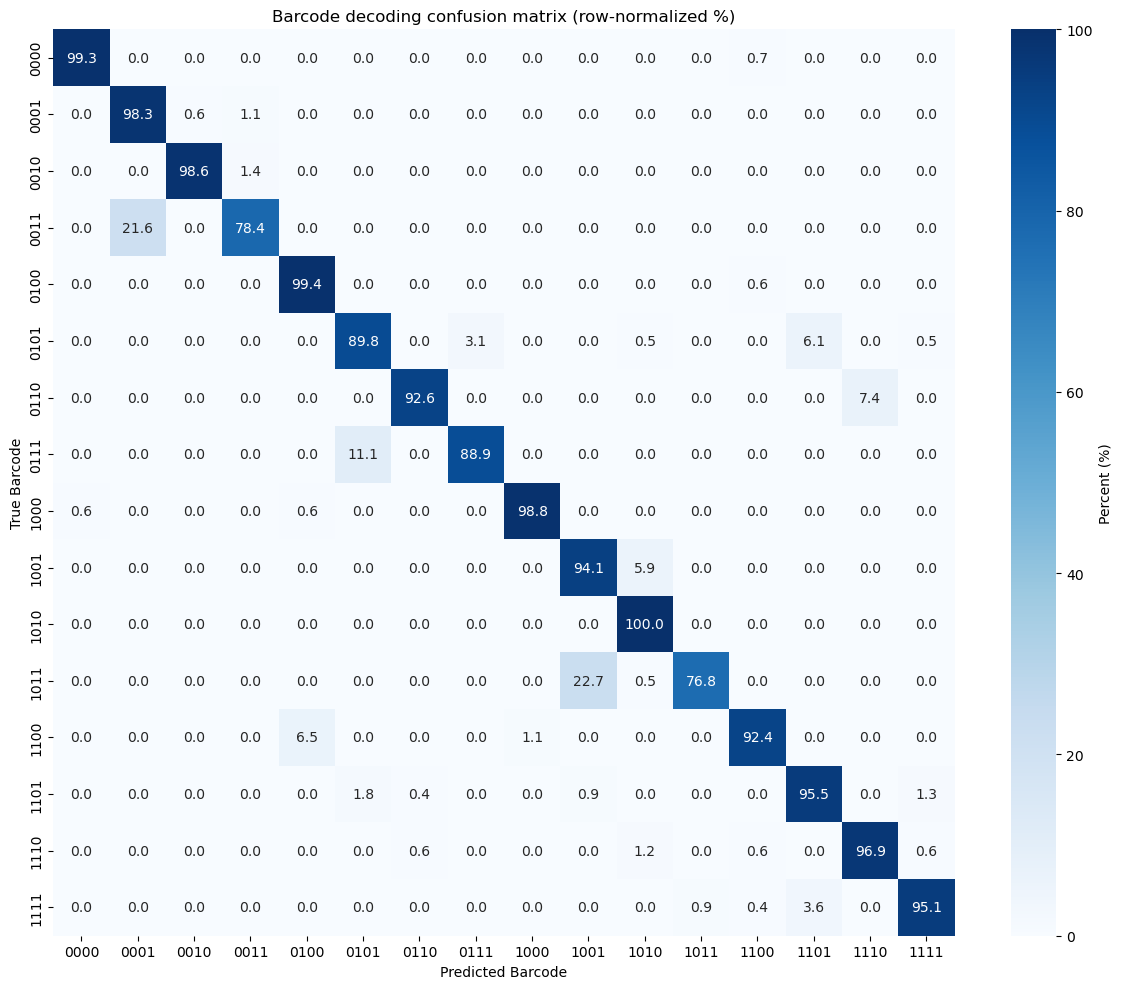

In [29]:
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
class L2NormLayer(layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
    def compute_output_shape(self, input_shape):
        return input_shape
# ── 0) GPU setup (optional) ─────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected — running on CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────
BASE        = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS   = os.path.join(BASE, "test_sets")
# MODEL_FILE  = os.path.join(base_dir, r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-202505151624-10-0.94.keras")
# MODEL_FILE  = os.path.join(r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-synth-overnight-20250515-28-0.99.keras")

MODEL_FILE  = os.path.join(r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-allbarcodetrain-20250516-28-0.95.keras")
model = tf.keras.models.load_model(MODEL_FILE, custom_objects={
      "InstanceNormalization": InstanceNormalization,
      "MixStyle": MixStyle,
      "L2NormLayer": L2NormLayer
    })
print(f"\n✅ Loaded model from: {MODEL_FILE}\n")

# ── 3) map channel-label → 2-bit code ─────────────────────────────────
code_map = {
    0: "00",  # background
    1: "10",  # membrane
    2: "01",  # nucleoid
    3: "11",  # both
}

# ── 4) iterate and predict ────────────────────────────────────────────
true_bcs, pred_bcs = [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue

    bc_true = fn[:4]  # e.g. "0000", "0010", ...
    path = os.path.join(TEST_SETS, fn)
    z = zarr.open(path, mode="r")

    # make sure we always have both channels as arrays,
    # even if one channel is missing, treat as all-zero (pure background)
    def load_channel(stack_name):
        if stack_name in z.array_keys():
            arr = z[stack_name][...].astype(np.float32)
        else:
            # no such channel → pure background
            n = z[next(iter(z.array_keys()))].shape[0]
            arr = np.zeros((n, *z[next(iter(z.array_keys()))].shape[1:]), dtype=np.float32)
        # normalize per cell
        arr = (arr - arr.min(axis=(1,2), keepdims=True)) / (
            arr.ptp(axis=(1,2), keepdims=True) + 1e-8
        )
        return arr

    bfp_stack = load_channel("bfp")
    rfp_stack = load_channel("rfp")

    n = bfp_stack.shape[0]
    for i in range(n):
        xb = bfp_stack[i][None, ..., None]
        xr = rfp_stack[i][None, ..., None]

        pb = model.predict(xb, verbose=0)[0]
        pr = model.predict(xr, verbose=0)[0]

        lb = int(np.argmax(pb))
        lr = int(np.argmax(pr))

        bc_pred = code_map[lb] + code_map[lr]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)

true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)

# make sure '0000' is included even if it never occurred
all_bcs = sorted(set(true_bcs) | set(pred_bcs) | {"0000"})

# overall
overall_acc = 100 * np.mean(true_bcs == pred_bcs)

# per-barcode
per_acc, support = {}, {}
for bc in all_bcs:
    idx = np.where(true_bcs == bc)[0]
    support[bc] = len(idx)
    per_acc[bc] = 100 * np.mean(pred_bcs[idx] == bc) if idx.size else 0.0

# build confusion
bc_to_idx = {bc: i for i, bc in enumerate(all_bcs)}
cm = np.zeros((len(all_bcs), len(all_bcs)), int)
for t, p in zip(true_bcs, pred_bcs):
    cm[bc_to_idx[t], bc_to_idx[p]] += 1

# ── report ────────────────────────────────────────────────────────────
print("────── Barcode decoding accuracy ──────")
print(f" Overall: {overall_acc:.2f}%   (N = {len(true_bcs)})\n")
print(f"{'Barcode':<6}{'Acc (%)':>8}{'Support':>10}")
for bc in all_bcs:
    print(f" {bc:<6}{per_acc[bc]:>8.2f}{support[bc]:>10}")

# ── plot confusion matrix ─────────────────────────────────────────────
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(12,10))
sns.heatmap(
    cm_percent, annot=True, fmt=".1f", cmap="Blues",
    xticklabels=all_bcs, yticklabels=all_bcs,
    cbar_kws={"label":"Percent (%)"}
)
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode decoding confusion matrix (row-normalized %)")
plt.tight_layout()
plt.show()

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.297, μ₂=0.607  ⇒  T = 0.607

── BEFORE rejection ─────────────────────────
 Overall accuracy: 92.71%  (N=2358)
 0000: 99.33%
 0001: 98.28%
 0010: 98.57%
 0011: 78.35%
 0100: 99.40%
 0101: 89.80%
 0110: 92.59%
 0111: 88.89%
 1000: 98.84%
 1001: 94.12%
 1010: 100.00%
 1011: 76.82%
 1100: 92.40%
 1101: 95.52%
 1110: 96.91%
 1111: 95.11%

── AFTER rejection (kept 92.0% of cells) ─────────
 Overall accuracy: 95.71%  (N=2170)
 0000: 100.00%
 0001: 98.79%
 0010: 98.55%
 0011: 82.91%
 0100: 100.00%
 0101: 95.73%
 0110: 92.31%
 0111: 88.89%
 1000: 100.00%
 1001: 100.00%
 1010: 100.00%
 1011: 84.78%
 1100: 95.34%
 1101: 98.52%
 1110: 97.45%
 1111: 97.22%


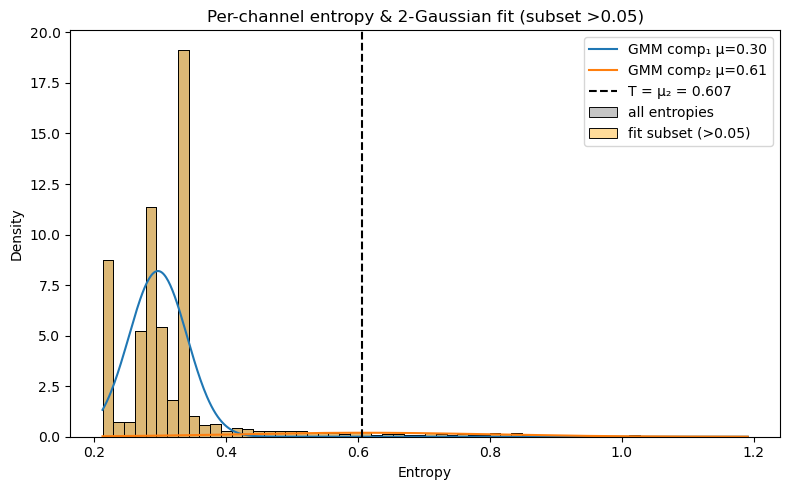

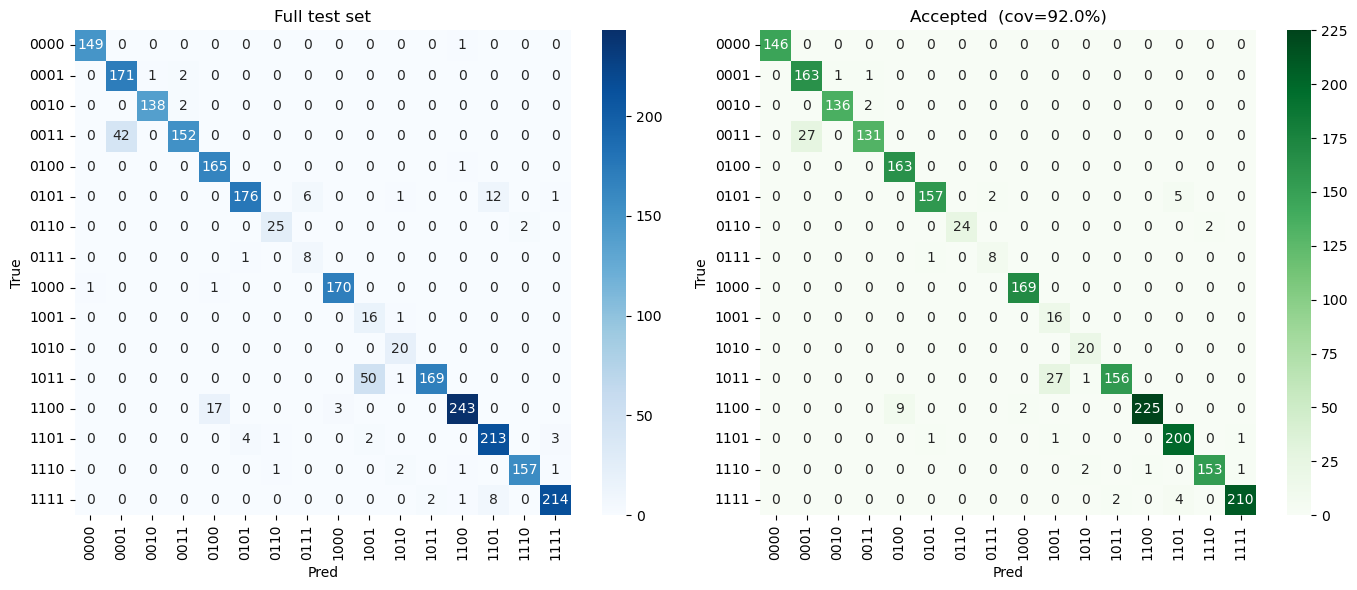

In [31]:
# entropy threshold
# entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-202505151624-10-0.94.keras"
MODEL_FILE  = os.path.join(r"D:\PRISM\PRISM_model\100xTraining\saved_model4\mixstyle_in_norm-allbarcodetrain-20250516-28-0.95.keras")
model = tf.keras.models.load_model(MODEL_FILE, custom_objects={
      "InstanceNormalization": InstanceNormalization,
      "MixStyle": MixStyle,
      "L2NormLayer": L2NormLayer
    })
# # ── 2) Load the trained channel classifier ────────────────────────────
# model = tf.keras.models.load_model(MODEL_FILE, custom_objects={"L2NormLayer": L2NormLayer})

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()


## (not used in the final report) Model 5

⚠️ No GPU detected — running on CPU

✅ Loaded model from: D:\PRISM\PRISM_model\100xTraining\saved_model5\LNMean-synthovernight-20250515-22-0.99.keras

────── Barcode decoding accuracy ──────
 Overall: 62.45%  (N = 1803)

Barcode  Acc (%)  Support
 0000       0.00        0
 0001       6.11      131
 0010      70.48      105
 0011      98.63      146
 0100      33.87      124
 0101       6.80      147
 0110      12.00       75
 0111      47.83       23
 1000      89.15      129
 1001      30.19       53
 1010      88.24       51
 1011      92.73      165
 1100      88.83      197
 1101      60.48      167
 1110      81.82      121
 1111      73.37      169


C:\Users\kastu\AppData\Local\Temp\ipykernel_34304\2933679039.py:137: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # shape (16, 16)


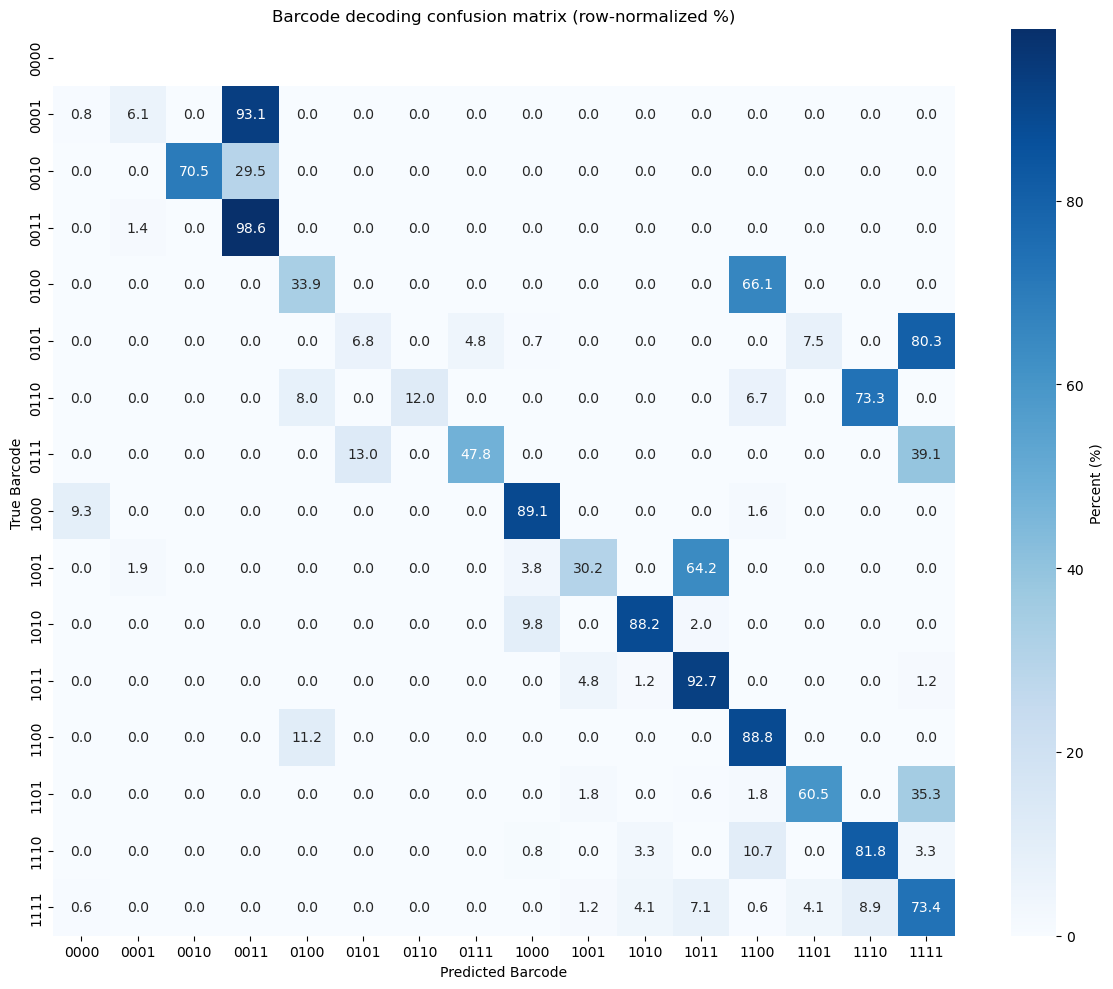

In [14]:
import os
import zarr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2
class L2NormLayer(layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
    def compute_output_shape(self, input_shape):
        return input_shape
# ── 0) GPU setup (optional) ─────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️ No GPU detected — running on CPU")

# ── 1) Paths ─────────────────────────────────────────────────────────
BASE        = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS   = os.path.join(BASE, "test_sets")
MODEL_FILE  = os.path.join(r"D:\PRISM\PRISM_model\100xTraining\saved_model5\LNMean-synthovernight-20250515-22-0.99.keras")
model = tf.keras.models.load_model(MODEL_FILE, custom_objects={
      "InstanceNormalization": InstanceNormalization,
      "MixStyle": MixStyle,
      "L2NormLayer": L2NormLayer
    })
print(f"\n✅ Loaded model from: {MODEL_FILE}\n")

# ── 3) Helper: map channel‐label → 2-bit code ─────────────────────────
code_map = {
    0: "00",  # background
    1: "10",  # membrane
    2: "01",  # nucleoid
    3: "11",  # both
}

# ── 4) Iterate test_sets and predict barcodes ────────────────────────
true_bcs = []
pred_bcs = []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue
    bc_true = fn[:4]
    path = os.path.join(TEST_SETS, fn)
    z = zarr.open(path, mode="r")

    bfp_stack = z["bfp"][...]
    rfp_stack = z["rfp"][...]
    n = bfp_stack.shape[0]

    for i in range(n):
        # 1) raw → float32 [0,1]
        b = bfp_stack[i].astype(np.float32)
        b = (b - b.min()) / (b.ptp() + 1e-8)
        r = rfp_stack[i].astype(np.float32)
        r = (r - r.min()) / (r.ptp() + 1e-8)

        # 2) NL-Means denoise each channel
        b_uint8 = (b * 255).astype(np.uint8)
        b_dn = cv2.fastNlMeansDenoising(b_uint8, None,
                                        h=10,
                                        templateWindowSize=6,
                                        searchWindowSize=21)
        b = b_dn.astype(np.float32) / 255.0

        r_uint8 = (r * 255).astype(np.uint8)
        r_dn = cv2.fastNlMeansDenoising(r_uint8, None,
                                        h=10,
                                        templateWindowSize=6,
                                        searchWindowSize=21)
        r = r_dn.astype(np.float32) / 255.0

        # 3) re-normalize to [0,1] just in case
        b = np.clip((b - b.min())/(b.ptp()+1e-8), 0, 1)
        r = np.clip((r - r.min())/(r.ptp()+1e-8), 0, 1)

        # 4) batch + channel dims
        xb = b[None, ..., None]
        xr = r[None, ..., None]

        # 5) predict
        pb = model.predict(xb, verbose=0)
        pr = model.predict(xr, verbose=0)
        lb = int(np.argmax(pb, axis=1)[0])
        lr = int(np.argmax(pr, axis=1)[0])
        bc_pred = code_map[lb] + code_map[lr]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)

# ── 5) Compute overall & per-barcode accuracy ────────────────────────
true_bcs = np.array(true_bcs)
pred_bcs = np.array(pred_bcs)
all_bcs  = sorted(set(true_bcs) | set(pred_bcs))  # include all barcodes

# overall
overall_acc = np.mean(true_bcs == pred_bcs) * 100

# per‐barcode
per_acc = {}
support = {}
for bc in all_bcs:
    idx = np.where(true_bcs == bc)[0]
    support[bc] = len(idx)
    per_acc[bc] = np.mean(pred_bcs[idx] == bc) * 100 if len(idx) > 0 else 0

# ── 6) Build confusion matrix ────────────────────────────────────────
bc_to_idx = {bc:i for i, bc in enumerate(all_bcs)}
cm = np.zeros((len(all_bcs), len(all_bcs)), dtype=int)
for t, p in zip(true_bcs, pred_bcs):
    i, j = bc_to_idx[t], bc_to_idx[p]
    cm[i,j] += 1


# ── 7) Print report ─────────────────────────────────────────────────
print("────── Barcode decoding accuracy ──────")
print(f" Overall: {overall_acc:.2f}%  (N = {len(true_bcs)})\n")
print(f"{'Barcode':<6} {'Acc (%)':>8} {'Support':>8}")
for bc in sorted(all_bcs):
    print(f" {bc:<6} {per_acc[bc]:>8.2f} {support[bc]:>8}")

# ── 8) Plot confusion matrix ────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ── Normalize confusion matrix row-wise (so each row sums to 100%) ──
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # shape (16, 16)

# ── Plot confusion matrix ─────────────────────────────────────────────
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_percent,
    annot=True, fmt=".1f",
    xticklabels=all_bcs,
    yticklabels=all_bcs,
    cmap="Blues",
    cbar_kws={"label": "Percent (%)"}
)
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode decoding confusion matrix (row-normalized %)")
plt.tight_layout()
plt.show()



── AFTER rejection (kept 83.9% of cells) ─────────
 Overall accuracy: 93.85%  (N=1513)
 0001: 97.50%
 0010: 98.02%
 0011: 84.21%
 0100: 99.15%
 0101: 95.10%
 0110: 58.70%
 0111: 100.00%
 1000: 100.00%
 1001: 41.18%
 1010: 100.00%
 1011: 89.15%
 1100: 95.09%
 1101: 99.31%
 1110: 98.15%
 1111: 98.08%


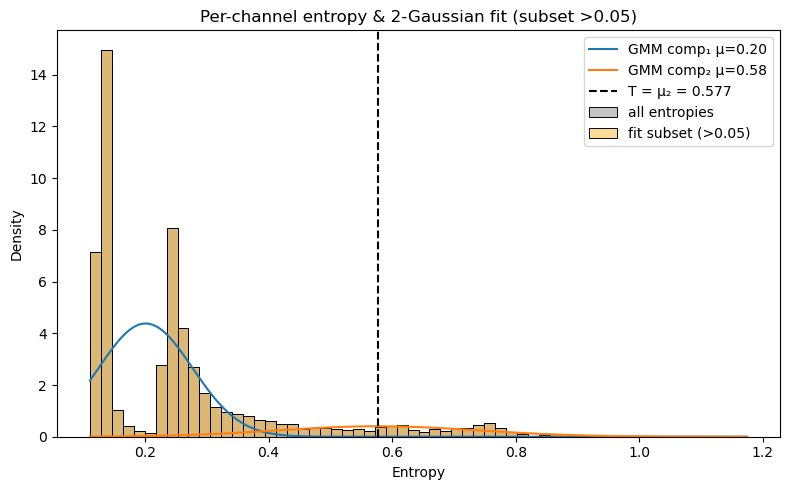

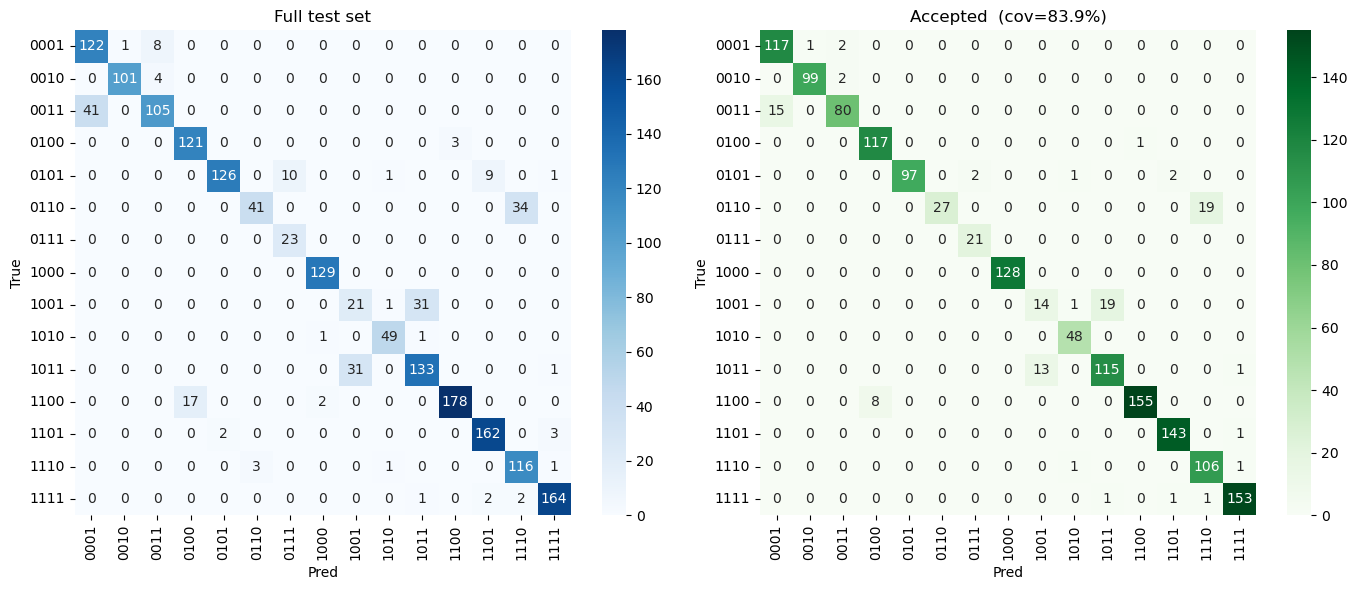

In [11]:
true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask, dtype=bool)

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()

# Improving strategy by inspecting setup 1

In [12]:
import numpy as np

# true_bcs, pred_bcs: lists or 1D‐arrays of your 4‐bit barcode strings, e.g. "0011"
# e.g. true_bcs = ['0001','0010',...], pred_bcs = [...]

bit_correct = np.zeros(4, dtype=int)
bit_total   = np.zeros(4, dtype=int)

for t, p in zip(true_bcs, pred_bcs):
    t_bits = list(map(int, t))
    p_bits = list(map(int, p))
    for i in range(4):
        bit_correct[i] += (t_bits[i] == p_bits[i])
        bit_total[i]   += 1

bit_acc = bit_correct / bit_total * 100.0

print("Bit-wise accuracy:")
for i, acc in enumerate(bit_acc):
    channel = "BFP" if i < 2 else "RFP"
    print(f"  Bit {i+1} ({channel} bit): {acc:.2f}%")

# Optionally, group by BFP vs RFP:
print("\nOverall BFP bits accuracy: "
      f"{bit_acc[0:2].mean():.2f}%")
print("Overall RFP bits accuracy: "
      f"{bit_acc[2:4].mean():.2f}%")


Bit-wise accuracy:
  Bit 1 (BFP bit): 96.20%
  Bit 2 (BFP bit): 99.58%
  Bit 3 (RFP bit): 92.95%
  Bit 4 (RFP bit): 99.52%

Overall BFP bits accuracy: 97.89%
Overall RFP bits accuracy: 96.23%


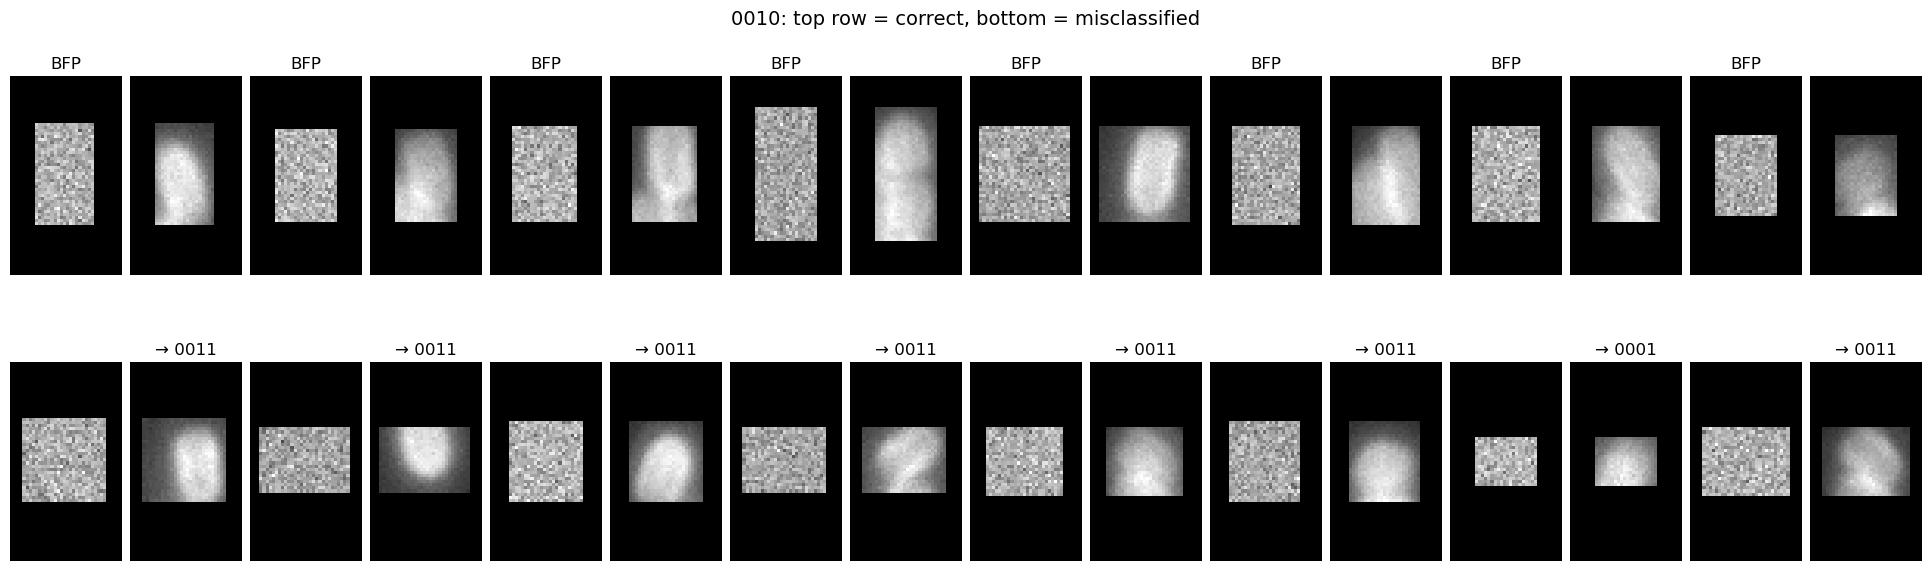

In [25]:
import os, zarr

base_dir     = r"D:\PRISM\Mother Cell For PRISM Train"
test_dir     = os.path.join(base_dir, "test_sets")
entries = []  # (barcode, zarr_path, local_idx)
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"):
        continue
    bc = fn[:4]
    path = os.path.join(test_dir, fn)
    z = zarr.open(path, mode="r")
    n = z["bfp"].shape[0]
    for i in range(n):
        entries.append((bc, path, i))
# Now `entries[k]` corresponds to the k-th cell, matching true_bcs[k]/pred_bcs[k].
import numpy as np
import matplotlib.pyplot as plt

barcode = "0010"
show = 8  # how many examples of each

# collect entry indices
corr_idxs = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs))
             if t==barcode and p==barcode]
mis_idxs  = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs))
             if t==barcode and p!=barcode]

# take up to `show` of each
corr_idxs = corr_idxs[:show]
mis_idxs  = mis_idxs[:show]

# plot
fig, axes = plt.subplots(2, show*2, figsize=(show*2.4, 6),
                         constrained_layout=True)
fig.suptitle(f"{barcode}: top row = correct, bottom = misclassified", fontsize=14)

for col, idx_list in enumerate([corr_idxs, mis_idxs]):
    row = 0 if col==0 else 1
    sl = corr_idxs if col==0 else mis_idxs
    for j, k in enumerate(sl):
        bc, zpath, loc = entries[k]
        z = zarr.open(zpath, mode="r")
        bfp = z["bfp"][loc]
        rfp = z["rfp"][loc]

        # BFP
        ax = axes[row, 2*j]
        ax.imshow(bfp, cmap="gray")
        if row==0: ax.set_title("BFP")
        ax.axis("off")

        # RFP
        ax = axes[row, 2*j+1]
        ax.imshow(rfp, cmap="gray")
        if row==1: ax.set_title(f"→ {pred_bcs[k]}")
        ax.axis("off")

plt.show()


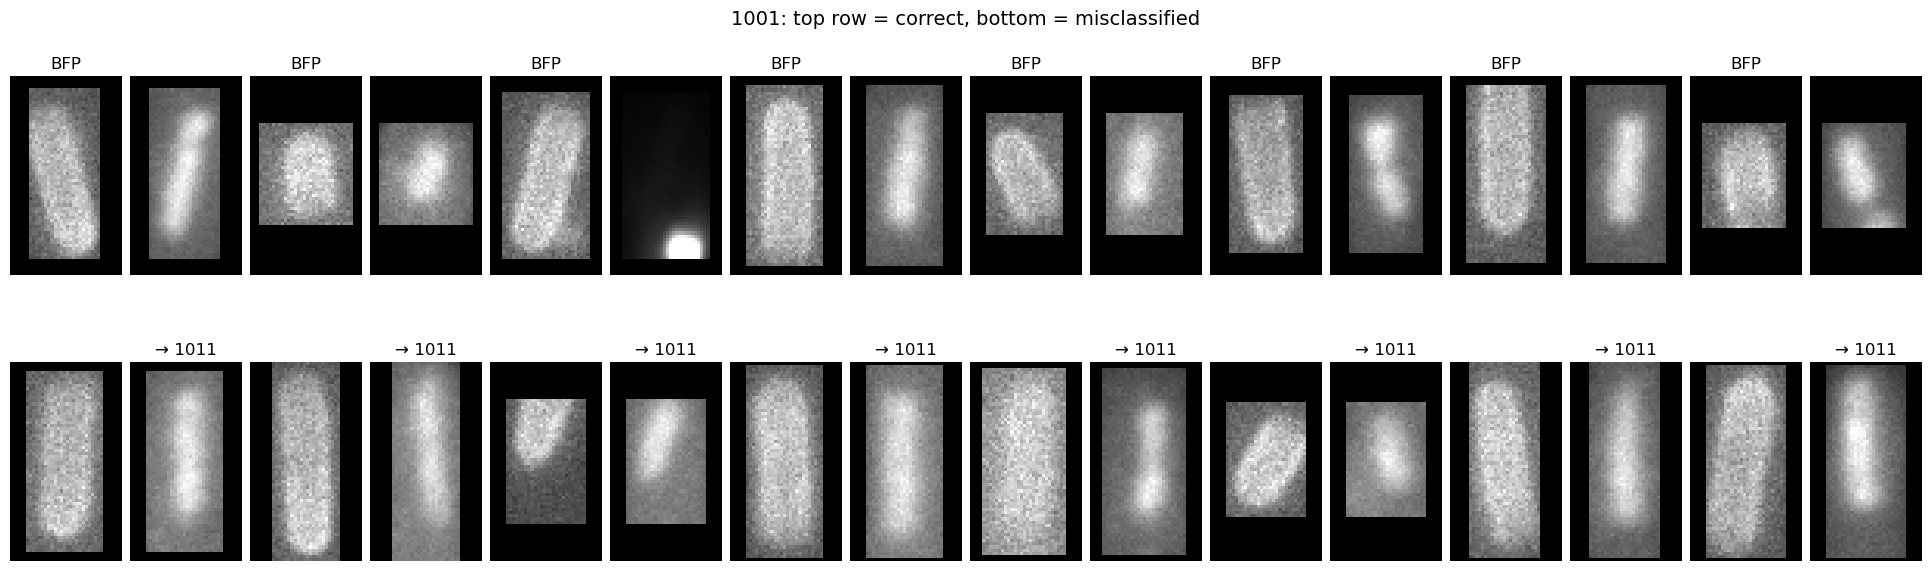

In [14]:
import os, zarr

base_dir     = r"D:\PRISM\Mother Cell For PRISM Train"
test_dir     = os.path.join(base_dir, "test_sets")
entries = []  # (barcode, zarr_path, local_idx)
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"):
        continue
    bc = fn[:4]
    path = os.path.join(test_dir, fn)
    z = zarr.open(path, mode="r")
    n = z["bfp"].shape[0]
    for i in range(n):
        entries.append((bc, path, i))
# Now `entries[k]` corresponds to the k-th cell, matching true_bcs[k]/pred_bcs[k].
import numpy as np
import matplotlib.pyplot as plt

barcode = "1001"
show = 8  # how many examples of each

# collect entry indices
corr_idxs = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs))
             if t==barcode and p==barcode]
mis_idxs  = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs))
             if t==barcode and p!=barcode]

# take up to `show` of each
corr_idxs = corr_idxs[:show]
mis_idxs  = mis_idxs[:show]

# plot
fig, axes = plt.subplots(2, show*2, figsize=(show*2.4, 6),
                         constrained_layout=True)
fig.suptitle(f"{barcode}: top row = correct, bottom = misclassified", fontsize=14)

for col, idx_list in enumerate([corr_idxs, mis_idxs]):
    row = 0 if col==0 else 1
    sl = corr_idxs if col==0 else mis_idxs
    for j, k in enumerate(sl):
        bc, zpath, loc = entries[k]
        z = zarr.open(zpath, mode="r")
        bfp = z["bfp"][loc]
        rfp = z["rfp"][loc]

        # BFP
        ax = axes[row, 2*j]
        ax.imshow(bfp, cmap="gray")
        if row==0: ax.set_title("BFP")
        ax.axis("off")

        # RFP
        ax = axes[row, 2*j+1]
        ax.imshow(rfp, cmap="gray")
        if row==1: ax.set_title(f"→ {pred_bcs[k]}")
        ax.axis("off")

plt.show()


## (not used in the final report) try some pre-processing to remove noise etc

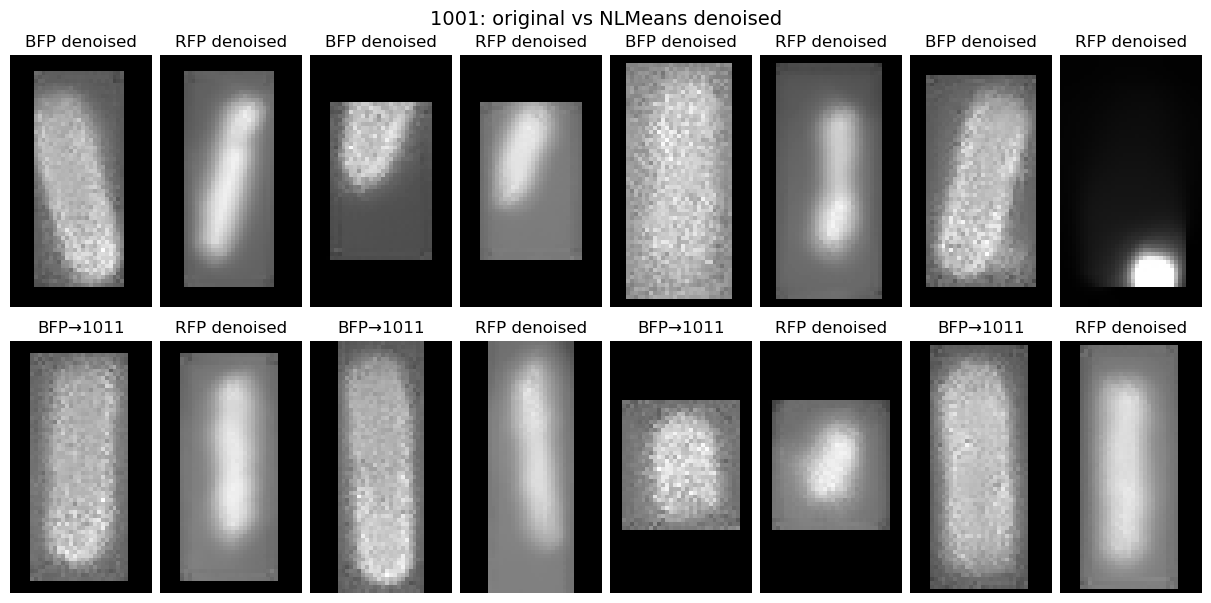

In [49]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ── Configuration ─────────────────────────────────────────────────────
base_dir = r"D:\PRISM\Mother Cell For PRISM Train"
test_dir = os.path.join(base_dir, "test_sets")
barcode = "1001"
show = 4  # number of examples per row

# ── Gather entries ─────────────────────────────────────────────────────
entries = []
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"):
        continue
    bc = fn[:4]
    path = os.path.join(test_dir, fn)
    z = zarr.open(path, mode="r")
    n = z["bfp"].shape[0]
    for i in range(n):
        entries.append((bc, path, i))

# ── Assume true_bcs and pred_bcs already defined ────────────────────────
# Filter indices for this barcode
corr_idxs = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs)) if t==barcode and p==barcode][:show]
mis_idxs  = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs)) if t==barcode and p!=barcode][:show]

# ── Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, show*2, figsize=(show*3, 6), constrained_layout=True)
fig.suptitle(f"{barcode}: original vs NLMeans denoised", fontsize=14)

for row, idx_list in enumerate([corr_idxs, mis_idxs]):
    for col, k in enumerate(idx_list):
        bc, zpath, loc = entries[k]
        z = zarr.open(zpath, mode="r")
        bfp = (z["bfp"][loc].astype(np.float32) - z["bfp"][loc].min()) / (z["bfp"][loc].ptp() + 1e-8)
        rfp = (z["rfp"][loc].astype(np.float32) - z["rfp"][loc].min()) / (z["rfp"][loc].ptp() + 1e-8)

        # apply Non-Local Means denoising
        bfp_uint = (bfp * 255).astype(np.uint8)
        rfp_uint = (rfp * 255).astype(np.uint8)
        bfp_dn = cv2.fastNlMeansDenoising(bfp_uint, None, h=10, templateWindowSize=6, searchWindowSize=21) / 255.0
        rfp_dn = cv2.fastNlMeansDenoising(rfp_uint, None, h=10, templateWindowSize=6, searchWindowSize=21) / 255.0

        # Show BFP
        ax = axes[row, 2*col]
        ax.imshow(bfp_dn, cmap="gray", vmin=0, vmax=1)
        ax.set_title("BFP denoised" if row==0 else f"BFP→{pred_bcs[k]}")
        ax.axis("off")

        # Show RFP
        ax = axes[row, 2*col+1]
        ax.imshow(rfp_dn, cmap="gray", vmin=0, vmax=1)
        ax.set_title("RFP denoised")
        ax.axis("off")

plt.show()


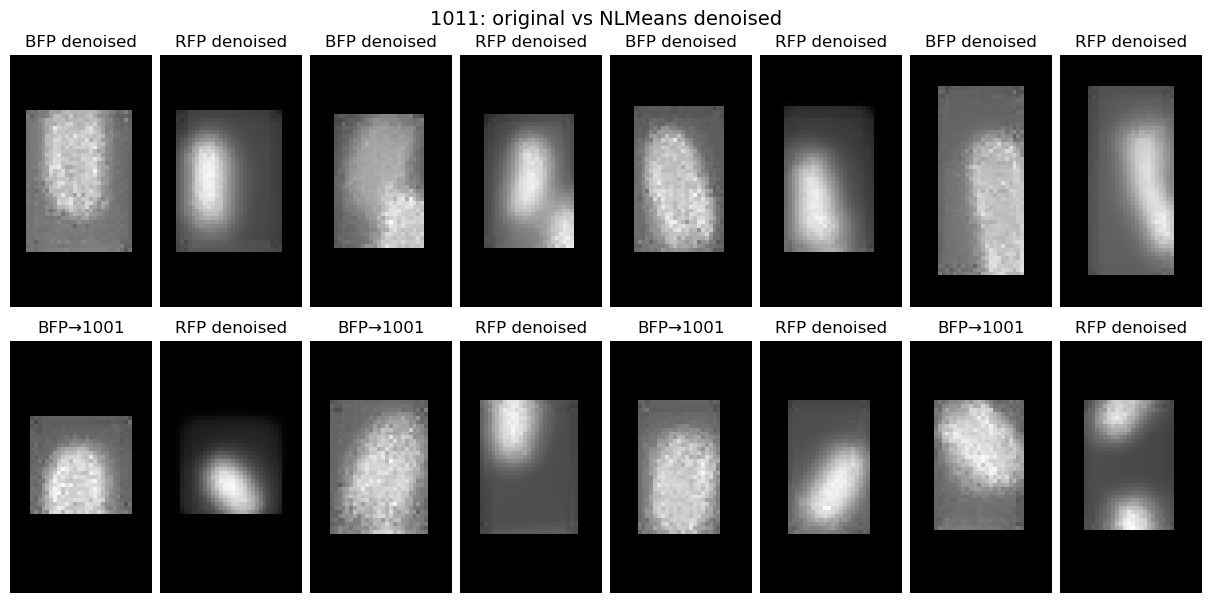

In [50]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ── Configuration ─────────────────────────────────────────────────────
base_dir = r"D:\PRISM\Mother Cell For PRISM Train"
test_dir = os.path.join(base_dir, "test_sets")
barcode = "1011"
show = 4  # number of examples per row

# ── Gather entries ─────────────────────────────────────────────────────
entries = []
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"):
        continue
    bc = fn[:4]
    path = os.path.join(test_dir, fn)
    z = zarr.open(path, mode="r")
    n = z["bfp"].shape[0]
    for i in range(n):
        entries.append((bc, path, i))

# ── Assume true_bcs and pred_bcs already defined ────────────────────────
# Filter indices for this barcode
corr_idxs = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs)) if t==barcode and p==barcode][:show]
mis_idxs  = [k for k,(t,p) in enumerate(zip(true_bcs, pred_bcs)) if t==barcode and p!=barcode][:show]

# ── Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, show*2, figsize=(show*3, 6), constrained_layout=True)
fig.suptitle(f"{barcode}: original vs NLMeans denoised", fontsize=14)

for row, idx_list in enumerate([corr_idxs, mis_idxs]):
    for col, k in enumerate(idx_list):
        bc, zpath, loc = entries[k]
        z = zarr.open(zpath, mode="r")
        bfp = (z["bfp"][loc].astype(np.float32) - z["bfp"][loc].min()) / (z["bfp"][loc].ptp() + 1e-8)
        rfp = (z["rfp"][loc].astype(np.float32) - z["rfp"][loc].min()) / (z["rfp"][loc].ptp() + 1e-8)

        # apply Non-Local Means denoising
        bfp_uint = (bfp * 255).astype(np.uint8)
        rfp_uint = (rfp * 255).astype(np.uint8)
        bfp_dn = cv2.fastNlMeansDenoising(bfp_uint, None, h=10, templateWindowSize=6, searchWindowSize=21) / 255.0
        rfp_dn = cv2.fastNlMeansDenoising(rfp_uint, None, h=10, templateWindowSize=6, searchWindowSize=21) / 255.0

        # Show BFP
        ax = axes[row, 2*col]
        ax.imshow(bfp_dn, cmap="gray", vmin=0, vmax=1)
        ax.set_title("BFP denoised" if row==0 else f"BFP→{pred_bcs[k]}")
        ax.axis("off")

        # Show RFP
        ax = axes[row, 2*col+1]
        ax.imshow(rfp_dn, cmap="gray", vmin=0, vmax=1)
        ax.set_title("RFP denoised")
        ax.axis("off")

plt.show()


looks like correct image is more blurred: nucleoid dye has stronger signal so focus more?

🚀 Embedding 1659 test cells
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\kastu\AppData\Local\Temp\ipykernel_88504\2391512194.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


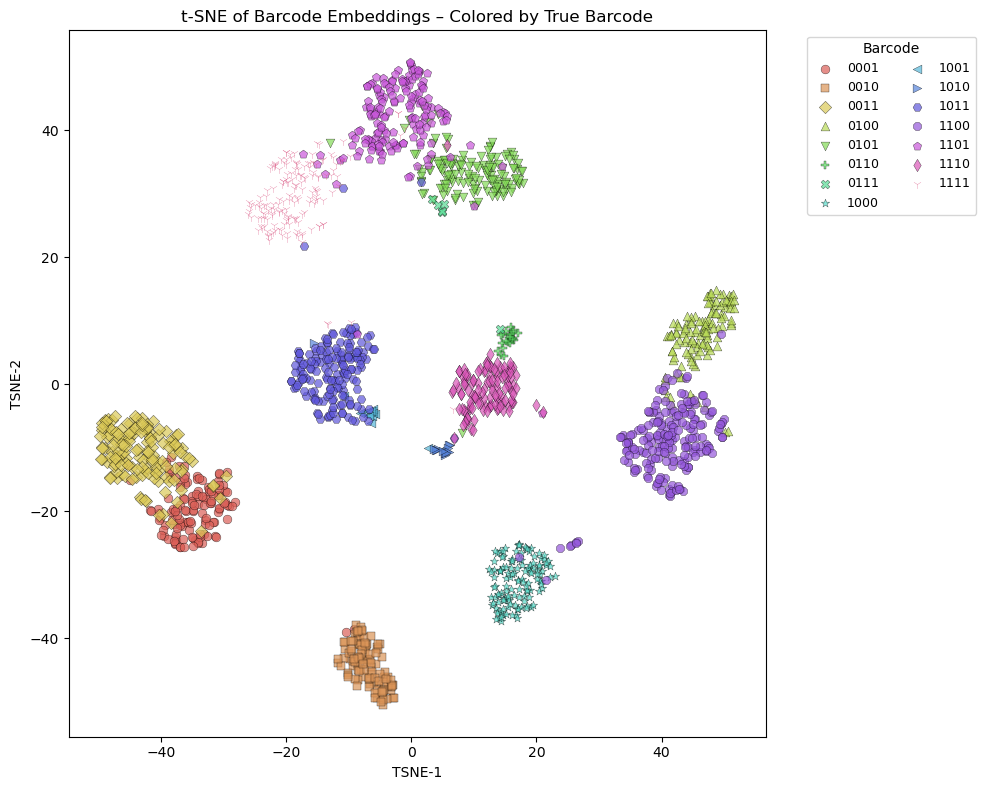

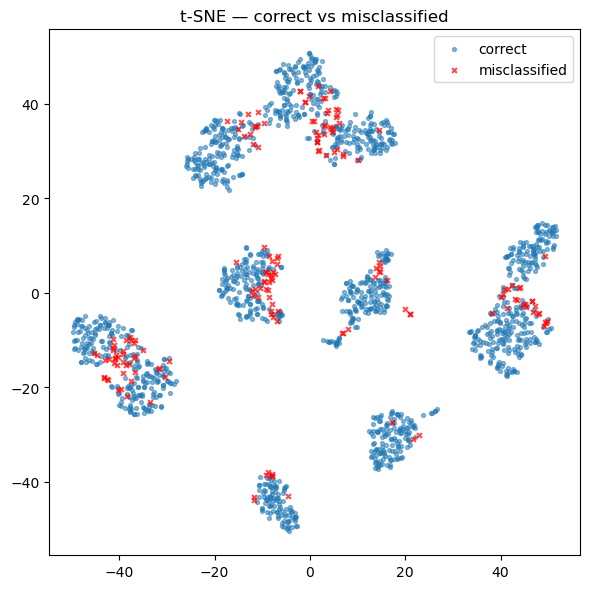

In [25]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# ── CONFIG ─────────────────────────────────────────────────────────
test_dir    = r"D:\PRISM\Mother Cell For PRISM Train\test_sets"
model_file  = r"D:\PRISM\PRISM_model\100xTraining\saved_model\saved-plain-model-202505132209-37-0.93.keras"

# ── 1) Load your trained channel_model and build penultimate‐layer submodel ─
channel_model = load_model(model_file)
# assume the very last layer is softmax, so penultimate is [-2]
penult_layer = channel_model.layers[-2].output
emb_model = Model(inputs=channel_model.input, outputs=penult_layer)

# ── 2) Walk through all test_sets/*.zarr and build arrays + barcode lists ──
bfp_list, rfp_list = [], []
true_bcs, pred_bcs = [], []
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"): continue
    bc = fn[:4]
    zpath = os.path.join(test_dir, fn)
    z = zarr.open(zpath, mode="r")
    bfp = z["bfp"][...]  # shape (ncells,64,36)
    rfp = z["rfp"][...]
    nc = bfp.shape[0]
    # normalize each cell to [0,1]
    for i in range(nc):
        bi = bfp[i].astype(np.float32)
        ri = rfp[i].astype(np.float32)
        bfp_list.append((bi - bi.min())/(bi.ptp()+1e-8))
        rfp_list.append((ri - ri.min())/(ri.ptp()+1e-8))
        true_bcs.append(bc)
        # you should have already computed pred_bcs in the same order!
        # here we'll just reload them from your previous list:
        # pred_bcs.append(previous_pred_list[k])
        # but for this snippet assume they've been filled.

# convert to arrays with channel dim
X_bfp = np.stack(bfp_list, axis=0)[...,None]  # (N,64,36,1)
X_rfp = np.stack(rfp_list, axis=0)[...,None]

assert len(true_bcs)==len(X_bfp)==len(X_rfp)
N = len(true_bcs)
print(f"🚀 Embedding {N} test cells")

# ── PREDICT full 4-bit barcode for every cell ────────────────────────
#  class-id → 2-bit string lookup  (matches your training labels)
#      0 = Background  → "00"
#      1 = Membrane    → "10"
#      2 = Nucleoid    → "01"
#      3 = Both        → "11"
bit_map = {0: "00", 1: "10", 2: "01", 3: "11"}

# predict channel class for every cell           (N,4) logits → (N,) id
pred_cls_bfp = np.argmax(channel_model.predict(X_bfp,
                                               batch_size=128,
                                               verbose=0), axis=1)
pred_cls_rfp = np.argmax(channel_model.predict(X_rfp,
                                               batch_size=128,
                                               verbose=0), axis=1)

pred_bcs = [
    bit_map[b] + bit_map[r]          # concatenate BFP bits + RFP bits
    for b, r in zip(pred_cls_bfp, pred_cls_rfp)
]

assert len(pred_bcs) == len(true_bcs)   # now both are 1 659 long


# ── 3) Compute penultimate embeddings for both channels ─────────────
emb_bfp = emb_model.predict(X_bfp, batch_size=128, verbose=1)  # (N,32)
emb_rfp = emb_model.predict(X_rfp, batch_size=128, verbose=1)

# concatenate to get a 64‐dim “barcode embedding” per cell
emb_full = np.concatenate([emb_bfp, emb_rfp], axis=1)  # (N,64)

# ── 4) Run t-SNE → 2D ───────────────────────────────────────────────
emb2d = TSNE(n_components=2, random_state=42).fit_transform(emb_full)

# ── 5) Plot by true barcode ─────────────────────────────────────────
import seaborn as sns
import matplotlib.pyplot as plt

unique_bcs = sorted(set(true_bcs))
n_classes = len(unique_bcs)
palette = sns.color_palette("hls", n_classes)
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '<', '>', 'H', '8', 'p', 'd', '1', '2']

plt.figure(figsize=(10, 8))
for i, bc in enumerate(unique_bcs):
    mask = np.array(true_bcs) == bc
    color = palette[i % len(palette)]
    marker = markers[i % len(markers)]
    plt.scatter(
        emb2d[mask, 0], emb2d[mask, 1],
        s=40, marker=marker, color=color,
        alpha=0.7, label=bc, edgecolors='black', linewidths=0.3
    )

plt.title("t-SNE of Barcode Embeddings – Colored by True Barcode")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Barcode", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


# ── 6) Plot correct vs mis ──────────────────────────────────────────
correct = (np.array(true_bcs) == np.array(pred_bcs))

plt.figure(figsize=(6,6))
plt.scatter(emb2d[correct,0], emb2d[correct,1],
            s=8, alpha=0.5, label="correct")
plt.scatter(emb2d[~correct,0], emb2d[~correct,1],
            s=12, alpha=0.7, label="misclassified", marker="x", color="red")
plt.legend()
plt.title("t-SNE — correct vs misclassified")
plt.tight_layout()
plt.show()


🚀 Embedding 1659 test cells
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\kastu\AppData\Local\Temp\ipykernel_88504\4069670254.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


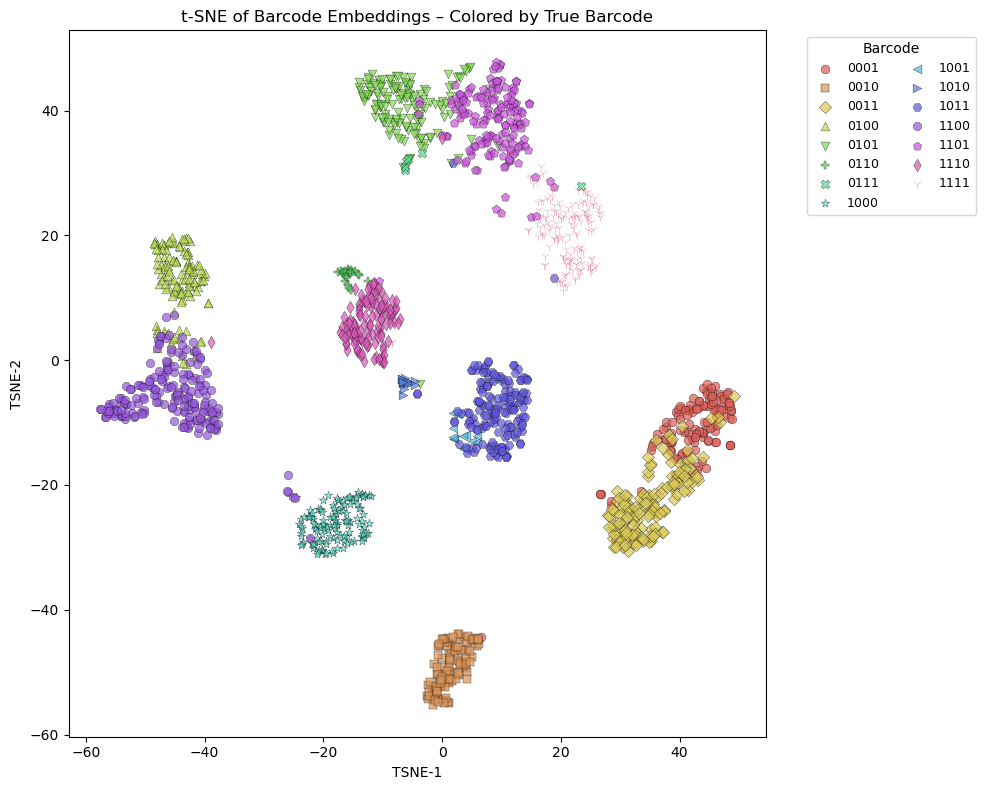

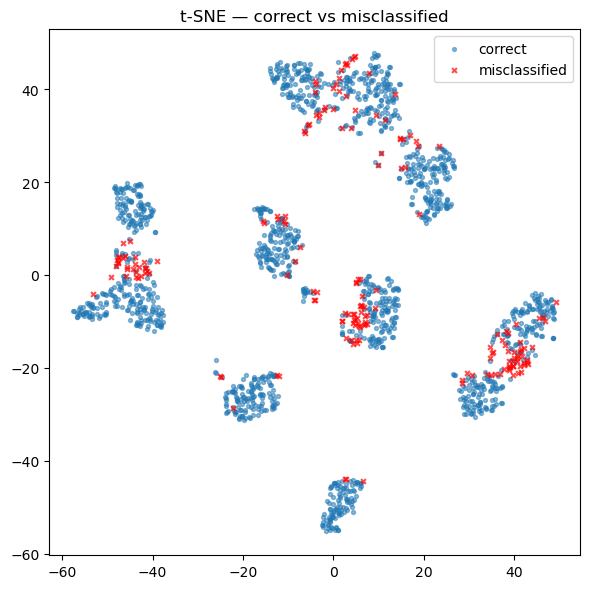

In [ ]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# ── CONFIG ─────────────────────────────────────────────────────────
test_dir    = r"D:\PRISM\Mother Cell For PRISM Train\test_sets"
model_file  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"

# ── 1) Load your trained channel_model and build penultimate‐layer submodel ─
channel_model = load_model(model_file)
# assume the very last layer is softmax, so penultimate is [-2]
penult_layer = channel_model.layers[-2].output
emb_model = Model(inputs=channel_model.input, outputs=penult_layer)

# ── 2) Walk through all test_sets/*.zarr and build arrays + barcode lists ──
bfp_list, rfp_list = [], []
true_bcs, pred_bcs = [], []
for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"): continue
    bc = fn[:4]
    zpath = os.path.join(test_dir, fn)
    z = zarr.open(zpath, mode="r")
    bfp = z["bfp"][...]  # shape (ncells,64,36)
    rfp = z["rfp"][...]
    nc = bfp.shape[0]
    # normalize each cell to [0,1]
    for i in range(nc):
        bi = bfp[i].astype(np.float32)
        ri = rfp[i].astype(np.float32)
        bfp_list.append((bi - bi.min())/(bi.ptp()+1e-8))
        rfp_list.append((ri - ri.min())/(ri.ptp()+1e-8))
        true_bcs.append(bc)
        # you should have already computed pred_bcs in the same order!
        # here we'll just reload them from your previous list:
        # pred_bcs.append(previous_pred_list[k])
        # but for this snippet assume they've been filled.

# convert to arrays with channel dim
X_bfp = np.stack(bfp_list, axis=0)[...,None]  # (N,64,36,1)
X_rfp = np.stack(rfp_list, axis=0)[...,None]

assert len(true_bcs)==len(X_bfp)==len(X_rfp)
N = len(true_bcs)
print(f"🚀 Embedding {N} test cells")

# ── PREDICT full 4-bit barcode for every cell ────────────────────────
#  class-id → 2-bit string lookup  (matches your training labels)
#      0 = Background  → "00"
#      1 = Membrane    → "10"
#      2 = Nucleoid    → "01"
#      3 = Both        → "11"
bit_map = {0: "00", 1: "10", 2: "01", 3: "11"}

# predict channel class for every cell           (N,4) logits → (N,) id
pred_cls_bfp = np.argmax(channel_model.predict(X_bfp,
                                               batch_size=128,
                                               verbose=0), axis=1)
pred_cls_rfp = np.argmax(channel_model.predict(X_rfp,
                                               batch_size=128,
                                               verbose=0), axis=1)

pred_bcs = [
    bit_map[b] + bit_map[r]          # concatenate BFP bits + RFP bits
    for b, r in zip(pred_cls_bfp, pred_cls_rfp)
]

assert len(pred_bcs) == len(true_bcs)   # now both are 1 659 long


# ── 3) Compute penultimate embeddings for both channels ─────────────
emb_bfp = emb_model.predict(X_bfp, batch_size=128, verbose=1)  # (N,32)
emb_rfp = emb_model.predict(X_rfp, batch_size=128, verbose=1)

# concatenate to get a 64‐dim “barcode embedding” per cell
emb_full = np.concatenate([emb_bfp, emb_rfp], axis=1)  # (N,64)

# ── 4) Run t-SNE → 2D ───────────────────────────────────────────────
emb2d = TSNE(n_components=2, random_state=42).fit_transform(emb_full)

# ── 5) Plot by true barcode ─────────────────────────────────────────
import seaborn as sns
import matplotlib.pyplot as plt

unique_bcs = sorted(set(true_bcs))
n_classes = len(unique_bcs)
palette = sns.color_palette("hls", n_classes)
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '<', '>', 'H', '8', 'p', 'd', '1', '2']

plt.figure(figsize=(10, 8))
for i, bc in enumerate(unique_bcs):
    mask = np.array(true_bcs) == bc
    color = palette[i % len(palette)]
    marker = markers[i % len(markers)]
    plt.scatter(
        emb2d[mask, 0], emb2d[mask, 1],
        s=40, marker=marker, color=color,
        alpha=0.7, label=bc, edgecolors='black', linewidths=0.3
    )

plt.title("t-SNE of Barcode Embeddings – Colored by True Barcode")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Barcode", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


# ── 6) Plot correct vs mis ──────────────────────────────────────────
correct = (np.array(true_bcs) == np.array(pred_bcs))

plt.figure(figsize=(6,6))
plt.scatter(emb2d[correct,0], emb2d[correct,1],
            s=8, alpha=0.5, label="correct")
plt.scatter(emb2d[~correct,0], emb2d[~correct,1],
            s=12, alpha=0.7, label="misclassified", marker="x", color="red")
plt.legend()
plt.title("t-SNE — correct vs misclassified")
plt.tight_layout()
plt.show()


Embedding 1803 test cells
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\kastu\AppData\Local\Temp\ipykernel_1796\3414221799.py:70: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


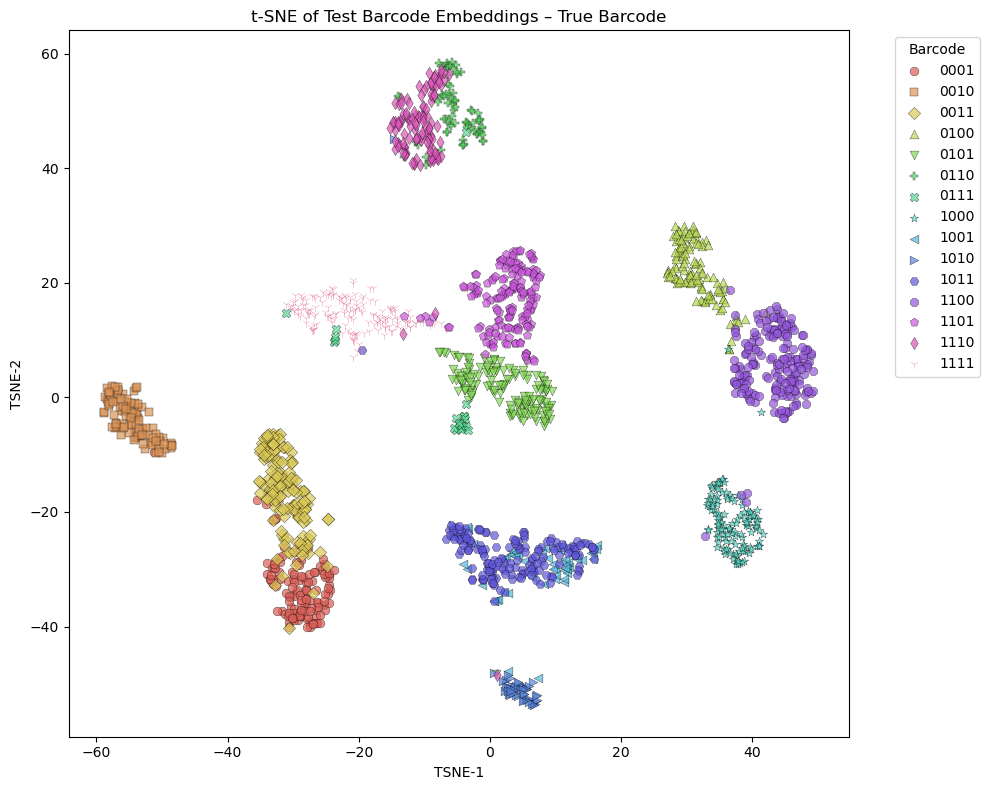

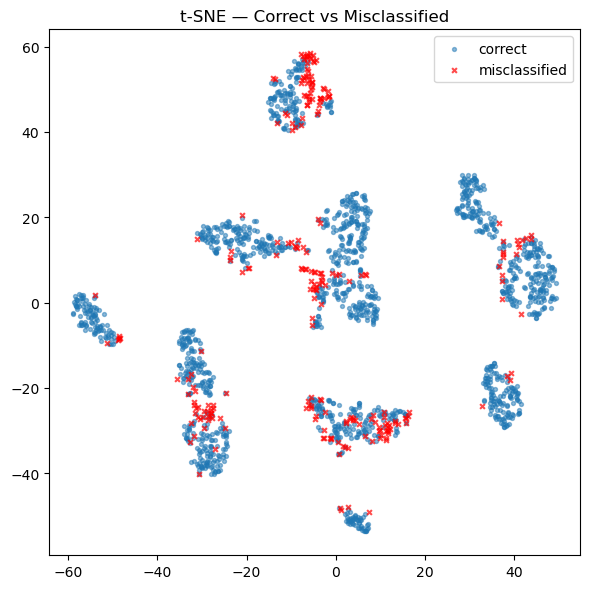

In [17]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# ── CONFIG ─────────────────────────────────────────────────────────
test_dir   = r"D:\PRISM\Mother Cell For PRISM Train\test_sets"
#model_file = r"D:\PRISM\PRISM_model\100xTraining\saved_model3\smallet-202505141639-39-0.96.keras"
model_file  = r"D:\PRISM\PRISM_model\100xTraining\saved_model3\test-202505151209-04-0.94.keras"

# ── 1) Load the trained model and construct embedding submodel ─────
channel_model = load_model(model_file, custom_objects={"L2NormLayer": L2NormLayer})
# The penultimate Dense (64-unit head) is the layer before Dropout and output
penult_output = channel_model.layers[-3].output
emb_model = Model(inputs=channel_model.input, outputs=penult_output)

# ── 2) Prepare lists for BFP/RFP data and true barcodes ──────────
bfp_list, rfp_list = [], []
true_bcs = []

for fn in sorted(os.listdir(test_dir)):
    if not fn.endswith("_test.zarr"):
        continue
    bc = fn[:4]
    zpath = os.path.join(test_dir, fn)
    z = zarr.open(zpath, mode="r")
    bfp = z["bfp"][...]  # (ncells,64,36)
    rfp = z["rfp"][...]

    # normalize per-cell and collect
    for bi, ri in zip(bfp, rfp):
        bi = bi.astype(np.float32)
        ri = ri.astype(np.float32)
        bfp_list.append((bi - bi.min()) / (bi.ptp() + 1e-8))
        rfp_list.append((ri - ri.min()) / (ri.ptp() + 1e-8))
        true_bcs.append(bc)

# stack and add channel dimension
X_bfp = np.stack(bfp_list, axis=0)[..., None]
X_rfp = np.stack(rfp_list, axis=0)[..., None]

N = len(true_bcs)
print(f"Embedding {N} test cells")

# ── 3) Predict classes and form 4-bit barcodes ─────────────────────
bit_map = {0: "00", 1: "10", 2: "01", 3: "11"}
pred_bfp = np.argmax(channel_model.predict(X_bfp, batch_size=128), axis=1)
pred_rfp = np.argmax(channel_model.predict(X_rfp, batch_size=128), axis=1)
pred_bcs = [bit_map[b] + bit_map[r] for b, r in zip(pred_bfp, pred_rfp)]

# ── 4) Compute embeddings for both channels ───────────────────────
emb_bfp = emb_model.predict(X_bfp, batch_size=128)
emb_rfp = emb_model.predict(X_rfp, batch_size=128)
emb_full = np.concatenate([emb_bfp, emb_rfp], axis=1)  # (N,128)

# ── 5) t-SNE → 2D ────────────────────────────────────────────────
emb2d = TSNE(n_components=2, random_state=42).fit_transform(emb_full)

# ── 6) Plot by true barcode ───────────────────────────────────────
unique_bcs = sorted(set(true_bcs))
n_classes = len(unique_bcs)
palette = sns.color_palette("hls", n_classes)
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '<', '>', 'H', '8', 'p', 'd', '1', '2']
plt.figure(figsize=(10, 8))
for i, bc in enumerate(unique_bcs):
    mask = np.array(true_bcs) == bc
    plt.scatter(
        emb2d[mask, 0], emb2d[mask, 1],
        s=40, marker=markers[i % len(markers)],
        color=palette[i], alpha=0.7,
        edgecolors='black', linewidths=0.3,
        label=bc
    )
plt.title("t-SNE of Test Barcode Embeddings – True Barcode")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Barcode", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ── 7) Plot correct vs misclassified ───────────────────────────────
correct = np.array(true_bcs) == np.array(pred_bcs)

plt.figure(figsize=(6, 6))
plt.scatter(emb2d[correct, 0], emb2d[correct, 1],
            s=8, alpha=0.5, label="correct")
plt.scatter(emb2d[~correct, 0], emb2d[~correct, 1],
            s=12, marker="x", color="red", alpha=0.7, label="misclassified")
plt.title("t-SNE — Correct vs Misclassified")
plt.legend()
plt.tight_layout()
plt.show()


# Test PRISM Setup 3 and 4

Here, I am training and testing the model by trainig with 8 barcodes and testing on the other 8 barcodes for step 3. For step 4, I am training on 8 barcodes and synthetic data.

### Test PRISM setup 3

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.371, μ₂=0.746  ⇒  T = 0.746



C:\Users\kastu\AppData\Local\Temp\ipykernel_67440\523321197.py:96: RuntimeWarning: invalid value encountered in divide
  accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100


── BEFORE rejection ─────────────────────────
 Overall accuracy: 69.30%  (N=2769)
 0000:   nan%
 0001:   nan%
 0010: 16.81%
 0011:   nan%
 0100: 95.18%
 0101:   nan%
 0110:   nan%
 0111:   nan%
 1000: 96.76%
 1001:   nan%
 1010: 98.04%
 1011: 62.91%
 1100:   nan%
 1101:   nan%
 1110: 70.69%
 1111: 64.54%

── AFTER rejection (kept 60.7% of cells) ─────────
 Overall accuracy: 80.07%  (N=1681)
 0000:   nan%
 0001:   nan%
 0010: 11.00%
 0011:   nan%
 0100: 98.07%
 0101:   nan%
 0110:   nan%
 0111:   nan%
 1000: 99.74%
 1001:   nan%
 1010: 100.00%
 1011: 74.80%
 1100:   nan%
 1101:   nan%
 1110: 86.29%
 1111: 76.34%


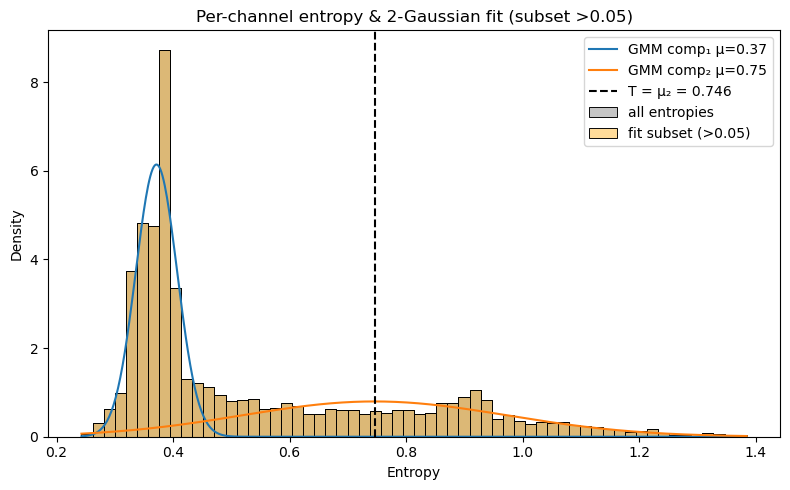

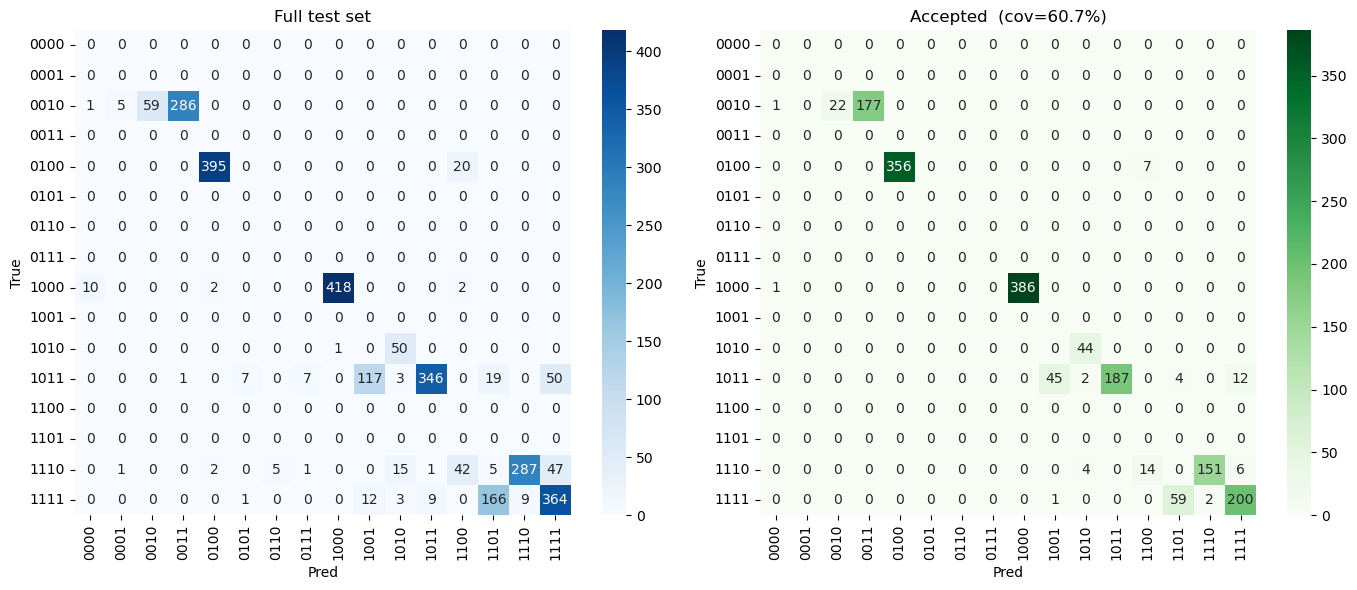

In [114]:
# 8 dataset only entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = r"D:\PRISM\General_Test_PRISM\test_sets"
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\generalisation88-20250516‐28-0.93.keras")
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\generalisation88-20250517-36-0.93.keras")
model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()


### Test PRISM Setup 4

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.353, μ₂=0.691  ⇒  T = 0.691



C:\Users\kastu\AppData\Local\Temp\ipykernel_105032\2747861025.py:98: RuntimeWarning: invalid value encountered in divide
  accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100


── BEFORE rejection ─────────────────────────
 Overall accuracy: 80.50%  (N=2769)
 0000:   nan%
 0001:   nan%
 0010: 69.52%
 0011:   nan%
 0100: 88.92%
 0101:   nan%
 0110:   nan%
 0111:   nan%
 1000: 99.31%
 1001:   nan%
 1010: 100.00%
 1011: 75.45%
 1100:   nan%
 1101:   nan%
 1110: 85.96%
 1111: 65.96%

── AFTER rejection (kept 64.3% of cells) ─────────
 Overall accuracy: 91.97%  (N=1780)
 0000:   nan%
 0001:   nan%
 0010: 88.12%
 0011:   nan%
 0100: 93.55%
 0101:   nan%
 0110:   nan%
 0111:   nan%
 1000: 99.76%
 1001:   nan%
 1010: 100.00%
 1011: 87.61%
 1100:   nan%
 1101:   nan%
 1110: 95.75%
 1111: 81.32%


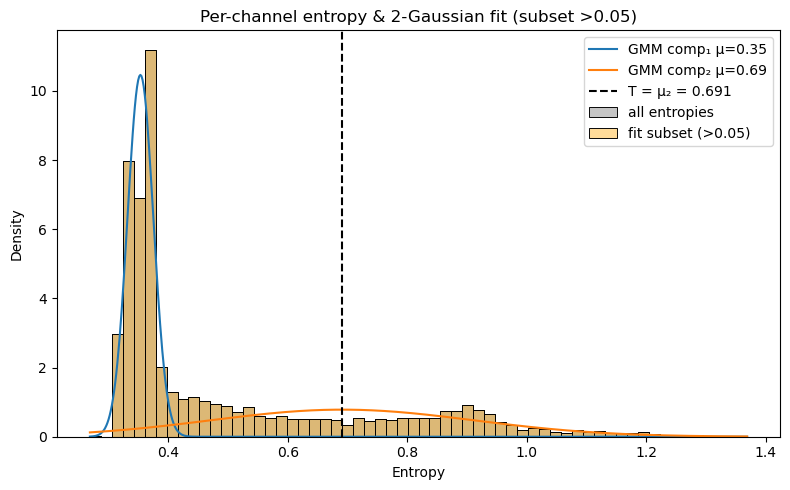

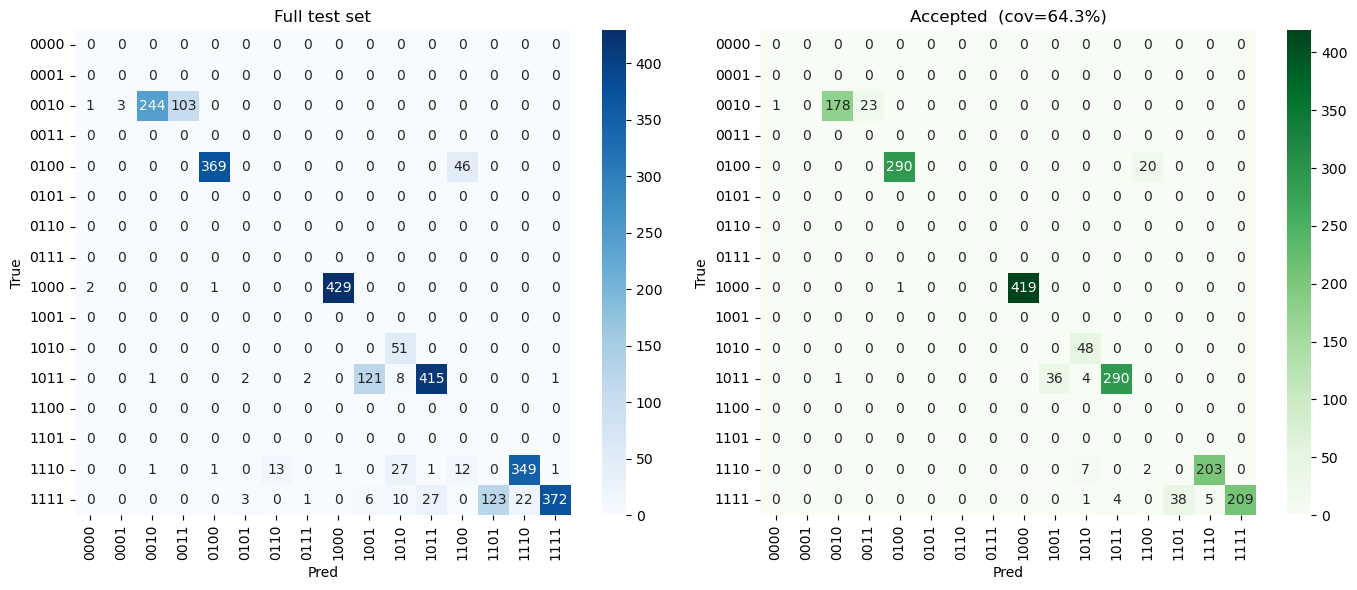

In [ ]:
# using synth entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = r"D:\PRISM\General_Test_PRISM\test_sets"
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
#MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\generalisation88andSynth-20250516‐25-0.95.keras")
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\generalisation_realandsynth-20250517-27-0.95.keras")


model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()
 

### Evaluating decoding speed

In [9]:
import os
import time
import zarr
import numpy as np
import tensorflow as tf

# ── 0) GPU setup (optional) ─────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = r"D:\PRISM\General_Test_PRISM\test_sets"
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\generalisation_realandsynth-20250517-27-0.95.keras")

model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}

# ── 2) Helper: load & normalize channel stack ────────────────────────
def load_channel(z, name):
    if name in z:
        arr = z[name][...].astype(np.float32)
    else:
        n = z[next(iter(z.array_keys()))].shape[0]
        h, w = z[next(iter(z.array_keys()))].shape[1:]
        arr = np.zeros((n, h, w), dtype=np.float32)
    mn  = arr.min(axis=(1,2), keepdims=True)
    ptp = arr.ptp(axis=(1,2), keepdims=True) + 1e-8
    return (arr - mn) / ptp

# ── 3) Inference + timing ───────────────────────────────────────────
true_bcs, pred_bcs = [], []
total_images = 0

start = time.perf_counter()

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):
        continue

    bc_true = fn[:4]
    z = zarr.open(os.path.join(TEST_SETS, fn), mode="r")

    bfp = load_channel(z, "bfp")
    rfp = load_channel(z, "rfp")

    # predict each cell in both channels
    for stack in (bfp, rfp):
        for img in stack:
            x = img[None, ..., None]  # shape (1, H, W, 1)
            p = model.predict(x, verbose=0)
            lb = np.argmax(p[0])
            # for full-barcode we need both channels; but here we just count
            true_bcs.append(bc_true)
            # store a placeholder to keep lengths equal; you can replace this
            pred_bcs.append("XX")
            total_images += 1

end = time.perf_counter()
elapsed = end - start

# ── 4) Report ───────────────────────────────────────────────────────
print(f"\nClassified {total_images} images in {elapsed:.2f} seconds")
print(f"Throughput: {total_images/elapsed:.1f} images/second")



Classified 5538 images in 259.42 seconds
Throughput: 21.3 images/second


In [11]:
import os
import time
import platform
import psutil
import zarr
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

# ── Machine specs ─────────────────────────────────────────────────────
print("Machine specs:")
print(f"  Hostname: {platform.node()}")
print(f"  OS:       {platform.system()} {platform.release()}")
print(f"  CPU:      {platform.processor()} ({psutil.cpu_count(logical=False)} cores, {psutil.cpu_count()} threads)")
mem = psutil.virtual_memory()
print(f"  RAM:      {mem.total/1e9:.1f} GB total, {mem.available/1e9:.1f} GB available")

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"  GPU:      {gpus[0].name}")
else:
    print("  GPU:      None detected")


Machine specs:
  Hostname: LAPTOP-B67HRL43
  OS:       Windows 10
  CPU:      AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD (8 cores, 16 threads)
  RAM:      16.5 GB total, 1.0 GB available
  GPU:      None detected


Figure for Appendix to show breakdown of each barcode accuracy.

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.357, μ₂=0.651  ⇒  T = 0.651

── BEFORE rejection ─────────────────────────
 Overall accuracy: 85.06%  (N=5878)
 0000: 100.00%
 0001: 95.19%
 0010: 69.52%
 0011: 81.31%
 0100: 88.92%
 0101: 76.02%
 0110: 60.29%
 0111: 82.61%
 1000: 99.31%
 1001: 76.74%
 1010: 100.00%
 1011: 75.45%
 1100: 92.41%
 1101: 96.96%
 1110: 85.96%
 1111: 65.96%

── AFTER rejection (kept 66.0% of cells) ─────────
 Overall accuracy: 95.80%  (N=3877)
 0000: 100.00%
 0001: 99.34%
 0010: 89.95%
 0011: 94.90%
 0100: 94.56%
 0101: 97.04%
 0110: 85.19%
 0111: 100.00%
 1000: 99.76%
 1001: 80.00%
 1010: 100.00%
 1011: 89.84%
 1100: 97.15%
 1101: 99.35%
 1110: 95.83%
 1111: 83.97%
Barcode  Tested  Kept  Retention (%)  Acc before (%)  Acc after (%)
   0000     341   341     100.000000      100.000000     100.000000
   0001     437   304      69.565217       95.194508      99.342105
   0010     351   189      53.846154       69.515670      89.947090
   001

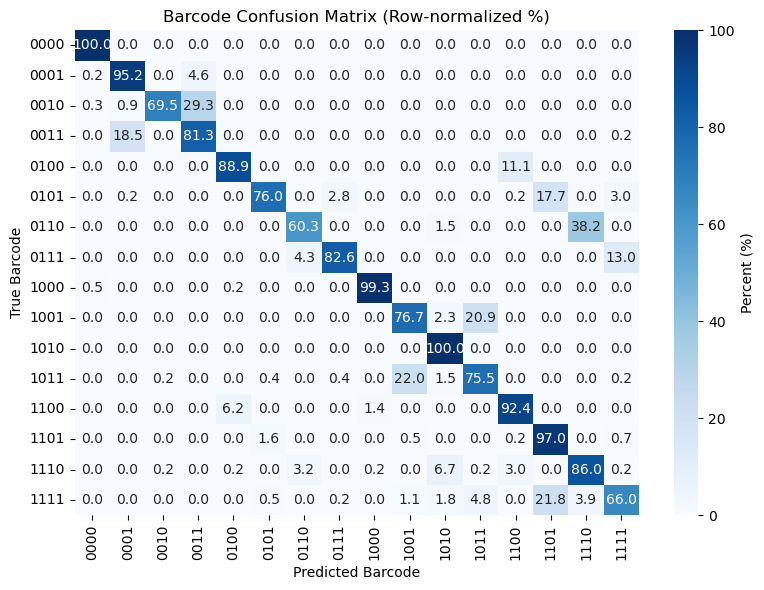


Retention Table:
Barcode  Tested  Kept  Retention (%)
   0000     341   341     100.000000
   0001     437   304      69.565217
   0010     351   189      53.846154
   0011     487   294      60.369610
   0100     415   294      70.843373
   0101     492   203      41.260163
   0110      68    27      39.705882
   0111      23    12      52.173913
   1000     432   418      96.759259
   1001      43    25      58.139535
   1010      51    48      94.117647
   1011     550   305      55.454545
   1100     659   527      79.969651
   1101     559   461      82.468694
   1110     406   192      47.290640
   1111     564   237      42.021277


In [ ]:

import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = r"D:\PRISM\Test All\test_sets"
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
#MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\generalisation88andSynth-20250516‐25-0.95.keras")
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\generalisation_realandsynth-20250517-27-0.95.keras")


model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")
# ── After rejection analysis per barcode ─────────────────────────────────

import pandas as pd
from sklearn.metrics import confusion_matrix

# Prepare arrays
bcs = np.array(true_bcs)
preds = np.array(pred_bcs)
keep = np.array(keep_mask)

# Unique barcode labels
labels = sorted(set(bcs) | set(preds))

# Initialize list for per-barcode stats
stats = []

for bc in labels:
    # indices for this barcode
    idx_all = np.where(bcs == bc)[0]
    idx_keep = idx_all[keep[idx_all]]
    
    n_test = len(idx_all)
    n_keep = len(idx_keep)
    retention = 100 * n_keep / n_test if n_test else np.nan
    
    # accuracy before rejection
    acc_before = 100 * np.mean(preds[idx_all] == bc) if n_test else np.nan
    # accuracy after rejection
    acc_after = 100 * np.mean(preds[idx_keep] == bc) if n_keep else np.nan
    
    stats.append({
        'Barcode': bc,
        'Tested': n_test,
        'Kept': n_keep,
        'Retention (%)': retention,
        'Acc before (%)': acc_before,
        'Acc after (%)': acc_after
    })

# Print per-barcode summary
df_stats = pd.DataFrame(stats)
print(df_stats.to_string(index=False))

# ── Plot confusion matrix in percent ────────────────────────────────────

# Compute normalized confusion matrix before rejection
cm = confusion_matrix(bcs, preds, labels=labels)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8,6))
sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label": "Percent (%)"})
plt.xlabel("Predicted Barcode")
plt.ylabel("True Barcode")
plt.title("Barcode Confusion Matrix (Row-normalized %)")
plt.tight_layout()
plt.show()

# ── Additional table: Test vs. Accepted counts and retention ─────────────
df_retention = df_stats[['Barcode','Tested','Kept','Retention (%)']]
print("\nRetention Table:")
print(df_retention.to_string(index=False))


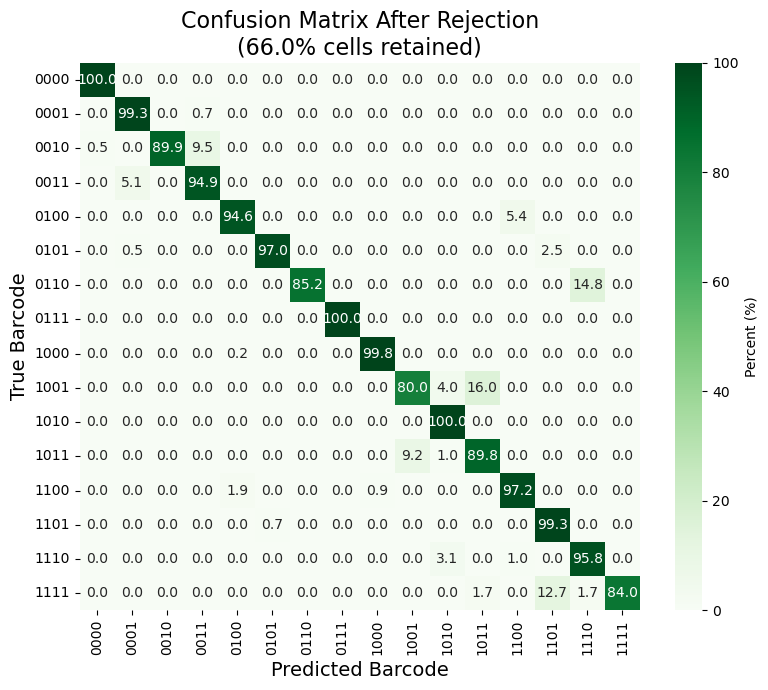

In [10]:
from sklearn.metrics import confusion_matrix

# ── Confusion matrix after rejection ─────────────────────────────────────
cm_rej      = confusion_matrix(true_bcs[keep_mask],
                               pred_bcs[keep_mask],
                               labels=all_bcs)
cm_rej_pct  = cm_rej.astype(float) / cm_rej.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8,7))
sns.heatmap(cm_rej_pct,
            annot=True, fmt=".1f",
            cmap="Greens",
            xticklabels=all_bcs,
            yticklabels=all_bcs,
            cbar_kws={"label": "Percent (%)"})
plt.xlabel("Predicted Barcode", fontsize=14)
plt.ylabel("True Barcode", fontsize=14)
plt.title(f"Confusion Matrix After Rejection\n({coverage:.1f}% cells retained)", fontsize=16)
plt.tight_layout()
plt.show()


# (not included in the report) Test with all real + synth for all class

Train on all 16 experiment and synthetic data as a upper bound for accuracy.

⚠️  No GPU detected — running on CPU

📏  GMM (fit on ent>0.05) → μ₁=0.355, μ₂=0.605  ⇒  T = 0.605

── BEFORE rejection ─────────────────────────
 Overall accuracy: 89.99%  (N=2358)
 0000: 100.00%
 0001: 97.13%
 0010: 91.43%
 0011: 78.87%
 0100: 93.98%
 0101: 68.37%
 0110: 81.48%
 0111: 88.89%
 1000: 98.84%
 1001: 94.12%
 1010: 95.00%
 1011: 84.09%
 1100: 90.49%
 1101: 95.07%
 1110: 96.30%
 1111: 91.56%

── AFTER rejection (kept 64.5% of cells) ─────────
 Overall accuracy: 98.75%  (N=1521)
 0000: 100.00%
 0001: 100.00%
 0010: 98.98%
 0011: 96.10%
 0100: 100.00%
 0101: 100.00%
 0110: 91.67%
 0111: 100.00%
 1000: 100.00%
 1001: 92.86%
 1010: 94.74%
 1011: 97.22%
 1100: 98.82%
 1101: 100.00%
 1110: 99.21%
 1111: 96.23%


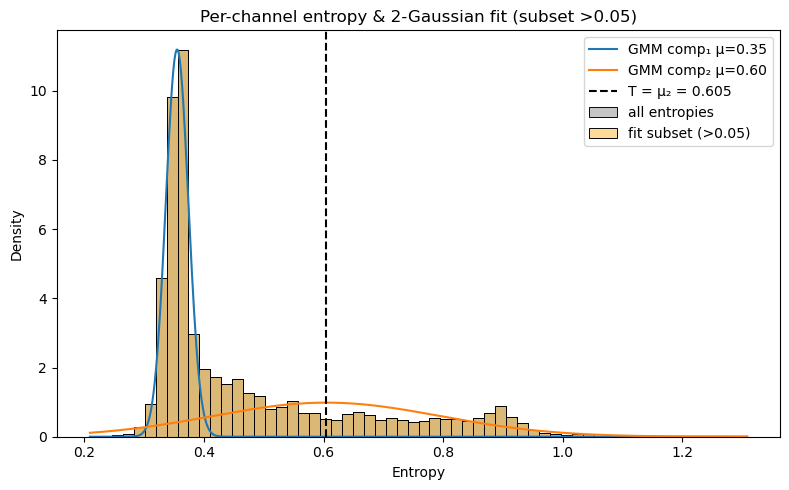

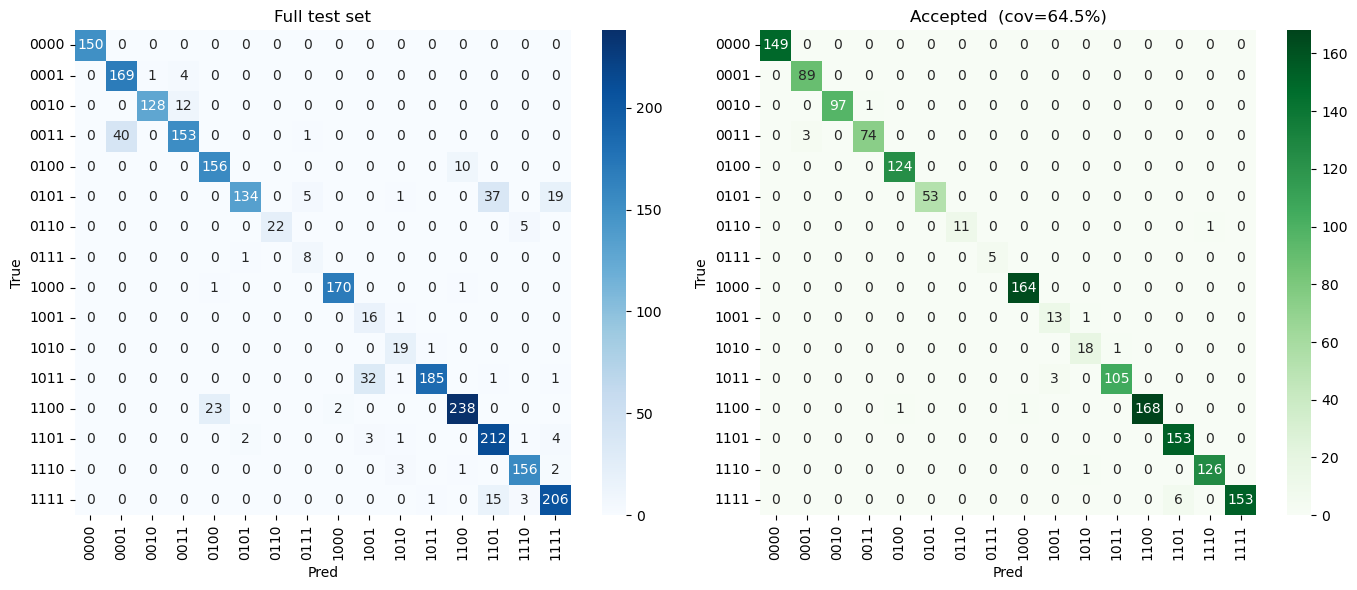

In [42]:
# using synth entropy-based rejection with GMM fitted on entropies > 0.05
import os, zarr, math
import numpy as np
import tensorflow as tf
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ── 0) GPU set-up ────────────────────────────────────────────────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Using GPU: {gpus[0].name.split('/')[-1]}")
else:
    print("⚠️  No GPU detected — running on CPU")

# ── 1) Paths & model ────────────────────────────────────────────────
BASE       = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_SETS  = os.path.join(BASE, "test_sets")
# MODEL_FILE  = r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505132143‐31-0.93.keras"
# MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\saved‐plain‐glbmodel-202505142138‐32-0.94.keras")
#MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel\generalisation88andSynth-20250516‐25-0.95.keras")
MODEL_FILE   = os.path.join(BASE, r"D:\PRISM\PRISM_model\100xTraining\saved_glbmodel_smooth\finalallrealsynth-20250517-21-0.95.keras")


model = tf.keras.models.load_model(MODEL_FILE)

code_map = {0:"00", 1:"10", 2:"01", 3:"11"}          # class-id → 2-bit code

# ── 2) Pass 1: collect per-channel entropies ─────────────────────────
all_ent = []
for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"):           # skip non-barcode files
        continue
    z = zarr.open(os.path.join(TEST_SETS, fn), "r")
    for chan in ("bfp", "rfp"):
        for img in z[chan]:
            img = img.astype(np.float32)
            img = (img - img.min()) / (img.ptp() + 1e-8)
            p   = model.predict(img[None, ..., None], verbose=0)[0]
            all_ent.append(-np.sum(p * np.log(p + 1e-12)))

all_ent = np.array(all_ent)              # shape (N,)

# ── 3) GMM on entropies > 0.05 ───────────────────────────────────────
MASK_FIT = all_ent > 0.05
ent_fit  = all_ent[MASK_FIT].reshape(-1, 1)

gmm   = GaussianMixture(n_components=2, random_state=0).fit(ent_fit)
μs    = np.sort(gmm.means_.flatten())          # ascending
σs    = np.sqrt(np.sort(gmm.covariances_.flatten()))
wts   = gmm.weights_[np.argsort(gmm.means_.flatten())]

T = μs[1]                                      # higher-mean threshold
print(f"\n📏  GMM (fit on ent>0.05) → μ₁={μs[0]:.3f}, μ₂={μs[1]:.3f}  ⇒  T = {T:.3f}\n")

# ── 4) Pass 2: barcode prediction + entropy-based rejection ──────────
true_bcs, pred_bcs, keep_mask = [], [], []

for fn in sorted(os.listdir(TEST_SETS)):
    if not fn.endswith("_test.zarr"): continue
    bc_true = fn[:4]                                    # ground-truth barcode
    z       = zarr.open(os.path.join(TEST_SETS, fn), "r")
    B, R    = z["bfp"][...], z["rfp"][...]

    for b_img, r_img in zip(B, R):
        # preprocess
        b = (b_img.astype(np.float32) - b_img.min()) / (b_img.ptp() + 1e-8)
        r = (r_img.astype(np.float32) - r_img.min()) / (r_img.ptp() + 1e-8)

        pb = model.predict(b[None, ..., None], verbose=0)[0]
        pr = model.predict(r[None, ..., None], verbose=0)[0]

        ent_b = -np.sum(pb * np.log(pb + 1e-12))
        ent_r = -np.sum(pr * np.log(pr + 1e-12))
        keep  = (ent_b < T) and (ent_r < T)            # reject if *any* channel high-entropy

        bc_pred = code_map[np.argmax(pb)] + code_map[np.argmax(pr)]

        true_bcs.append(bc_true)
        pred_bcs.append(bc_pred)
        keep_mask.append(keep)

true_bcs  = np.array(true_bcs)
pred_bcs  = np.array(pred_bcs)
keep_mask = np.array(keep_mask)

# ── helper: confusion + accuracies ───────────────────────────────────
def confusion_and_acc(trues, preds, label_set):
    lbls = sorted(label_set)
    m    = {bc:i for i,bc in enumerate(lbls)}
    cm   = np.zeros((len(lbls), len(lbls)), int)
    for t, p in zip(trues, preds):
        cm[m[t], m[p]] += 1
    accs = np.where(cm.sum(1)==0, np.nan, np.diag(cm)/cm.sum(1))*100
    ovr  = np.trace(cm)/cm.sum()*100
    return lbls, cm, accs, ovr

all_bcs = sorted(set(true_bcs) | set(pred_bcs))

# ── 5) Before rejection ──────────────────────────────────────────────
_, cm_full, acc_full, ovr_full = confusion_and_acc(true_bcs, pred_bcs, all_bcs)
print("── BEFORE rejection ─────────────────────────")
print(f" Overall accuracy: {ovr_full:.2f}%  (N={len(true_bcs)})")
for bc,a in zip(all_bcs, acc_full): print(f" {bc}: {a:5.2f}%")

# ── 6) After rejection ───────────────────────────────────────────────
tr_keep, pr_keep = true_bcs[keep_mask], pred_bcs[keep_mask]
_, cm_keep, acc_keep, ovr_keep = confusion_and_acc(tr_keep, pr_keep, all_bcs)
coverage = keep_mask.mean()*100
print(f"\n── AFTER rejection (kept {coverage:.1f}% of cells) ─────────")
print(f" Overall accuracy: {ovr_keep:.2f}%  (N={len(tr_keep)})")
for bc,a in zip(all_bcs, acc_keep): print(f" {bc}: {a:5.2f}%")

# ── 7) Plot entropy histogram + GMM fit ──────────────────────────────
x = np.linspace(all_ent.min(), all_ent.max(), 600)
p1 = wts[0]*norm.pdf(x, μs[0], σs[0])
p2 = wts[1]*norm.pdf(x, μs[1], σs[1])

plt.figure(figsize=(8,5))
sns.histplot(all_ent, bins=60, stat="density", color="gray", alpha=0.45, label="all entropies")
sns.histplot(all_ent[all_ent>0.05], bins=60, stat="density", color="orange", alpha=0.4, label="fit subset (>0.05)")
plt.plot(x, p1, c="C0", label=f"GMM comp₁ μ={μs[0]:.2f}")
plt.plot(x, p2, c="C1", label=f"GMM comp₂ μ={μs[1]:.2f}")
plt.axvline(T, ls="--", c="k", label=f"T = μ₂ = {T:.3f}")
plt.xlabel("Entropy"); plt.ylabel("Density")
plt.title("Per-channel entropy & 2-Gaussian fit (subset >0.05)")
plt.legend(); plt.tight_layout(); plt.show()

# ── 8) Plot confusion matrices ───────────────────────────────────────
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[0])
ax[0].set(title="Full test set", xlabel="Pred", ylabel="True")

sns.heatmap(cm_keep, annot=True, fmt="d", cmap="Greens",
            xticklabels=all_bcs, yticklabels=all_bcs, ax=ax[1])
ax[1].set(title=f"Accepted  (cov={coverage:.1f}%)", xlabel="Pred", ylabel="True")

plt.tight_layout(); plt.show()


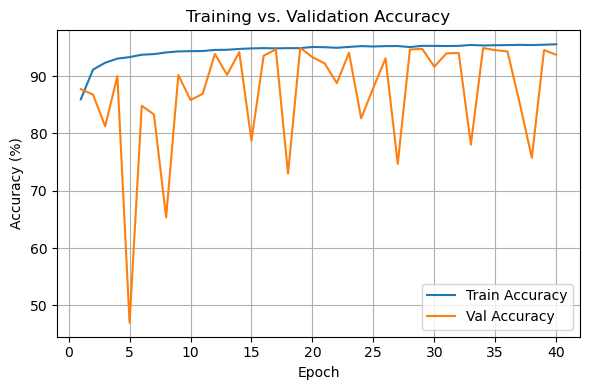

In [11]:
import matplotlib.pyplot as plt

def plot_training_curves(hist, metric="accuracy"):
    """
    Plot training & validation curves (in %) for `metric`.
    Works with a Keras History object.
    """
    epochs = range(1, len(hist.history[metric]) + 1)
    train = [v * 100 for v in hist.history[metric]]
    val   = [v * 100 for v in hist.history[f"val_{metric}"]]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label=f"Train {metric.capitalize()}")
    plt.plot(epochs, val,   label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{metric.capitalize()} (%)")
    plt.title(f"Training vs. Validation {metric.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call it (rename `history` if your variable is different)
plot_training_curves(history_model2, metric="accuracy")
